In [1]:
import numpy as np
import sys
sys.path.append('../../')
import do_mpc
from casadi import *
import matplotlib.pyplot as plt
N_ref=300
J=500
La=1
Lb=1
m=200
Cy=0.01
t_s=0.1 #sample time
N=50

In [2]:
def y_x(x):
    return 0.15*np.sin(x*x/25)

def v_x(x):
    return 1

In [3]:
def mpc_model():
    # Obtain an instance of the do-mpc model class
    # and select time discretization:
    model_type = 'continuous' # either 'discrete' or 'continuous'
    model = do_mpc.model.Model(model_type)

    # Introduce new states, inputs and other variables to the model, e.g.:
    xc=model.set_variable(var_type='_x',var_name='xc',shape=(1,1))
    yc=model.set_variable(var_type='_x',var_name='yc',shape=(1,1))
    v=model.set_variable(var_type='_x',var_name='v',shape=(1,1))
    theta=model.set_variable(var_type='_x',var_name='theta',shape=(1,1))
    phi=model.set_variable(var_type='_x',var_name='phi',shape=(1,1))
    delta=model.set_variable(var_type='_x',var_name='delta',shape=(1,1))
#     a_s=model.set_variable(var_type='_x',var_name='a_s',shape=(1,1))
#     w_s=model.set_variable(var_type='_x',var_name='w_s',shape=(1,1))
    
    # virtual state for timing law
    z = model.set_variable(var_type='_x', var_name='z', shape = (1,1))
    
    
#     #time varying setpoint for path following
#     target_x = model.set_variable(var_type = '_tvp', var_name = 'target_x', shape = (1,1))
#     target_y = model.set_variable(var_type = '_tvp', var_name = 'target_y', shape = (1,1))
    

    #control inputs
    a=model.set_variable(var_type='_u',var_name='a',shape=(1,1))
    w=model.set_variable(var_type='_u',var_name='w',shape=(1,1))
    
    # virtual control input for timing law
    u_v = model.set_variable(var_type='_u',var_name='u_v', shape=(1,1))
    
    # Force on tyres
    Fyf=Cy*(delta-(La*phi)/v)
    Fyr=(Cy*Lb*phi)/v
    
    
    # vehicle dyanmics equations
    equations=vertcat(v*np.cos(theta), 
                      v*np.sin(theta),
                      a* np.cos(delta)-(2.0/m)*Fyf*np.sin(delta),
                      phi,
                      (1.0/J)*(La*(m*a*np.sin(delta)+2*Fyf*np.cos(delta))-2*Lb*Fyr),
                      w,
        #               (1/t_s)*(a-a_s),
        #               (1/t_s)*(w-w_s)
                     )
    
    #RHS of vehicle dynamics ODEs
    model.set_rhs('xc',equations[0])
    model.set_rhs('yc',equations[1])
    model.set_rhs('v',equations[2])
    model.set_rhs('theta',equations[3])
    model.set_rhs('phi',equations[4])
    model.set_rhs('delta',equations[5])
#     model.set_rhs('a_s',equations[6])
#     model.set_rhs('w_s',equations[7])
    
    #timing law equation
    timing_law = u_v
    
    #RHS of timing law ODEs
    model.set_rhs('z', timing_law)
#     model.set_rhs('z[1]', timing_law[1])
#     model.set_rhs('z[2]', timing_law[2])
#     model.set_rhs('z[3]', timing_law[3])
#     model.set_rhs('z[4]', timing_law[4])
    
    # Setup model:
    model.setup()

    return model

In [4]:
def controller(model, x_ref,y_ref):
    # Obtain an instance of the do-mpc MPC class
    # and initiate it with the model:
    mpc = do_mpc.controller.MPC(model)

    # Set parameters:
    setup_mpc = {
        'n_horizon': N,
        't_step': t_s,
        'n_robust': 0,
        'open_loop':0,
        'state_discretization': 'collocation',
        'collocation_type': 'radau',
        'collocation_deg': 2,
        'collocation_ni': 2,
        'store_full_solution': True,
    }
    mpc.set_param(**setup_mpc)
    
#     #Configuring the time varying behaviour of the setpoints
    
#     tvp_temp = mpc.get_tvp_template()
#     def tvp_fun(t_now):
#         for k in range(N+1):
#                 tvp_temp['_tvp',k,'target_x'] = x_ref[int(t_now//t_s) + k]
#                 tvp_temp['_tvp',k,'target_y'] = y_ref[int(t_now//t_s) + k]
#         return tvp_temp    
#     mpc.set_tvp_fun(tvp_fun)
    
    
    xc = model.x['xc']
    yc = model.x['yc']
    z = model.x['z']
    
    # Configure objective function:
    # cost = ((model.x['xc'] - model.tvp['target_x'])/(model.tvp['target_x']+1e-9))**2 + ((model.x['yc'] - model.tvp['target_y'])/(model.tvp['target_y']+1e8) )**2
    cost = (xc-z)**2 + (yc-y_x(z))**2 + (model.x['v']-v_x(z))**2
    
    mterm = cost # terminal cost
    lterm = cost # stage cost

    mpc.set_objective(mterm=mterm, lterm=lterm)
    mpc.set_rterm(a=0.000001)
    mpc.set_rterm(w=0.000001) # Scaling for quad. cost.

    # State and input bounds:
#     mpc.bounds['lower','_x','xc']=x_0[0]-1e-4
#     mpc.bounds['lower','_x','yc']=y_lower
    mpc.bounds['lower','_x','v']=0 #max reverse speed in m/s
    mpc.bounds['lower','_x','theta']=-50
    mpc.bounds['lower','_x','phi']=-50
    mpc.bounds['lower','_x','delta']=-50
    mpc.bounds['lower', '_x', 'z'] = 0
#     mpc.bounds['upper','_x','xc']=target_x+0.1
#     mpc.bounds['upper','_x','yc']=y_upper
    mpc.bounds['upper','_x','v']=20 #max forward speed in m/s
    mpc.bounds['upper','_x','theta']=50
    mpc.bounds['upper','_x','phi']=50
    mpc.bounds['upper','_x','delta']=50
    mpc.bounds['lower','_u','a']=-10
    mpc.bounds['lower','_u','w']=-10
    mpc.bounds['upper','_u','a']=10
    mpc.bounds['upper','_u','w']=10
    mpc.bounds['lower','_u', 'u_v'] = 0
#     mpc.bounds['lower','_x','a_s']=-10
#     mpc.bounds['lower','_x','w_s']=-10
#     mpc.bounds['upper','_x','a_s']=10
#     mpc.bounds['upper','_x','w_s']=10

    mpc.setup()

    return mpc

In [5]:
def mpc_simulator(model,x_ref,y_ref):
    # Obtain an instance of the do-mpc simulator class
    # and initiate it with the model:
    simulator = do_mpc.simulator.Simulator(model)

    # Set parameter(s):
    simulator.set_param(t_step = t_s)

    # Set function for time-varying parameters.
    # Get the template
#     tvp_temp = simulator.get_tvp_template()

#     # Define the function (indexing is much simpler ...)
#     def tvp_fun(t_now):
#             tvp_temp['target_x'] = x_ref[int(t_now//t_s)]
#             tvp_temp['target_y'] = y_ref[int(t_now//t_s)]
#             return tvp_temp

#     # Set the tvp_fun:
#     simulator.set_tvp_fun(tvp_fun)

    # Setup simulator:
    simulator.setup()

    return simulator



################################################    0    #########################################



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     8907
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2104

Total number of variables............................:     2649
                     variables with only lower bounds:      394
                variables with lower and uppe

  87 7.1268499e-005 1.93e-005 3.36e-007  -8.6 4.39e-002  -5.1 1.00e+000 1.00e+000h  1
  88 7.1205626e-005 8.68e-005 5.59e-007  -8.6 9.14e-002  -5.6 1.00e+000 1.00e+000h  1
  89 7.1131356e-005 4.05e-006 5.76e-008  -8.6 6.20e-002  -6.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 7.1044349e-005 1.64e-005 7.87e-008  -8.6 1.10e-001  -6.5 1.00e+000 1.00e+000h  1
  91 7.1034832e-005 1.41e-004 4.67e-007  -8.6 1.28e+000  -7.0 1.00e+000 1.25e-001h  4
  92 7.0898985e-005 4.08e-006 4.62e-007  -8.6 2.92e-002  -4.8 1.00e+000 1.00e+000h  1
  93 7.0840305e-005 4.69e-005 3.39e-007  -8.6 6.78e-002  -5.3 1.00e+000 1.00e+000h  1
  94 7.0772325e-005 4.42e-005 2.94e-007  -8.6 5.58e-002  -5.7 1.00e+000 1.00e+000h  1
  95 7.0719989e-005 2.13e-006 3.38e-008  -8.6 5.58e-002  -6.2 1.00e+000 1.00e+000h  1
  96 7.0650074e-005 1.84e-005 5.52e-008  -8.6 1.03e-001  -6.7 1.00e+000 1.00e+000h  1
  97 7.0616658e-005 1.17e-005 4.69e-008  -8.6 3.49e-002  -6

   3 5.5066704e+000 8.90e-003 4.05e-002  -1.0 2.56e+000  -1.8 9.27e-001 1.00e+000f  1
   4 3.3678517e+000 8.74e-004 3.73e-002  -1.7 9.23e-001  -1.4 1.00e+000 1.00e+000f  1
   5 2.4951755e+000 1.28e-004 6.18e-002  -2.5 5.73e-001  -1.0 1.00e+000 1.00e+000f  1
   6 1.3423928e+000 3.37e-004 2.71e-002  -2.5 7.54e-001  -1.4 1.00e+000 1.00e+000f  1
   7 3.2801406e-001 1.93e-003 1.49e-002  -3.8 1.24e+000  -1.9 8.79e-001 1.00e+000f  1
   8 2.5629462e-002 7.18e-004 8.20e-003  -3.8 1.37e+000  -2.4 1.00e+000 1.00e+000f  1
   9 8.2982644e-003 9.08e-005 3.08e-003  -3.8 2.89e-001  -2.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.3109970e-003 1.13e-004 1.09e-003  -3.8 3.08e-001  -2.4 1.00e+000 1.00e+000h  1
  11 1.3253516e-004 2.63e-004 2.31e-004  -5.7 1.94e-001  -2.9 9.87e-001 1.00e+000h  1
  12 7.6524634e-005 2.21e-005 3.68e-005  -5.7 9.16e-002  -3.4 1.00e+000 1.00e+000h  1
  13 6.5302219e-005 2.88e-005 2.15e-005  -5.7 1.64e-001  -3

  28 1.9030067e-005 2.85e-006 3.72e-008  -8.6 4.65e-002  -6.1 1.00e+000 1.00e+000h  1
  29 1.9019453e-005 6.21e-007 3.62e-008  -8.6 3.61e-002  -6.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.9014288e-005 5.49e-007 5.11e-008  -8.6 3.73e-002  -7.1 1.00e+000 1.00e+000h  1
  31 1.9012869e-005 8.71e-007 3.17e-008  -8.6 3.07e-002  -7.5 1.00e+000 1.00e+000h  1
  32 1.9012691e-005 1.04e-006 2.39e-008  -8.6 2.87e-002  -8.0 1.00e+000 2.50e-001h  3
  33 1.9012675e-005 1.07e-006 2.38e-008  -8.6 5.24e-001  -8.5 1.00e+000 3.91e-003h  9
  34 1.9012638e-005 1.11e-006 2.31e-008  -8.6 1.04e-001  -8.1 1.00e+000 3.12e-002h  6
  35 1.9012618e-005 1.25e-006 2.17e-008  -8.6 9.16e-002  -8.5 1.00e+000 6.25e-002h  5
  36 1.9012251e-005 1.42e-006 7.61e-009  -8.6 1.39e-002  -9.0 1.00e+000 1.00e+000h  1
  37 1.9011715e-005 2.91e-007 1.16e-009  -8.6 6.56e-003  -9.5 1.00e+000 1.00e+000h  1
  38 1.9011586e-005 1.54e-008 5.12e-011  -8.6 1.53e-003 -10

   1 1.8440076e-001 2.68e-003 5.37e-002  -1.0 3.02e-001  -4.0 9.60e-001 1.00e+000f  1
   2 8.6160919e-001 2.37e-004 1.58e-001  -1.0 9.54e-001  -0.9 8.26e-001 1.00e+000f  1
   3 5.2465006e-001 1.50e-003 5.37e-002  -1.7 4.97e-001  -1.3 1.00e+000 1.00e+000f  1
   4 1.5382237e-001 2.88e-004 6.75e-003  -2.5 4.45e-001  -1.8 1.00e+000 1.00e+000f  1
   5 8.2076462e-002 1.78e-005 6.45e-003  -3.8 1.59e-001  -1.4 1.00e+000 1.00e+000h  1
   6 2.2234404e-002 5.79e-005 3.16e-003  -3.8 2.36e-001  -1.9 1.00e+000 1.00e+000f  1
   7 2.4343985e-003 8.11e-005 1.39e-003  -3.8 3.08e-001  -2.3 1.00e+000 1.00e+000h  1
   8 1.0978383e-004 4.81e-005 2.70e-004  -5.7 1.82e-001  -2.8 9.93e-001 1.00e+000h  1
   9 3.2848479e-005 1.86e-005 3.67e-005  -5.7 7.10e-002  -3.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.8225624e-005 1.08e-005 7.16e-006  -5.7 4.30e-002  -3.8 1.00e+000 1.00e+000h  1
  11 2.5379801e-005 2.76e-005 5.71e-006  -8.6 1.03e-001  -4

   6 2.0521677e-001 2.31e-004 2.37e-002  -2.5 1.55e-001  -1.0 1.00e+000 1.00e+000h  1
   7 7.9636220e-002 3.21e-004 1.08e-002  -3.8 2.92e-001  -1.4 1.00e+000 1.00e+000f  1
   8 5.5135142e-002 2.45e-005 6.89e-003  -3.8 7.03e-002  -1.0 1.00e+000 1.00e+000h  1
   9 2.5514076e-002 4.30e-005 3.27e-003  -3.8 1.02e-001  -1.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.4277212e-003 8.58e-005 2.23e-003  -3.8 2.10e-001  -2.0 1.00e+000 1.00e+000h  1
  11 3.0893447e-004 1.29e-003 1.31e-003  -3.8 4.66e-001  -2.9 1.00e+000 1.00e+000h  1
  12 2.8232068e-005 1.33e-004 1.50e-004  -5.7 1.92e-001  -3.4 9.92e-001 1.00e+000h  1
  13 1.8955837e-005 2.25e-005 1.25e-005  -5.7 9.87e-002  -3.9 1.00e+000 1.00e+000h  1
  14 1.6316468e-005 7.21e-005 4.97e-006  -5.7 1.13e-001  -4.4 1.00e+000 1.00e+000h  1
  15 1.5670042e-005 3.55e-006 4.13e-006  -5.7 3.53e-002  -3.9 1.00e+000 1.00e+000h  1
  16 1.4652571e-005 3.31e-005 3.11e-006  -8.6 7.98e-002  -4

Total number of variables............................:     2649
                     variables with only lower bounds:      394
                variables with lower and upper bounds:     1476
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2457
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6.6307435e-006 1.06e-001 2.33e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.6778104e-001 1.75e-003 4.17e-002  -1.0 3.36e-001  -4.0 9.62e-001 1.00e+000f  1
   2 6.7641035e-001 3.24e-004 8.06e-002  -1.0 5.90e-001  -0.9 1.00e+000 1.00e+000f  1
   3 4.6593764e-001 1.08e-005 4.27e-002  -2.5 1.17e-001  -0.4 1.00e+000 1.00e+000f  

  30 3.0933657e-006 9.10e-007 4.73e-008  -8.6 2.05e-002  -8.1 1.00e+000 1.00e+000h  1
  31 3.0933485e-006 9.84e-007 4.46e-008  -8.6 6.75e-002  -9.0 1.00e+000 6.25e-002h  5
  32 3.0933394e-006 1.04e-006 4.43e-008  -8.6 3.73e-001  -8.6 1.00e+000 7.81e-003h  8
  33 3.0933280e-006 1.07e-006 4.42e-008  -8.6 1.14e+000  -8.6 1.00e+000 1.95e-003h 10
  34 3.0933124e-006 1.09e-006 4.39e-008  -8.6 2.79e-001  -9.1 1.00e+000 7.81e-003h  8
  35 3.0932916e-006 1.15e-006 4.15e-008  -8.6 7.16e-002 -10.1 1.00e+000 6.25e-002h  5
  36 3.0932553e-006 1.28e-006 8.29e-009  -8.6 1.28e-002 -10.5 1.00e+000 1.00e+000h  1
  37 3.0928219e-006 2.66e-007 1.05e-009  -8.6 6.25e-003 -11.5 1.00e+000 1.00e+000h  1
  38 3.0927055e-006 1.27e-008 4.17e-011  -8.6 1.39e-003 -11.5 1.00e+000 1.00e+000h  1
  39 3.0926992e-006 1.16e-011 3.08e-013  -9.0 6.21e-005 -12.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:  3.092699241

  19 1.5662493e-006 9.34e-006 7.53e-007  -8.6 2.70e-002  -4.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.5121359e-006 5.10e-006 3.04e-007  -8.6 2.63e-002  -4.9 1.00e+000 1.00e+000h  1
  21 1.4924341e-006 3.12e-007 2.29e-007  -8.6 7.42e-003  -4.5 1.00e+000 1.00e+000h  1
  22 1.4617080e-006 2.04e-006 1.75e-007  -8.6 1.71e-002  -5.0 1.00e+000 1.00e+000h  1
  23 1.4143776e-006 6.16e-006 1.26e-007  -8.6 3.69e-002  -5.5 1.00e+000 1.00e+000h  1
  24 1.3655261e-006 3.48e-005 1.61e-007  -8.6 8.74e-002  -5.9 1.00e+000 1.00e+000h  1
  25 1.3353173e-006 6.23e-006 1.18e-007  -8.6 4.31e-002  -6.4 1.00e+000 1.00e+000h  1
  26 1.3244524e-006 3.86e-005 9.46e-008  -8.6 4.93e-002  -6.9 1.00e+000 1.00e+000h  1
  27 1.3183139e-006 7.74e-006 1.43e-007  -8.6 4.80e-002  -7.4 1.00e+000 1.00e+000h  1
  28 1.3165828e-006 6.46e-007 1.04e-007  -8.6 3.34e-002  -7.9 1.00e+000 1.00e+000h  1
  29 1.3165616e-006 8.88e-007 5.70e-008  -8.6 1.84e-002  -8

  11 6.5426881e-006 3.20e-004 9.03e-006  -8.6 1.38e-001  -4.3 9.88e-001 1.00e+000h  1
  12 5.1253258e-006 1.29e-005 4.09e-006  -8.6 3.38e-002  -3.8 1.00e+000 1.00e+000h  1
  13 4.4538796e-006 4.00e-006 1.83e-006  -8.6 3.58e-002  -4.3 1.00e+000 1.00e+000h  1
  14 4.1680944e-006 1.09e-006 1.54e-006  -8.6 1.17e-002  -3.9 1.00e+000 1.00e+000h  1
  15 3.3606341e-006 3.89e-005 2.38e-006  -8.6 3.83e-002  -4.4 1.00e+000 1.00e+000h  1
  16 2.3283377e-006 1.12e-005 2.16e-006  -8.6 2.73e-002  -3.9 1.00e+000 1.00e+000h  1
  17 1.5275884e-006 2.62e-005 1.90e-006  -8.6 4.08e-002  -4.4 1.00e+000 1.00e+000h  1
  18 1.2766103e-006 2.25e-005 8.60e-007  -8.6 3.79e-002  -4.9 1.00e+000 1.00e+000h  1
  19 1.1265832e-006 3.35e-005 8.83e-007  -8.6 5.30e-002  -5.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.0508601e-006 2.21e-004 9.62e-007  -8.6 1.69e-001  -5.8 1.00e+000 1.00e+000h  1
  21 9.0529738e-007 4.78e-005 6.33e-007  -8.6 7.70e-002  -5

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 7.5503347e-007 3.94e-010 1.42e-012  -8.6 2.39e-004 -12.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............:  7.5503346959848589e-007   7.5503346959848589e-007
Dual infeasibility......:  1.4237415987253614e-012   1.4237415987253614e-012
Constraint violation....:  3.9409608223652394e-010   3.9409608223652394e-010
Complementarity.........:  2.5059035596800568e-009   2.5059035596800568e-009
Overall NLP error.......:  2.5059035596800568e-009   2.5059035596800568e-009


Number of objective function evaluations             = 76
Number of objective gradient evaluations             = 41
Number of equality constraint evaluations            = 76
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 41
Number of inequality constraint Jacobian evaluations = 

   8 1.1991446e-004 3.35e-004 2.59e-004  -5.7 1.76e-001  -2.8 9.94e-001 1.00e+000h  1
   9 4.0505056e-005 2.51e-005 3.36e-005  -5.7 7.18e-002  -3.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.9304061e-005 7.36e-005 1.04e-005  -5.7 7.09e-002  -3.8 1.00e+000 1.00e+000h  1
  11 2.5465430e-005 6.08e-006 9.66e-006  -5.7 2.20e-002  -3.4 1.00e+000 1.00e+000h  1
  12 2.0151846e-005 3.76e-005 8.71e-006  -8.6 5.69e-002  -3.8 9.96e-001 1.00e+000h  1
  13 1.6808945e-005 7.12e-006 7.25e-006  -8.6 1.86e-002  -3.4 1.00e+000 1.00e+000h  1
  14 8.6417051e-006 4.32e-004 1.72e-005  -8.6 1.53e-001  -3.9 1.00e+000 1.00e+000h  1
  15 4.8811261e-006 1.11e-005 9.15e-006  -8.6 2.82e-002  -3.5 1.00e+000 1.00e+000h  1
  16 4.3308409e-006 2.35e-006 1.83e-006  -8.6 1.83e-002  -3.9 1.00e+000 1.00e+000h  1
  17 3.8570697e-006 6.15e-006 1.35e-006  -8.6 3.56e-002  -4.4 1.00e+000 1.00e+000h  1
  18 3.7658234e-006 2.44e-004 4.21e-006  -8.6 2.12e+001  -4

   7 2.2792954e-002 6.86e-006 1.90e-003  -3.8 5.90e-002  -1.5 1.00e+000 1.00e+000h  1
   8 5.3209183e-003 1.95e-005 1.10e-003  -3.8 1.04e-001  -2.0 1.00e+000 1.00e+000h  1
   9 5.7872721e-004 2.90e-005 4.35e-004  -5.7 1.23e-001  -2.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.7427260e-005 3.00e-005 1.06e-004  -5.7 9.19e-002  -2.9 1.00e+000 1.00e+000h  1
  11 3.6412817e-005 2.84e-005 1.99e-005  -5.7 5.52e-002  -3.4 1.00e+000 1.00e+000h  1
  12 2.7559178e-005 1.04e-003 3.84e-005  -5.7 2.39e-001  -3.9 1.00e+000 1.00e+000h  1
  13 1.0450297e-005 1.34e-004 3.61e-005  -5.7 9.83e-002  -3.5 1.00e+000 1.00e+000h  1
  14 6.0119304e-006 4.65e-005 9.66e-006  -5.7 5.38e-002  -3.9 1.00e+000 1.00e+000h  1
  15 3.7367820e-006 2.62e-006 4.94e-006  -5.7 1.46e-002  -3.5 1.00e+000 1.00e+000h  1
  16 2.6475256e-006 7.31e-006 2.45e-006  -8.6 2.12e-002  -4.0 9.99e-001 1.00e+000h  1
  17 1.9462701e-006 1.24e-005 1.23e-006  -8.6 3.55e-002  -4

  23 2.8583744e-006 3.00e-004 2.87e-006  -8.6 2.07e-001  -5.5 1.00e+000 1.00e+000h  1
  24 2.5922843e-006 2.91e-004 2.41e-006  -8.6 4.23e-001  -5.9 1.00e+000 5.00e-001h  2
  25 2.1045329e-006 1.79e-004 3.31e-006  -8.6 1.80e-001  -5.5 1.00e+000 1.00e+000h  1
  26 1.5949438e-006 1.74e-004 6.03e-007  -8.6 2.13e-001  -6.0 1.00e+000 1.00e+000h  1
  27 1.3166564e-006 2.81e-005 6.55e-007  -8.6 7.71e-002  -5.6 1.00e+000 1.00e+000h  1
  28 1.0788761e-006 6.61e-005 1.80e-007  -8.6 1.72e-001  -6.0 1.00e+000 1.00e+000h  1
  29 9.8849697e-007 1.81e-004 5.51e-007  -8.6 5.57e-001  -6.5 1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 9.5418345e-007 5.75e-004 1.23e-006  -8.6 6.32e-001  -7.0 1.00e+000 5.00e-001h  2
  31 6.6440985e-007 1.22e-004 9.54e-007  -8.6 1.30e-001  -5.7 1.00e+000 1.00e+000h  1
  32 6.0828176e-007 6.96e-005 4.69e-007  -8.6 1.34e-001  -6.1 1.00e+000 5.00e-001h  2
  33 5.3762822e-007 2.47e-005 2.11e-007  -8.6 5.99e-002  -6

   8 1.1334773e-002 3.46e-005 2.02e-003  -3.8 1.70e-001  -1.9 1.00e+000 1.00e+000h  1
   9 1.4842059e-003 5.40e-005 8.38e-004  -3.8 2.10e-001  -2.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 9.8102045e-005 4.76e-005 2.12e-004  -5.7 1.42e-001  -2.9 9.98e-001 1.00e+000h  1
  11 1.0460972e-005 1.78e-005 5.21e-005  -5.7 7.79e-002  -3.4 1.00e+000 1.00e+000h  1
  12 4.0653174e-006 6.42e-006 8.42e-006  -5.7 5.57e-002  -3.8 1.00e+000 1.00e+000h  1
  13 2.8163804e-006 2.17e-005 2.59e-006  -8.6 5.79e-002  -4.3 9.96e-001 1.00e+000h  1
  14 2.1742429e-006 4.33e-005 1.28e-006  -8.6 8.41e-002  -4.8 1.00e+000 1.00e+000h  1
  15 2.0741294e-006 2.11e-009 2.03e-006  -8.6 7.24e-004  -2.6 1.00e+000 1.00e+000h  1
  16 2.0659538e-006 6.03e-009 1.29e-006  -8.6 1.38e-003  -3.0 1.00e+000 1.00e+000h  1
  17 2.0491869e-006 2.42e-008 9.47e-007  -8.6 3.04e-003  -3.5 1.00e+000 1.00e+000h  1
  18 2.0097962e-006 2.09e-007 6.94e-007  -8.6 6.67e-003  -4

   9 4.6793510e-004 1.69e-006 4.80e-004  -5.7 4.50e-002  -2.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0761323e-004 2.28e-006 2.28e-004  -5.7 6.43e-002  -2.4 1.00e+000 1.00e+000h  1
  11 6.3338996e-005 2.58e-007 1.59e-004  -5.7 1.68e-002  -2.0 1.00e+000 1.00e+000h  1
  12 2.6566401e-005 8.62e-007 7.85e-005  -5.7 2.49e-002  -2.5 1.00e+000 1.00e+000h  1
  13 9.6774555e-006 1.35e-006 3.18e-005  -5.7 3.03e-002  -3.0 1.00e+000 1.00e+000h  1
  14 3.1925233e-006 1.31e-006 1.19e-005  -5.7 3.41e-002  -3.5 1.00e+000 1.00e+000h  1
  15 1.4814972e-006 1.61e-006 3.68e-006  -8.6 3.13e-002  -3.9 9.98e-001 1.00e+000h  1
  16 9.2371242e-007 5.75e-006 1.01e-006  -8.6 2.54e-002  -4.4 1.00e+000 1.00e+000h  1
  17 5.4665609e-007 1.86e-005 5.46e-007  -8.6 4.20e-002  -4.9 1.00e+000 1.00e+000h  1
  18 3.4103193e-007 3.53e-005 4.65e-007  -8.6 7.68e-002  -5.4 1.00e+000 1.00e+000h  1
  19 2.5725554e-007 4.02e-005 4.93e-007  -8.6 9.59e-002  -5

  55 2.3214643e-007 2.10e-005 3.63e-007  -8.6 4.44e-002  -5.3 1.00e+000 1.00e+000h  1
  56 2.4486949e-007 4.49e-010 4.63e-007  -8.6 2.10e-004  -2.7 1.00e+000 1.00e+000h  1
  57 2.4084259e-007 1.02e-008 2.77e-007  -8.6 1.13e-003  -3.6 1.00e+000 1.00e+000h  1
  58 2.2577535e-007 2.00e-007 1.82e-007  -8.6 6.67e-003  -4.6 1.00e+000 1.00e+000h  1
  59 2.0882028e-007 4.41e-007 1.06e-007  -8.6 1.17e-002  -5.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.8355286e-007 1.45e-005 3.93e-008  -8.6 3.89e-002  -6.0 1.00e+000 1.00e+000h  1
  61 1.7535611e-007 7.02e-007 2.85e-008  -8.6 1.07e-002  -5.6 1.00e+000 1.00e+000h  1
  62 1.7276008e-007 1.65e-006 1.32e-008  -8.6 1.47e-002  -6.0 1.00e+000 1.00e+000h  1
  63 1.7191258e-007 3.34e-008 1.23e-008  -8.6 1.93e-003  -5.2 1.00e+000 1.00e+000h  1
  64 1.7140480e-007 1.80e-007 9.46e-009  -8.6 4.44e-003  -5.7 1.00e+000 1.00e+000h  1
  65 1.7117334e-007 2.28e-008 8.67e-009  -8.6 1.53e-003  -5

  11 3.5619205e-005 2.78e-006 5.09e-005  -5.7 1.62e-002  -2.4 1.00e+000 1.00e+000h  1
  12 1.3097952e-005 3.46e-005 1.67e-005  -5.7 4.29e-002  -3.4 1.00e+000 1.00e+000h  1
  13 3.8861634e-006 1.22e-004 2.43e-005  -5.7 1.09e-001  -3.9 1.00e+000 1.00e+000h  1
  14 1.3749063e-006 1.29e-005 3.36e-006  -5.7 5.20e-002  -4.4 1.00e+000 1.00e+000h  1
  15 7.2858266e-007 6.52e-005 1.60e-006  -8.6 6.66e-002  -4.8 9.95e-001 1.00e+000h  1
  16 4.4270644e-007 6.32e-005 1.23e-006  -8.6 9.00e-002  -5.3 1.00e+000 1.00e+000h  1
  17 3.9853147e-007 1.82e-004 1.01e-006  -8.6 7.04e-001  -5.8 1.00e+000 2.50e-001h  3
  18 2.3737296e-007 5.01e-005 7.88e-007  -8.6 5.40e-002  -5.4 1.00e+000 1.00e+000h  1
  19 1.7405259e-007 8.76e-005 4.99e-007  -8.6 8.62e-002  -5.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.3646432e-007 1.74e-005 1.15e-007  -8.6 3.47e-002  -6.3 1.00e+000 1.00e+000h  1
  21 1.3336561e-007 4.22e-007 1.88e-008  -8.6 1.62e-002  -6

   9 1.8979393e-003 1.31e-005 8.90e-004  -3.8 3.10e-002  -1.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 9.0969112e-004 1.76e-005 7.98e-004  -5.7 7.70e-002  -2.0 1.00e+000 1.00e+000h  1
  11 3.8062140e-004 2.27e-005 4.58e-004  -5.7 1.29e-001  -2.4 1.00e+000 1.00e+000h  1
  12 3.0013637e-004 2.68e-006 3.89e-004  -5.7 4.11e-002  -2.0 1.00e+000 1.00e+000h  1
  13 1.8685284e-004 5.40e-006 2.26e-004  -5.7 7.11e-002  -2.5 1.00e+000 1.00e+000h  1
  14 1.2896389e-004 4.89e-006 1.45e-004  -5.7 5.16e-002  -2.6 1.00e+000 1.00e+000h  1
  15 1.1310631e-004 6.68e-007 1.23e-004  -5.7 1.64e-002  -2.1 1.00e+000 1.00e+000h  1
  16 8.3043224e-005 5.16e-006 8.30e-005  -5.7 3.31e-002  -2.6 1.00e+000 1.00e+000h  1
  17 6.1997110e-005 4.28e-006 5.81e-005  -5.7 2.61e-002  -2.7 1.00e+000 1.00e+000h  1
  18 3.2832806e-005 3.96e-004 9.16e-005  -5.7 1.97e-001  -3.6 1.00e+000 1.00e+000h  1
  19 1.1739432e-005 1.62e-005 3.53e-005  -5.7 5.30e-002  -3

  11 4.0862774e-004 6.97e-005 4.50e-004  -5.7 8.72e-002  -2.4 1.00e+000 1.00e+000h  1
  12 2.4944493e-004 5.95e-006 1.77e-004  -5.7 5.57e-002  -2.5 1.00e+000 1.00e+000h  1
  13 1.8101350e-004 4.80e-006 1.57e-004  -5.7 5.58e-002  -2.6 1.00e+000 1.00e+000h  1
  14 1.3209178e-004 4.62e-006 1.25e-004  -5.7 5.01e-002  -2.6 1.00e+000 1.00e+000h  1
  15 9.6307799e-005 4.26e-006 9.79e-005  -5.7 4.40e-002  -2.7 1.00e+000 1.00e+000h  1
  16 7.1404616e-005 3.23e-006 7.55e-005  -5.7 3.82e-002  -2.7 1.00e+000 1.00e+000h  1
  17 4.2359460e-005 1.40e-005 4.27e-005  -5.7 6.44e-002  -3.2 1.00e+000 1.00e+000h  1
  18 2.9922831e-005 7.57e-006 2.49e-005  -5.7 4.23e-002  -3.2 1.00e+000 1.00e+000h  1
  19 1.8329701e-005 3.79e-005 1.44e-005  -5.7 6.73e-002  -3.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.6290139e-005 1.34e-008 2.20e-005  -5.7 1.99e-003  -2.0 1.00e+000 1.00e+000h  1
  21 1.6211763e-005 8.86e-010 1.42e-005  -5.7 4.81e-004  -1

  24 1.0143719e-006 1.41e-005 8.76e-007  -5.7 4.50e-002  -4.7 1.00e+000 1.00e+000h  1
  25 8.4903525e-007 1.98e-005 3.76e-007  -8.6 5.87e-002  -5.2 9.95e-001 1.00e+000h  1
  26 6.5839372e-007 8.87e-005 5.94e-007  -8.6 1.14e-001  -5.7 1.00e+000 1.00e+000h  1
  27 4.8347772e-007 1.71e-004 7.52e-007  -8.6 3.40e-001  -6.1 1.00e+000 5.00e-001h  2
  28 2.1706515e-007 5.01e-005 8.23e-007  -8.6 1.04e-001  -5.7 1.00e+000 1.00e+000h  1
  29 1.5735308e-007 6.45e-006 2.45e-007  -8.6 2.84e-002  -5.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.3821911e-007 1.16e-006 5.48e-008  -8.6 2.31e-002  -5.8 1.00e+000 1.00e+000h  1
  31 1.3535830e-007 5.05e-007 6.52e-009  -8.6 1.16e-002  -6.2 1.00e+000 1.00e+000h  1
  32 1.3476138e-007 1.89e-007 5.37e-009  -8.6 1.15e-002  -6.7 1.00e+000 1.00e+000h  1
  33 1.3457768e-007 3.68e-008 2.01e-009  -8.6 1.25e-002  -7.2 1.00e+000 1.00e+000h  1
  34 1.3455268e-007 7.70e-009 1.85e-010  -8.6 8.90e-003  -7

  13 4.2469715e-005 8.75e-005 4.41e-005  -5.7 8.37e-002  -3.4 1.00e+000 1.00e+000h  1
  14 1.9628492e-005 1.54e-004 2.45e-005  -5.7 1.21e-001  -3.9 1.00e+000 1.00e+000h  1
  15 9.8996637e-006 3.30e-004 1.40e-005  -5.7 1.81e-001  -4.4 1.00e+000 1.00e+000h  1
  16 8.1832503e-006 7.39e-006 4.42e-006  -5.7 3.48e-002  -3.9 1.00e+000 1.00e+000h  1
  17 6.8990191e-006 1.51e-005 3.03e-006  -8.6 7.77e-002  -4.4 9.94e-001 1.00e+000h  1
  18 5.7262807e-006 8.41e-004 2.70e-005  -8.6 3.20e-001  -4.9 1.00e+000 1.00e+000h  1
  19 3.3615638e-006 1.67e-004 9.39e-006  -8.6 1.63e-001  -4.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.5511182e-006 1.08e-005 1.62e-006  -8.6 4.09e-002  -4.5 1.00e+000 1.00e+000h  1
  21 2.1358192e-006 3.67e-005 7.11e-007  -8.6 7.00e-002  -5.0 1.00e+000 1.00e+000h  1
  22 1.8381373e-006 4.08e-004 4.53e-006  -8.6 2.25e-001  -5.5 1.00e+000 1.00e+000h  1
  23 1.1513931e-006 4.58e-005 7.28e-007  -8.6 9.82e-002  -5



################################################    35    #########################################


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     8907
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2104

Total number of variables............................:     2649
                     variables with only lower bounds:      394
                variables with lower and upper bounds:     1476
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2457
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper b

  24 1.7210711e-006 2.39e-005 1.67e-007  -5.7 6.18e-002  -5.6 1.00e+000 1.00e+000h  1
  25 1.6467489e-006 1.91e-004 8.72e-007  -5.7 1.91e-001  -6.0 1.00e+000 1.00e+000h  1
  26 1.5268162e-006 2.87e-005 5.81e-007  -5.7 4.35e-002  -5.2 1.00e+000 1.00e+000h  1
  27 1.4817668e-006 9.59e-006 2.08e-007  -5.7 4.64e-002  -5.7 1.00e+000 1.00e+000h  1
  28 1.4698972e-006 1.21e-006 1.64e-008  -8.6 2.30e-002  -6.1 9.99e-001 1.00e+000h  1
  29 1.4695240e-006 8.77e-008 6.90e-009  -8.6 3.63e-003  -5.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.4694572e-006 3.90e-009 4.67e-009  -8.6 9.22e-004  -5.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 30

                                   (scaled)                 (unscaled)
Objective...............:  1.4694571622718153e-006   1.4694571622718153e-006
Dual infeasibility......:  4.6692544283414184e-009   4.6692544283414184e-009
Constraint violation....:  3.8972250997174507e-009   3.897225

   8 9.2336203e-004 2.82e-005 3.89e-004  -5.7 3.59e-002  -2.0 1.00e+000 1.00e+000h  1
   9 5.5798307e-004 1.30e-005 3.09e-004  -5.7 3.27e-002  -2.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.5738981e-004 9.38e-007 2.67e-004  -5.7 1.06e-002  -1.6 1.00e+000 1.00e+000h  1
  11 4.2825973e-004 1.28e-007 2.63e-004  -5.7 3.90e-003  -1.2 1.00e+000 1.00e+000h  1
  12 3.5999752e-004 1.09e-006 2.44e-004  -5.7 1.09e-002  -1.6 1.00e+000 1.00e+000h  1
  13 2.3431983e-004 7.92e-006 2.06e-004  -5.7 2.73e-002  -2.1 1.00e+000 1.00e+000h  1
  14 1.0000993e-004 3.13e-005 1.33e-004  -5.7 5.32e-002  -2.6 1.00e+000 1.00e+000h  1
  15 4.6491048e-005 1.25e-005 4.23e-005  -5.7 4.69e-002  -3.1 1.00e+000 1.00e+000h  1
  16 2.8229684e-005 3.53e-005 2.15e-005  -5.7 6.96e-002  -3.6 1.00e+000 1.00e+000h  1
  17 1.5570765e-005 2.31e-004 1.33e-005  -5.7 1.23e-001  -4.0 1.00e+000 1.00e+000h  1
  18 1.1924973e-005 3.26e-006 6.31e-006  -5.7 2.56e-002  -3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.0065112e-005 1.76e-005 3.62e-007  -8.6 4.88e-002  -5.2 1.00e+000 1.00e+000h  1
  31 1.0033912e-005 8.63e-006 1.37e-007  -8.6 4.43e-002  -5.7 1.00e+000 1.00e+000h  1
  32 1.0028912e-005 7.82e-007 4.01e-008  -8.6 2.17e-002  -6.2 1.00e+000 1.00e+000h  1
  33 1.0026280e-005 7.56e-007 8.48e-008  -8.6 3.03e-002  -6.7 1.00e+000 1.00e+000h  1
  34 1.0023705e-005 3.41e-007 1.07e-007  -8.6 2.96e-002  -7.2 1.00e+000 1.00e+000h  1
  35 1.0021360e-005 1.68e-007 1.63e-007  -8.6 3.22e-002  -7.6 1.00e+000 1.00e+000h  1
  36 1.0018796e-005 7.83e-008 2.13e-007  -8.6 4.69e-002  -8.1 1.00e+000 1.00e+000h  1
  37 1.0015788e-005 8.79e-008 2.90e-007  -8.6 1.24e-001  -8.6 1.00e+000 1.00e+000h  1
  38 1.0013481e-005 1.48e-007 3.46e-007  -8.6 1.76e-001  -9.1 1.00e+000 1.00e+000h  1
  39 1.0012832e-005 7.87e-008 1.46e-007  -8.6 1.29e-001  -9.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  52 2.8048522e-006 3.51e-005 7.26e-007  -8.6 9.43e-002  -5.3 1.00e+000 1.00e+000h  1
  53 2.7118841e-006 1.51e-004 1.14e-006  -8.6 1.55e-001  -5.8 1.00e+000 1.00e+000h  1
  54 2.4867052e-006 1.28e-005 1.05e-007  -8.6 1.40e-001  -6.3 1.00e+000 1.00e+000h  1
  55 2.3360153e-006 2.26e-005 9.98e-008  -8.6 1.97e-001  -6.8 1.00e+000 1.00e+000h  1
  56 2.3246915e-006 5.80e-004 1.05e-006  -8.6 2.93e-001  -7.2 1.00e+000 1.00e+000h  1
  57 2.1362892e-006 1.22e-004 7.71e-007  -8.6 1.49e-001  -5.9 1.00e+000 1.00e+000h  1
  58 2.0535493e-006 4.07e-005 4.03e-007  -8.6 6.83e-002  -6.4 1.00e+000 1.00e+000h  1
  59 1.9983686e-006 5.10e-006 1.32e-008  -8.6 9.63e-002  -6.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.9679406e-006 7.54e-006 3.41e-008  -8.6 1.18e-001  -7.3 1.00e+000 1.00e+000h  1
  61 1.9555616e-006 9.08e-006 1.67e-008  -8.6 1.01e-001  -7.8 1.00e+000 1.00e+000h  1
  62 1.9479393e-006 1.32e-006 3.79e-009  -8.6 4.26e-002  -8

   6 2.2673318e-003 2.06e-005 1.22e-003  -3.8 9.06e-002  -1.9 1.00e+000 1.00e+000h  1
   7 5.1248855e-004 7.76e-005 4.59e-004  -5.7 1.10e-001  -2.3 1.00e+000 1.00e+000h  1
   8 3.4995835e-004 5.76e-006 3.23e-004  -5.7 2.76e-002  -1.9 1.00e+000 1.00e+000h  1
   9 2.6192211e-004 4.12e-006 2.11e-004  -5.7 2.03e-002  -2.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5641838e-004 1.42e-005 1.45e-004  -5.7 3.94e-002  -2.4 1.00e+000 1.00e+000h  1
  11 5.1257075e-005 1.93e-004 1.95e-004  -5.7 1.15e-001  -2.9 1.00e+000 1.00e+000h  1
  12 1.1198882e-005 1.64e-005 5.55e-005  -5.7 5.21e-002  -3.4 1.00e+000 1.00e+000h  1
  13 9.0935804e-006 5.76e-007 1.04e-005  -5.7 9.93e-003  -3.0 1.00e+000 1.00e+000h  1
  14 6.9700553e-006 2.89e-006 6.65e-006  -8.6 1.90e-002  -3.5 9.99e-001 1.00e+000h  1
  15 5.2198234e-006 9.83e-006 3.86e-006  -8.6 3.31e-002  -3.9 1.00e+000 1.00e+000h  1
  16 4.1807935e-006 1.73e-005 1.90e-006  -8.6 4.70e-002  -4

Total number of variables............................:     2649
                     variables with only lower bounds:      394
                variables with lower and upper bounds:     1476
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2457
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.0356813e-006 9.99e-002 2.33e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.0552142e-001 4.47e-004 8.17e-002  -1.0 2.61e-001  -4.0 9.74e-001 1.00e+000f  1
   2 1.7565869e-001 2.34e-006 7.01e-002  -1.0 6.42e-002   0.0 1.00e+000 1.00e+000f  1
   3 1.1044068e-001 3.76e-006 1.24e-002  -2.5 3.41e-002  -0.4 1.00e+000 1.00e+000f  

  26 2.1461881e-006 7.46e-008 1.27e-007  -8.6 3.15e-003  -4.4 1.00e+000 1.00e+000h  1
  27 2.1384081e-006 6.36e-007 1.24e-007  -8.6 9.15e-003  -4.9 1.00e+000 1.00e+000h  1
  28 2.1213073e-006 4.25e-006 1.13e-007  -8.6 2.50e-002  -5.3 1.00e+000 1.00e+000h  1
  29 2.1172197e-006 5.30e-006 1.06e-007  -8.6 1.87e-001  -5.8 1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.1007837e-006 4.32e-007 9.47e-008  -8.6 8.88e-003  -5.0 1.00e+000 1.00e+000h  1
  31 2.0876104e-006 6.06e-006 1.07e-007  -8.6 2.72e-002  -5.4 1.00e+000 1.00e+000h  1
  32 1.9353421e-006 1.69e-004 6.59e-007  -8.6 1.36e-001  -5.9 1.00e+000 1.00e+000H  1
  33 2.0418601e-006 1.93e-005 2.52e-007  -8.6 5.75e-002  -6.4 1.00e+000 1.00e+000h  1
  34 2.0027552e-006 2.05e-005 4.80e-007  -8.6 6.54e-002  -6.0 1.00e+000 1.00e+000H  1
  35 2.0091126e-006 7.60e-006 2.24e-008  -8.6 4.74e-002  -6.5 1.00e+000 1.00e+000h  1
  36 1.9879713e-006 6.51e-006 1.41e-008  -8.6 7.40e-002  -6

   8 6.3109549e-004 1.12e-005 5.93e-004  -5.7 4.98e-002  -1.9 1.00e+000 1.00e+000h  1
   9 3.2621212e-004 7.51e-006 4.01e-004  -5.7 3.80e-002  -2.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.1133212e-004 2.08e-005 1.79e-004  -5.7 5.62e-002  -2.4 1.00e+000 1.00e+000h  1
  11 3.1791570e-005 3.45e-005 6.90e-005  -5.7 5.97e-002  -2.9 1.00e+000 1.00e+000h  1
  12 1.5399982e-005 4.84e-006 3.68e-005  -5.7 3.39e-002  -3.0 1.00e+000 1.00e+000h  1
  13 9.5963085e-006 2.16e-006 2.48e-005  -5.7 2.63e-002  -3.0 1.00e+000 1.00e+000h  1
  14 4.5753308e-006 8.67e-006 1.14e-005  -5.7 3.58e-002  -3.5 1.00e+000 1.00e+000h  1
  15 2.9785404e-006 5.18e-006 3.55e-006  -8.6 2.73e-002  -4.0 9.99e-001 1.00e+000h  1
  16 2.6584285e-006 3.12e-006 9.40e-007  -8.6 2.74e-002  -4.5 1.00e+000 1.00e+000h  1
  17 2.4384343e-006 1.88e-005 4.79e-007  -8.6 5.08e-002  -4.9 1.00e+000 1.00e+000h  1
  18 2.3425002e-006 6.98e-005 8.86e-007  -8.6 8.33e-002  -5

  44 2.1270056e-006 1.25e-009 1.65e-007  -8.6 5.50e-004  -3.5 1.00e+000 1.00e+000h  1
  45 2.1250589e-006 1.08e-008 1.60e-007  -8.6 1.60e-003  -4.0 1.00e+000 1.00e+000h  1
  46 2.1230493e-006 1.29e-008 1.54e-007  -8.6 1.73e-003  -4.1 1.00e+000 1.00e+000h  1
  47 2.1223252e-006 1.76e-009 1.51e-007  -8.6 6.40e-004  -3.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objective...............:  2.1223252420350916e-006   2.1223252420350916e-006
Dual infeasibility......:  1.5134246569200712e-007   1.5134246569200712e-007
Constraint violation....:  1.7570702947234692e-009   1.7570702947234692e-009
Complementarity.........:  2.5059035596800568e-009   2.5059035596800568e-009
Overall NLP error.......:  1.5134246569200712e-007   1.5134246569200712e-007


Number of objective function evaluations             = 55
Number of objective gradient evaluations             = 48
Number of equality constraint evaluations          

  61 2.1232879e-006 8.66e-010 2.59e-008  -8.6 7.50e-004  -4.5 1.00e+000 1.00e+000h  1
  62 2.1231389e-006 1.15e-010 2.57e-008  -8.6 2.79e-004  -4.0 1.00e+000 1.00e+000h  1

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:  2.1231388560942752e-006   2.1231388560942752e-006
Dual infeasibility......:  2.5741454778562825e-008   2.5741454778562825e-008
Constraint violation....:  1.1463543041730149e-010   1.1463543041730149e-010
Complementarity.........:  2.5059035596800568e-009   2.5059035596800568e-009
Overall NLP error.......:  2.5741454778562825e-008   2.5741454778562825e-008


Number of objective function evaluations             = 70
Number of objective gradient evaluations             = 63
Number of equality constraint evaluations            = 70
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 63
Number of inequality constraint Jacobian evaluatio

   1 1.3402995e-001 2.98e-004 3.02e-002  -1.0 2.95e-001  -4.0 9.72e-001 1.00e+000f  1
   2 5.7543063e-001 5.95e-004 5.42e-002  -1.0 3.97e-001  -0.9 1.00e+000 1.00e+000f  1
   3 3.9961808e-001 1.70e-005 1.86e-002  -2.5 5.11e-002  -0.4 1.00e+000 1.00e+000f  1
   4 2.0891450e-001 1.01e-004 1.13e-002  -3.8 9.26e-002  -0.9 1.00e+000 1.00e+000f  1
   5 6.7587681e-002 1.01e-004 7.71e-003  -3.8 1.44e-001  -1.4 1.00e+000 1.00e+000f  1
   6 4.8205377e-003 3.37e-003 6.19e-003  -3.8 4.95e-001  -2.3 1.00e+000 1.00e+000f  1
   7 3.1488108e-003 3.69e-004 1.22e-003  -3.8 1.13e-001  -1.9 1.00e+000 1.00e+000h  1
   8 2.2667971e-003 1.82e-005 8.38e-004  -5.7 2.62e-002  -1.5 1.00e+000 1.00e+000h  1
   9 8.9542941e-004 1.96e-005 4.57e-004  -5.7 3.96e-002  -2.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.6751264e-004 5.78e-008 4.89e-004  -5.7 2.15e-003  -0.6 1.00e+000 1.00e+000h  1
  11 7.5959023e-004 3.88e-007 4.22e-004  -5.7 5.54e-003  -1

   8 2.0297330e-003 3.98e-005 1.07e-003  -3.8 1.01e-001  -2.0 1.00e+000 1.00e+000h  1
   9 7.6103134e-004 2.90e-005 6.70e-004  -5.7 7.10e-002  -2.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.5335453e-004 3.33e-006 5.62e-004  -5.7 2.23e-002  -1.6 1.00e+000 1.00e+000h  1
  11 1.4810613e-004 4.28e-005 2.73e-004  -5.7 7.74e-002  -2.6 1.00e+000 1.00e+000h  1
  12 3.0029285e-005 4.70e-005 1.44e-004  -5.7 1.00e-001  -3.0 1.00e+000 1.00e+000h  1
  13 1.0677440e-005 6.99e-006 4.01e-005  -5.7 4.65e-002  -3.1 1.00e+000 1.00e+000h  1
  14 4.5671564e-006 7.94e-006 1.35e-005  -5.7 4.28e-002  -3.6 1.00e+000 1.00e+000h  1
  15 3.1235723e-006 1.56e-004 2.81e-005  -8.6 1.66e-001  -4.5 9.85e-001 1.00e+000h  1
  16 2.8719513e-006 3.66e-006 4.12e-006  -8.6 5.09e-002  -4.1 1.00e+000 1.00e+000h  1
  17 2.8603452e-006 6.46e-009 3.59e-006  -8.6 2.05e-003  -2.8 1.00e+000 1.00e+000h  1
  18 2.8298150e-006 4.64e-008 2.31e-006  -8.6 3.95e-003  -3



################################################    55    #########################################


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     8907
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2104

Total number of variables............................:     2649
                     variables with only lower bounds:      394
                variables with lower and upper bounds:     1476
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2457
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper b

  24 2.6067136e-006 1.24e-004 9.60e-007  -8.6 9.84e-002  -5.7 1.00e+000 1.00e+000h  1
  25 2.5109711e-006 8.54e-005 8.08e-007  -8.6 1.14e-001  -6.1 1.00e+000 1.00e+000h  1
  26 2.3965188e-006 2.43e-005 3.21e-007  -8.6 5.43e-002  -5.3 1.00e+000 1.00e+000h  1
  27 2.3477788e-006 3.39e-005 1.72e-007  -8.6 6.79e-002  -5.8 1.00e+000 1.00e+000h  1
  28 2.1657067e-006 1.26e-004 4.10e-005  -8.6 1.86e-001  -6.2 1.00e+000 1.00e+000H  1
  29 2.1500709e-006 1.49e-005 1.36e-007  -8.6 1.17e-001  -6.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.1141763e-006 1.05e-004 6.72e-007  -8.6 2.46e-001  -7.7 1.00e+000 1.00e+000h  1
  31 2.0759275e-006 1.36e-004 5.12e-007  -8.6 1.42e-001  -6.4 1.00e+000 1.00e+000h  1
  32 1.9893308e-006 1.14e-005 1.06e-007  -8.6 7.52e-002  -6.8 1.00e+000 1.00e+000h  1
  33 1.9796726e-006 1.33e-006 8.26e-009  -8.6 2.09e-002  -6.4 1.00e+000 1.00e+000h  1
  34 1.9775380e-006 3.53e-008 7.21e-009  -8.6 6.84e-003  -6

  12 2.5068568e-006 5.53e-005 2.20e-007  -8.6 9.52e-002  -5.6 1.00e+000 1.00e+000h  1
  13 2.3893511e-006 7.16e-006 2.02e-007  -8.6 3.27e-002  -5.2 1.00e+000 1.00e+000h  1
  14 2.3662752e-006 5.47e-005 3.99e-007  -8.6 2.77e-001  -5.7 1.00e+000 2.50e-001h  3
  15 2.2491129e-006 5.53e-006 4.58e-007  -8.6 3.13e-002  -4.8 1.00e+000 1.00e+000h  1
  16 2.1978801e-006 6.93e-006 4.25e-007  -8.6 3.24e-002  -4.9 1.00e+000 1.00e+000h  1
  17 2.1428599e-006 4.88e-005 5.33e-007  -8.6 8.45e-002  -5.4 1.00e+000 1.00e+000h  1
  18 2.0606531e-006 8.83e-006 8.07e-008  -8.6 4.04e-002  -5.8 1.00e+000 1.00e+000h  1
  19 2.0263364e-006 3.43e-006 3.42e-008  -8.6 6.50e-002  -6.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.9948686e-006 3.48e-006 1.52e-008  -8.6 8.38e-002  -6.8 1.00e+000 1.00e+000h  1
  21 1.9678821e-006 4.53e-006 2.51e-008  -8.6 1.04e-001  -7.3 1.00e+000 1.00e+000h  1
  22 1.9558076e-006 4.26e-006 1.81e-008  -8.6 8.66e-002  -7

   1 1.6101011e-001 7.52e-005 2.93e-002  -1.0 3.28e-001  -4.0 9.71e-001 1.00e+000f  1
   2 5.4251799e-001 8.02e-005 5.36e-002  -1.0 3.92e-001  -0.9 1.00e+000 1.00e+000f  1
   3 2.2293577e-001 2.67e-004 6.88e-003  -2.5 1.45e-001  -1.3 1.00e+000 1.00e+000f  1
   4 3.7418513e-002 4.94e-005 5.50e-003  -3.8 2.14e-001  -1.8 1.00e+000 1.00e+000f  1
   5 7.5181956e-003 1.88e-005 1.51e-003  -3.8 1.13e-001  -1.9 1.00e+000 1.00e+000h  1
   6 2.7208279e-004 9.70e-005 4.02e-004  -3.8 2.03e-001  -2.8 1.00e+000 1.00e+000h  1
   7 7.5949328e-005 5.17e-006 1.66e-004  -5.7 4.15e-002  -2.4 1.00e+000 1.00e+000h  1
   8 1.9201879e-005 7.47e-006 6.60e-005  -5.7 4.80e-002  -2.9 1.00e+000 1.00e+000h  1
   9 7.1362021e-006 8.91e-006 2.33e-005  -5.7 4.79e-002  -3.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.3057959e-006 4.54e-006 7.32e-006  -5.7 4.65e-002  -3.8 1.00e+000 1.00e+000h  1
  11 3.6945516e-006 4.51e-006 1.79e-006  -8.6 3.94e-002  -4

  12 2.2673558e-006 1.50e-005 6.45e-008  -8.6 8.37e-002  -6.1 1.00e+000 1.00e+000h  1
  13 2.2581909e-006 1.63e-004 5.34e-007  -8.6 2.31e-001  -6.6 1.00e+000 1.00e+000h  1
  14 2.2306743e-006 2.04e-004 2.89e-006  -8.6 1.76e-001  -6.2 1.00e+000 1.00e+000h  1
  15 2.0361644e-006 3.29e-005 3.94e-007  -8.6 1.25e-001  -6.6 1.00e+000 1.00e+000h  1
  16 1.9537134e-006 2.05e-006 3.82e-008  -8.6 1.43e-001  -7.1 1.00e+000 1.00e+000h  1
  17 1.9292916e-006 4.51e-006 5.49e-008  -8.6 1.18e-001  -7.6 1.00e+000 1.00e+000h  1
  18 1.9244820e-006 1.70e-006 1.10e-008  -8.6 4.83e-002  -8.1 1.00e+000 1.00e+000h  1
  19 1.9235970e-006 8.91e-008 3.72e-010  -8.6 8.09e-003  -8.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.9235547e-006 2.78e-010 1.16e-012  -8.6 4.61e-004  -9.0 1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:  1.92355471056793

   9 9.2517010e-003 1.68e-002 8.34e-003  -3.8 1.14e+000  -2.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.8003787e-003 2.86e-003 8.40e-004  -3.8 4.51e-001  -2.9 1.00e+000 1.00e+000h  1
  11 8.0967122e-004 6.36e-004 2.34e-004  -3.8 4.55e-001  -3.4 1.00e+000 1.00e+000h  1
  12 5.2480622e-004 6.71e-005 1.53e-004  -5.7 1.27e-001  -2.9 9.98e-001 1.00e+000h  1
  13 2.5216316e-004 7.73e-005 8.87e-005  -5.7 2.24e-001  -3.4 1.00e+000 1.00e+000h  1
  14 1.9296059e-004 4.61e-006 7.21e-005  -5.7 6.85e-002  -3.0 1.00e+000 1.00e+000h  1
  15 1.0765796e-004 2.61e-005 4.68e-005  -5.7 1.33e-001  -3.5 1.00e+000 1.00e+000h  1
  16 3.2714626e-005 9.68e-004 3.79e-005  -5.7 2.64e-001  -3.9 1.00e+000 1.00e+000h  1
  17 2.2005055e-005 5.57e-005 2.21e-005  -5.7 6.18e-002  -3.5 1.00e+000 1.00e+000h  1
  18 1.1227126e-005 4.75e-005 7.85e-006  -5.7 7.58e-002  -4.0 1.00e+000 1.00e+000h  1
  19 7.1847249e-006 4.39e-006 4.10e-006  -5.7 1.18e-001  -4

  14 4.1081842e-006 1.99e-005 7.10e-006  -5.7 4.95e-002  -3.9 1.00e+000 1.00e+000h  1
  15 2.7305874e-006 2.00e-005 2.73e-006  -5.7 6.43e-002  -4.4 1.00e+000 1.00e+000h  1
  16 2.2157405e-006 6.59e-006 1.57e-006  -5.7 1.07e-001  -4.8 1.00e+000 1.00e+000h  1
  17 1.8343965e-006 1.70e-006 8.30e-007  -8.6 1.70e-001  -5.3 9.80e-001 1.00e+000h  1
  18 1.5927228e-006 2.29e-005 3.05e-007  -8.6 1.88e-001  -5.8 1.00e+000 1.00e+000h  1
  19 1.4009347e-006 1.66e-005 1.63e-007  -8.6 2.11e-001  -6.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.3667189e-006 6.58e-006 2.06e-008  -8.6 1.01e-001  -7.2 1.00e+000 1.00e+000h  1
  21 1.3621426e-006 2.12e-006 9.99e-009  -8.6 4.39e-002  -7.7 1.00e+000 1.00e+000h  1
  22 1.3611400e-006 1.32e-007 6.04e-010  -8.6 9.67e-003  -8.2 1.00e+000 1.00e+000h  1
  23 1.3610806e-006 7.86e-010 3.99e-012  -8.6 7.84e-004  -8.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 23

                            

   8 4.1109226e-002 1.59e-004 2.22e-003  -3.8 1.88e-001  -1.9 1.00e+000 1.00e+000f  1
   9 3.7608884e-003 3.15e-004 9.38e-004  -3.8 2.22e-001  -2.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.4976978e-004 6.92e-004 4.63e-004  -5.7 2.24e-001  -2.9 9.88e-001 1.00e+000h  1
  11 1.8726233e-004 4.44e-005 2.00e-004  -5.7 5.32e-002  -2.4 1.00e+000 1.00e+000h  1
  12 7.0324748e-005 6.30e-005 7.54e-005  -5.7 6.69e-002  -2.9 1.00e+000 1.00e+000h  1
  13 2.0991397e-005 9.29e-005 3.01e-005  -5.7 8.17e-002  -3.4 1.00e+000 1.00e+000h  1
  14 8.8788260e-006 2.38e-005 7.71e-006  -5.7 5.86e-002  -3.9 1.00e+000 1.00e+000h  1
  15 4.5780516e-006 4.22e-005 3.61e-006  -5.7 8.24e-002  -4.4 1.00e+000 1.00e+000h  1
  16 3.1914622e-006 6.91e-005 1.66e-006  -5.7 8.97e-002  -4.8 1.00e+000 1.00e+000h  1
  17 2.2549084e-006 1.51e-004 5.09e-006  -5.7 1.51e-001  -5.3 1.00e+000 1.00e+000h  1
  18 1.9563298e-006 3.41e-006 4.79e-007  -5.7 3.69e-002  -4

   9 4.3436977e-003 2.00e-004 1.32e-003  -3.8 3.30e-001  -2.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.3190405e-003 1.04e-005 8.78e-004  -5.7 8.24e-002  -2.0 1.00e+000 1.00e+000h  1
  11 2.3226693e-004 2.21e-005 3.22e-004  -5.7 9.06e-002  -2.4 1.00e+000 1.00e+000h  1
  12 4.4470814e-005 2.44e-005 7.45e-005  -5.7 5.90e-002  -2.9 1.00e+000 1.00e+000h  1
  13 1.0506101e-005 1.71e-005 2.08e-005  -5.7 4.49e-002  -3.4 1.00e+000 1.00e+000h  1
  14 3.5903065e-006 2.27e-005 6.85e-006  -5.7 4.12e-002  -3.9 1.00e+000 1.00e+000h  1
  15 2.1828991e-006 2.84e-005 2.62e-006  -5.7 5.76e-002  -4.4 1.00e+000 1.00e+000h  1
  16 1.8634205e-006 7.73e-006 5.47e-007  -5.7 3.66e-002  -4.8 1.00e+000 1.00e+000h  1
  17 1.7513290e-006 3.84e-006 2.72e-007  -8.6 5.58e-002  -5.3 9.95e-001 1.00e+000h  1
  18 1.6973340e-006 1.27e-005 1.11e-007  -8.6 6.86e-002  -5.8 1.00e+000 1.00e+000h  1
  19 1.6532003e-006 4.72e-006 1.08e-007  -8.6 6.75e-002  -6

  31 1.0895244e-006 5.32e-006 5.51e-008  -8.6 2.76e-002  -5.7 1.00e+000 1.00e+000h  1
  32 1.0759768e-006 1.30e-004 3.07e-007  -8.6 1.25e-001  -6.1 1.00e+000 1.00e+000h  1
  33 1.0688310e-006 8.54e-006 7.57e-008  -8.6 3.83e-002  -6.6 1.00e+000 1.00e+000h  1
  34 1.0669410e-006 1.09e-006 3.03e-009  -8.6 3.83e-002  -7.1 1.00e+000 1.00e+000h  1
  35 1.0667543e-006 3.36e-008 2.44e-010  -8.6 5.82e-003  -7.6 1.00e+000 1.00e+000h  1
  36 1.0667391e-006 4.28e-010 5.69e-012  -8.6 6.48e-004  -8.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:  1.0667391002842389e-006   1.0667391002842389e-006
Dual infeasibility......:  5.6930793903434118e-012   5.6930793903434118e-012
Constraint violation....:  4.2822933895192601e-010   4.2822933895192601e-010
Complementarity.........:  2.5059035596800568e-009   2.5059035596800568e-009
Overall NLP error.......:  2.5059035596800568e-009   2.5059035596800568e-0

   2 2.2365999e+000 8.05e-004 4.25e-002  -1.0 1.23e+000  -1.8 1.00e+000 1.00e+000f  1
   3 1.2028935e+000 7.65e-004 1.37e-002  -2.5 3.02e-001  -1.3 1.00e+000 1.00e+000f  1
   4 9.4142506e-001 4.36e-005 1.47e-002  -3.8 1.21e-001  -0.9 1.00e+000 1.00e+000f  1
   5 8.4907477e-001 3.14e-006 1.39e-002  -3.8 4.31e-002  -0.5 1.00e+000 1.00e+000f  1
   6 6.3895509e-001 2.74e-005 1.13e-002  -3.8 1.05e-001  -1.0 1.00e+000 1.00e+000f  1
   7 3.1521825e-001 2.13e-004 8.40e-003  -3.8 2.34e-001  -1.4 1.00e+000 1.00e+000f  1
   8 7.1924169e-002 2.24e-004 5.65e-003  -3.8 4.72e-001  -1.9 1.00e+000 1.00e+000f  1
   9 5.3289579e-003 1.39e-004 1.86e-003  -3.8 4.66e-001  -2.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.5246094e-004 5.78e-004 2.95e-004  -3.8 1.88e-001  -2.9 1.00e+000 1.00e+000h  1
  11 1.0008949e-004 1.47e-005 8.83e-005  -5.7 2.49e-002  -2.4 1.00e+000 1.00e+000h  1
  12 3.9758543e-005 1.02e-005 3.07e-005  -5.7 2.41e-002  -2

   2 1.0908203e+000 5.23e-004 3.42e-002  -1.0 7.51e-001  -1.3 1.00e+000 1.00e+000f  1
   3 7.7566325e-001 2.18e-004 1.45e-002  -2.5 1.19e-001  -0.9 1.00e+000 1.00e+000f  1
   4 3.6678634e-001 2.39e-004 9.41e-003  -3.8 2.33e-001  -1.4 1.00e+000 1.00e+000f  1
   5 2.6903203e-001 1.18e-005 8.11e-003  -3.8 7.52e-002  -1.0 1.00e+000 1.00e+000h  1
   6 1.3423773e-001 2.58e-005 5.04e-003  -3.8 1.40e-001  -1.4 1.00e+000 1.00e+000f  1
   7 3.1918593e-002 2.92e-005 3.88e-003  -3.8 3.23e-001  -1.9 1.00e+000 1.00e+000f  1
   8 1.7275843e-002 4.82e-006 3.21e-003  -3.8 1.00e-001  -1.5 1.00e+000 1.00e+000h  1
   9 4.5169394e-003 1.61e-005 1.81e-003  -3.8 1.70e-001  -2.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.2700660e-004 1.68e-005 5.14e-004  -3.8 1.45e-001  -2.4 1.00e+000 1.00e+000h  1
  11 9.6429501e-005 6.07e-006 1.62e-004  -5.7 5.14e-002  -2.5 1.00e+000 1.00e+000h  1
  12 6.3441267e-005 6.03e-007 8.58e-005  -5.7 1.02e-002  -2

   4 2.6423905e-001 3.13e-005 9.83e-003  -3.8 8.10e-002  -0.9 1.00e+000 1.00e+000f  1
   5 1.2197008e-001 5.24e-005 5.39e-003  -3.8 1.33e-001  -1.4 1.00e+000 1.00e+000f  1
   6 8.9419666e-002 3.10e-006 4.43e-003  -3.8 4.11e-002  -1.0 1.00e+000 1.00e+000h  1
   7 4.3541471e-002 9.36e-006 3.59e-003  -3.8 9.99e-002  -1.4 1.00e+000 1.00e+000f  1
   8 1.0618052e-002 1.19e-005 2.60e-003  -3.8 2.16e-001  -1.9 1.00e+000 1.00e+000f  1
   9 1.0738736e-003 2.60e-005 9.48e-004  -3.8 2.38e-001  -2.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.6948061e-005 2.15e-005 1.69e-004  -5.7 1.29e-001  -2.9 9.99e-001 1.00e+000h  1
  11 8.5089271e-006 1.94e-005 2.10e-005  -5.7 5.07e-002  -3.4 1.00e+000 1.00e+000h  1
  12 4.8980004e-006 6.01e-006 9.83e-006  -5.7 2.58e-002  -3.4 1.00e+000 1.00e+000h  1
  13 2.5904357e-006 1.51e-005 4.58e-006  -8.6 3.92e-002  -3.9 9.97e-001 1.00e+000h  1
  14 1.8423348e-006 6.96e-006 3.51e-006  -8.6 3.15e-002  -3

  12 5.0204984e-006 3.57e-005 1.20e-005  -5.7 7.10e-002  -3.8 1.00e+000 1.00e+000h  1
  13 3.0054090e-006 5.27e-006 4.30e-006  -5.7 3.20e-002  -3.9 1.00e+000 1.00e+000h  1
  14 2.3390851e-006 2.59e-006 2.79e-006  -8.6 2.43e-002  -3.9 9.99e-001 1.00e+000h  1
  15 1.8195861e-006 7.72e-006 1.38e-006  -8.6 3.71e-002  -4.4 1.00e+000 1.00e+000h  1
  16 1.3577423e-006 5.74e-005 9.50e-007  -8.6 7.71e-002  -4.9 1.00e+000 1.00e+000h  1
  17 9.8368965e-007 4.11e-004 4.07e-006  -8.6 2.47e-001  -5.4 1.00e+000 1.00e+000H  1
  18 1.0863608e-006 1.07e-004 9.85e-007  -8.6 1.60e-001  -5.8 1.00e+000 1.00e+000h  1
  19 9.8663214e-007 6.67e-005 4.12e-007  -8.6 9.05e-002  -5.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 8.5846352e-007 3.75e-005 7.24e-007  -8.6 9.68e-002  -5.5 1.00e+000 1.00e+000h  1
  21 8.0566122e-007 1.71e-006 7.83e-008  -8.6 4.02e-002  -5.9 1.00e+000 1.00e+000h  1
  22 8.0450209e-007 3.18e-007 9.19e-009  -8.6 1.22e-002  -6

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.9352033e-004 4.12e-005 1.22e-004  -5.7 6.59e-002  -2.9 1.00e+000 1.00e+000h  1
  11 1.4919049e-004 2.66e-004 5.65e-005  -5.7 1.44e-001  -3.4 1.00e+000 1.00e+000h  1
  12 6.0903458e-005 4.03e-003 2.04e-004  -5.7 6.25e-001  -3.8 1.00e+000 1.00e+000h  1
  13 2.9688062e-005 3.57e-004 4.12e-005  -5.7 1.34e-001  -3.4 1.00e+000 1.00e+000h  1
  14 2.2248661e-005 3.37e-005 8.99e-006  -5.7 6.48e-002  -3.9 1.00e+000 1.00e+000h  1
  15 1.5187925e-005 2.28e-004 7.01e-006  -5.7 1.68e-001  -4.4 1.00e+000 1.00e+000h  1
  16 1.0901466e-005 4.31e-005 3.53e-006  -5.7 9.06e-002  -4.4 1.00e+000 1.00e+000h  1
  17 7.2494086e-006 5.46e-004 6.83e-006  -5.7 2.71e-001  -4.9 1.00e+000 1.00e+000h  1
  18 5.6010412e-006 6.42e-005 2.65e-006  -5.7 7.09e-002  -4.5 1.00e+000 1.00e+000h  1
  19 4.4910742e-006 8.41e-005 2.54e-006  -5.7 9.95e-002  -4.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  11 1.3156009e-004 2.28e-004 5.38e-005  -5.7 1.31e-001  -3.4 1.00e+000 1.00e+000h  1
  12 5.9025829e-005 4.26e-003 2.39e-004  -5.7 6.12e-001  -3.9 1.00e+000 1.00e+000h  1
  13 3.0150960e-005 5.05e-004 4.73e-005  -5.7 1.63e-001  -3.5 1.00e+000 1.00e+000h  1
  14 2.3418797e-005 3.53e-005 1.13e-005  -5.7 6.76e-002  -3.9 1.00e+000 1.00e+000h  1
  15 2.1773774e-005 2.98e-006 7.22e-006  -5.7 2.31e-002  -3.5 1.00e+000 1.00e+000h  1
  16 1.8574304e-005 1.93e-005 5.58e-006  -8.6 5.37e-002  -4.0 9.96e-001 1.00e+000h  1
  17 1.3299531e-005 1.17e-004 4.27e-006  -8.6 1.21e-001  -4.5 1.00e+000 1.00e+000h  1
  18 8.1109755e-006 2.00e-003 2.48e-005  -8.6 4.97e-001  -4.9 1.00e+000 1.00e+000h  1
  19 3.8987930e-006 1.45e-004 3.40e-006  -8.6 1.10e-001  -4.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.6620036e-006 3.18e-006 2.14e-006  -8.6 2.61e-002  -4.1 1.00e+000 1.00e+000h  1
  21 3.5358609e-006 1.77e-007 2.04e-006  -8.6 9.34e-003  -3

   9 2.4790080e-003 3.69e-005 7.57e-004  -5.7 6.72e-002  -2.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.7882029e-004 7.41e-005 3.79e-004  -5.7 9.10e-002  -2.4 1.00e+000 1.00e+000h  1
  11 1.7963615e-004 1.79e-004 2.00e-004  -5.7 1.69e-001  -2.9 1.00e+000 1.00e+000h  1
  12 3.3980314e-005 1.18e-003 4.30e-004  -5.7 3.34e-001  -3.4 1.00e+000 1.00e+000h  1
  13 2.0892336e-005 6.07e-005 1.22e-005  -5.7 9.28e-002  -3.9 1.00e+000 1.00e+000h  1
  14 1.7087187e-005 5.99e-005 4.48e-006  -5.7 1.02e-001  -4.4 1.00e+000 1.00e+000h  1
  15 1.2699147e-005 2.81e-004 6.22e-006  -5.7 2.13e-001  -4.8 1.00e+000 1.00e+000h  1
  16 1.0031612e-005 1.54e-005 2.17e-006  -5.7 5.34e-002  -4.4 1.00e+000 1.00e+000h  1
  17 7.6511913e-006 1.34e-004 1.74e-006  -8.6 1.52e-001  -4.9 9.87e-001 1.00e+000h  1
  18 7.4376757e-006 3.39e-003 1.93e-005  -8.6 6.60e-001  -5.4 1.00e+000 1.00e+000h  1
  19 3.8982169e-006 6.00e-004 9.92e-006  -8.6 2.80e-001  -4



################################################    87    #########################################


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     8907
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2104

Total number of variables............................:     2649
                     variables with only lower bounds:      394
                variables with lower and upper bounds:     1476
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2457
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper b

   2 4.5507740e-001 1.76e-003 1.13e-001  -1.0 4.81e-001  -0.9 1.00e+000 1.00e+000f  1
   3 1.7166758e-001 1.08e-003 3.83e-002  -2.5 3.44e-001  -1.3 9.89e-001 1.00e+000f  1
   4 5.7822808e-002 5.70e-004 4.37e-003  -2.5 2.25e-001  -1.8 1.00e+000 1.00e+000h  1
   5 3.4889244e-002 1.38e-004 5.02e-003  -3.8 1.24e-001  -1.4 1.00e+000 1.00e+000h  1
   6 1.2657231e-002 3.70e-003 6.33e-003  -3.8 4.68e-001  -1.9 1.00e+000 1.00e+000h  1
   7 5.2948486e-003 2.89e-004 4.98e-003  -3.8 1.55e-001  -1.4 1.00e+000 1.00e+000h  1
   8 2.1157657e-003 7.00e-005 1.00e-003  -3.8 7.81e-002  -1.9 1.00e+000 1.00e+000h  1
   9 7.3943294e-004 8.54e-005 5.88e-004  -5.7 1.47e-001  -2.4 9.97e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.5366862e-004 1.78e-004 2.75e-004  -5.7 1.98e-001  -2.9 1.00e+000 1.00e+000h  1
  11 5.6146089e-005 7.31e-004 4.12e-004  -5.7 3.24e-001  -3.4 1.00e+000 1.00e+000h  1
  12 2.2213480e-005 3.31e-005 1.80e-005  -5.7 9.01e-002  -3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.0282451e-004 1.95e-005 2.45e-004  -5.7 6.66e-002  -2.4 1.00e+000 1.00e+000h  1
  11 6.6061850e-005 4.34e-005 1.28e-004  -5.7 1.04e-001  -2.9 1.00e+000 1.00e+000h  1
  12 2.6123051e-005 4.20e-005 2.79e-005  -5.7 7.07e-002  -3.4 1.00e+000 1.00e+000h  1
  13 1.4054027e-005 4.49e-005 9.26e-006  -5.7 7.04e-002  -3.9 1.00e+000 1.00e+000h  1
  14 7.0305591e-006 2.34e-004 8.05e-006  -5.7 1.54e-001  -4.4 1.00e+000 1.00e+000h  1
  15 3.9584081e-006 1.60e-003 1.95e-005  -5.7 4.36e-001  -4.8 1.00e+000 1.00e+000h  1
  16 2.0047363e-006 1.70e-004 6.35e-006  -5.7 1.21e-001  -4.4 1.00e+000 1.00e+000h  1
  17 1.3399607e-006 2.53e-005 1.09e-006  -5.7 8.30e-002  -4.9 1.00e+000 1.00e+000h  1
  18 6.5771280e-007 2.75e-004 8.63e-007  -5.7 1.86e-001  -5.4 1.00e+000 1.00e+000h  1
  19 2.8657950e-007 1.29e-005 9.68e-007  -5.7 4.43e-002  -4.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  11 4.6736667e-005 1.12e-005 7.06e-005  -5.7 5.94e-002  -2.9 1.00e+000 1.00e+000h  1
  12 4.4885434e-005 1.49e-008 6.25e-005  -5.7 2.48e-003  -1.6 1.00e+000 1.00e+000h  1
  13 4.1633354e-005 1.70e-007 5.15e-005  -5.7 6.12e-003  -2.1 1.00e+000 1.00e+000h  1
  14 3.5868533e-005 9.53e-007 3.63e-005  -5.7 1.29e-002  -2.6 1.00e+000 1.00e+000h  1
  15 2.3363696e-005 1.51e-005 1.42e-005  -5.7 4.57e-002  -3.5 1.00e+000 1.00e+000h  1
  16 1.8264090e-005 8.65e-006 1.05e-005  -8.6 3.80e-002  -3.6 9.97e-001 1.00e+000h  1
  17 1.1059830e-005 2.65e-003 3.86e-005  -8.6 5.41e-001  -4.5 1.00e+000 1.00e+000h  1
  18 5.7880060e-006 2.84e-004 8.08e-006  -8.6 1.28e-001  -4.1 1.00e+000 1.00e+000h  1
  19 4.3263695e-006 1.73e-005 1.78e-006  -8.6 6.49e-002  -4.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.8036387e-006 2.37e-004 1.50e-006  -8.6 1.65e-001  -5.0 1.00e+000 1.00e+000h  1
  21 2.5497550e-006 2.43e-003 8.53e-006  -8.6 1.05e+000  -5

   9 6.7567644e-005 3.11e-005 1.15e-004  -5.7 9.52e-002  -2.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.1929931e-005 1.90e-004 2.43e-005  -5.7 1.37e-001  -3.9 1.00e+000 1.00e+000h  1
  11 1.0855302e-005 4.72e-004 1.95e-005  -5.7 2.25e-001  -4.4 1.00e+000 1.00e+000h  1
  12 6.3542076e-006 6.67e-004 1.63e-005  -5.7 3.00e-001  -4.8 1.00e+000 1.00e+000h  1
  13 3.8295455e-006 3.79e-005 1.46e-006  -5.7 1.12e-001  -4.9 1.00e+000 1.00e+000h  1
  14 2.5753872e-006 2.46e-004 1.40e-006  -5.7 1.97e-001  -5.4 1.00e+000 1.00e+000h  1
  15 1.6275279e-006 3.60e-005 1.38e-006  -5.7 7.82e-002  -4.9 1.00e+000 1.00e+000h  1
  16 9.7441033e-007 1.27e-004 1.04e-006  -5.7 1.74e-001  -5.4 1.00e+000 1.00e+000h  1
  17 5.4520974e-007 5.80e-004 1.53e-006  -5.7 1.05e+000  -5.9 1.00e+000 2.50e-001h  3
  18 9.0607853e-007 5.89e-004 2.06e-005  -5.7 3.97e-001  -6.4 1.00e+000 1.00e+000h  1
  19 1.2891290e-006 7.16e-005 4.41e-006  -5.7 8.22e-002  -4

   8 1.5794973e-004 3.89e-005 1.05e-004  -5.7 7.84e-002  -2.9 1.00e+000 1.00e+000h  1
   9 6.4042386e-005 6.87e-003 5.37e-004  -5.7 8.07e-001  -3.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.4545201e-005 1.44e-003 3.29e-005  -5.7 5.82e-001  -4.3 1.00e+000 1.00e+000h  1
  11 1.7068173e-005 7.15e-005 1.11e-005  -5.7 1.39e-001  -4.4 1.00e+000 1.00e+000h  1
  12 1.5039371e-005 2.77e-005 3.40e-006  -5.7 8.66e-002  -4.4 1.00e+000 1.00e+000h  1
  13 1.2167062e-005 3.63e-004 2.42e-006  -5.7 2.10e-001  -4.9 1.00e+000 1.00e+000h  1
  14 1.0584193e-005 8.55e-006 2.09e-006  -5.7 6.01e-002  -4.5 1.00e+000 1.00e+000h  1
  15 9.3227269e-006 4.76e-005 1.31e-006  -8.6 1.14e-001  -4.9 9.89e-001 1.00e+000h  1
  16 8.6975440e-006 2.20e-003 8.04e-006  -8.6 5.81e-001  -5.4 1.00e+000 1.00e+000h  1
  17 5.8263830e-006 2.33e-004 1.07e-005  -8.6 1.60e-001  -4.6 1.00e+000 1.00e+000h  1
  18 5.0447350e-006 6.55e-005 2.41e-006  -8.6 1.15e-001  -5

   8 3.8370954e-004 2.08e-005 4.76e-004  -5.7 1.19e-001  -2.4 1.00e+000 1.00e+000h  1
   9 2.2756422e-004 6.70e-006 3.04e-004  -5.7 8.56e-002  -2.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0779363e-004 6.00e-005 1.51e-004  -5.7 1.28e-001  -2.9 1.00e+000 1.00e+000h  1
  11 9.9060202e-005 9.14e-008 1.34e-004  -5.7 5.29e-003  -1.6 1.00e+000 1.00e+000h  1
  12 9.0301830e-005 7.36e-007 1.20e-004  -5.7 1.43e-002  -2.1 1.00e+000 1.00e+000h  1
  13 5.2352132e-005 2.79e-005 7.93e-005  -5.7 8.08e-002  -3.0 1.00e+000 1.00e+000h  1
  14 1.9485854e-005 8.80e-005 5.09e-005  -5.7 1.42e-001  -3.5 1.00e+000 1.00e+000h  1
  15 6.1121692e-006 9.42e-005 1.61e-005  -5.7 1.14e-001  -4.0 1.00e+000 1.00e+000h  1
  16 2.7412813e-006 2.44e-005 3.35e-006  -5.7 9.66e-002  -4.5 1.00e+000 1.00e+000h  1
  17 1.9214117e-006 9.70e-006 1.92e-006  -5.7 6.24e-002  -4.5 1.00e+000 1.00e+000h  1
  18 1.1599404e-006 5.63e-005 1.15e-006  -8.6 9.38e-002  -5

   1 1.0693647e-001 1.17e-004 1.21e-001  -1.0 4.19e-001  -4.0 9.59e-001 1.00e+000f  1
   2 1.5297526e-001 1.25e-005 6.96e-002  -1.0 6.37e-002   0.0 1.00e+000 1.00e+000f  1
   3 1.1484077e-001 9.16e-006 7.97e-003  -2.5 2.19e-002  -0.4 1.00e+000 1.00e+000f  1
   4 6.4776559e-002 2.16e-005 5.16e-003  -3.8 4.25e-002  -0.9 1.00e+000 1.00e+000f  1
   5 2.0678451e-002 5.36e-005 2.89e-003  -3.8 6.91e-002  -1.4 1.00e+000 1.00e+000f  1
   6 3.9700563e-003 4.94e-005 9.17e-004  -3.8 6.53e-002  -1.9 1.00e+000 1.00e+000h  1
   7 1.4186205e-003 2.05e-005 8.44e-004  -5.7 6.88e-002  -1.9 1.00e+000 1.00e+000h  1
   8 7.0547401e-004 1.39e-005 6.29e-004  -5.7 5.91e-002  -2.0 1.00e+000 1.00e+000h  1
   9 5.6323265e-004 1.53e-006 5.90e-004  -5.7 2.08e-002  -1.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.4994804e-004 5.10e-006 4.49e-004  -5.7 4.74e-002  -2.0 1.00e+000 1.00e+000h  1
  11 9.0106148e-005 6.77e-005 1.88e-004  -5.7 1.79e-001  -3

   7 5.3034638e-004 7.31e-005 3.48e-004  -5.7 7.30e-002  -2.3 1.00e+000 1.00e+000h  1
   8 1.6299630e-004 1.20e-005 2.49e-004  -5.7 6.22e-002  -2.4 1.00e+000 1.00e+000h  1
   9 7.6105377e-005 3.76e-006 1.68e-004  -5.7 4.72e-002  -2.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.2381788e-005 5.67e-006 8.91e-005  -5.7 7.53e-002  -2.9 1.00e+000 1.00e+000h  1
  11 1.9516789e-005 3.42e-006 5.66e-005  -5.7 5.38e-002  -3.0 1.00e+000 1.00e+000h  1
  12 8.4993038e-006 2.16e-005 2.85e-005  -5.7 8.13e-002  -3.5 1.00e+000 1.00e+000h  1
  13 6.1101465e-006 1.51e-006 1.86e-005  -5.7 1.99e-002  -3.0 1.00e+000 1.00e+000h  1
  14 6.0090199e-006 3.14e-009 1.79e-005  -5.7 8.98e-004  -1.7 1.00e+000 1.00e+000h  1
  15 5.3448425e-006 2.18e-007 1.71e-005  -8.6 7.73e-003  -2.7 1.00e+000 1.00e+000h  1
  16 3.9595723e-006 1.29e-006 1.25e-005  -8.6 1.69e-002  -3.1 1.00e+000 1.00e+000h  1
  17 2.0658125e-006 4.11e-006 8.54e-006  -8.6 3.36e-002  -3

Total number of variables............................:     2649
                     variables with only lower bounds:      394
                variables with lower and upper bounds:     1476
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2457
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7.1523328e-008 9.99e-002 2.33e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.1992017e-001 1.44e-004 5.93e-002  -1.0 2.85e-001  -4.0 9.78e-001 1.00e+000f  1
   2 1.6900533e-001 6.36e-006 7.11e-002  -1.0 6.51e-002   0.0 1.00e+000 1.00e+000f  1
   3 1.2642352e-001 8.22e-006 8.47e-003  -2.5 2.33e-002  -0.4 1.00e+000 1.00e+000f  

   7 2.1802639e-003 5.78e-005 8.12e-004  -5.7 6.78e-002  -1.9 1.00e+000 1.00e+000h  1
   8 9.1231688e-004 2.75e-005 5.73e-004  -5.7 5.38e-002  -2.0 1.00e+000 1.00e+000h  1
   9 4.1812897e-004 1.22e-005 3.79e-004  -5.7 4.00e-002  -2.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0636750e-004 5.82e-005 1.86e-004  -5.7 9.28e-002  -3.0 1.00e+000 1.00e+000h  1
  11 8.8930357e-005 1.06e-006 4.43e-005  -5.7 1.58e-002  -2.6 1.00e+000 1.00e+000h  1
  12 8.8396227e-005 2.44e-009 4.55e-005  -5.7 7.61e-004  -1.2 1.00e+000 1.00e+000h  1
  13 8.6871995e-005 2.14e-008 4.47e-005  -5.7 2.24e-003  -1.7 1.00e+000 1.00e+000h  1
  14 7.5902598e-005 1.40e-006 3.84e-005  -5.7 1.73e-002  -2.7 1.00e+000 1.00e+000h  1
  15 3.4736387e-005 8.60e-005 2.14e-005  -5.7 8.74e-002  -3.6 1.00e+000 1.00e+000h  1
  16 9.0120002e-006 3.54e-004 2.49e-005  -5.7 1.94e-001  -4.1 1.00e+000 1.00e+000h  1
  17 3.6277549e-006 9.84e-006 4.22e-006  -5.7 5.86e-002  -4

   7 8.7720390e-003 1.82e-004 1.52e-003  -3.8 1.12e-001  -1.9 1.00e+000 1.00e+000h  1
   8 1.2512229e-003 2.35e-004 8.27e-004  -3.8 1.48e-001  -2.4 1.00e+000 1.00e+000h  1
   9 2.7639838e-004 8.95e-005 4.03e-004  -5.7 9.16e-002  -2.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.4545673e-005 9.31e-005 1.52e-004  -5.7 1.20e-001  -2.9 1.00e+000 1.00e+000h  1
  11 1.3877686e-005 1.65e-005 3.19e-005  -5.7 6.98e-002  -3.4 1.00e+000 1.00e+000h  1
  12 5.7821452e-006 7.11e-006 9.41e-006  -5.7 6.14e-002  -3.9 1.00e+000 1.00e+000h  1
  13 2.5583154e-006 2.16e-005 5.62e-006  -8.6 9.10e-002  -4.4 9.92e-001 1.00e+000h  1
  14 1.1188714e-006 6.07e-005 2.94e-006  -8.6 9.67e-002  -4.8 1.00e+000 1.00e+000h  1
  15 5.1457511e-007 1.30e-004 2.10e-006  -8.6 1.33e-001  -5.3 1.00e+000 1.00e+000h  1
  16 2.5647225e-007 2.67e-004 2.88e-006  -8.6 2.18e-001  -5.8 1.00e+000 1.00e+000h  1
  17 1.0738806e-007 5.51e-005 1.19e-006  -8.6 8.68e-002  -6

   8 1.7678367e-003 5.30e-005 1.07e-003  -3.8 1.01e-001  -2.0 1.00e+000 1.00e+000h  1
   9 9.6863906e-004 2.82e-005 6.69e-004  -5.7 6.81e-002  -2.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.1444136e-004 1.33e-004 4.59e-004  -5.7 2.07e-001  -3.0 1.00e+000 1.00e+000h  1
  11 1.4546837e-004 1.41e-003 3.98e-004  -5.7 4.60e-001  -3.5 1.00e+000 1.00e+000h  1
  12 6.2501056e-005 1.68e-005 5.96e-005  -5.7 6.54e-002  -3.0 1.00e+000 1.00e+000h  1
  13 2.0420612e-005 2.67e-004 1.57e-005  -5.7 1.73e-001  -4.0 1.00e+000 1.00e+000h  1
  14 1.1134154e-005 2.74e-005 6.41e-006  -5.7 6.94e-002  -4.0 1.00e+000 1.00e+000h  1
  15 7.0355105e-006 1.18e-004 4.09e-006  -5.7 1.33e-001  -4.5 1.00e+000 1.00e+000h  1
  16 5.2036164e-006 4.55e-005 2.15e-006  -5.7 8.93e-002  -4.6 1.00e+000 1.00e+000h  1
  17 3.4021632e-006 2.11e-004 2.63e-006  -5.7 1.93e-001  -5.0 1.00e+000 1.00e+000h  1
  18 2.0000155e-006 1.95e-004 4.87e-006  -5.7 1.85e-001  -5

   1 1.5074617e-001 1.70e-004 4.94e-002  -1.0 3.22e-001  -4.0 9.77e-001 1.00e+000f  1
   2 5.2632880e-001 4.97e-004 5.57e-002  -1.0 4.08e-001  -0.9 1.00e+000 1.00e+000f  1
   3 2.9560082e-001 8.05e-005 1.02e-002  -2.5 8.45e-002  -0.9 1.00e+000 1.00e+000f  1
   4 1.1100384e-001 1.11e-004 8.27e-003  -3.8 1.55e-001  -1.4 1.00e+000 1.00e+000f  1
   5 2.0553100e-002 7.81e-004 6.33e-003  -3.8 1.94e-001  -1.9 1.00e+000 1.00e+000f  1
   6 2.1869916e-003 1.95e-004 1.43e-003  -3.8 1.15e-001  -2.3 1.00e+000 1.00e+000h  1
   7 4.8668581e-004 5.66e-005 3.94e-004  -5.7 9.86e-002  -2.4 1.00e+000 1.00e+000h  1
   8 6.2324323e-005 3.48e-004 3.18e-004  -5.7 1.62e-001  -2.9 1.00e+000 1.00e+000h  1
   9 1.6027135e-005 2.27e-006 2.96e-005  -5.7 2.50e-002  -2.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.4310576e-006 3.79e-005 6.67e-006  -5.7 5.07e-002  -3.9 1.00e+000 1.00e+000h  1
  11 7.0556855e-007 1.14e-005 2.70e-006  -5.7 6.25e-002  -4

   2 5.3726189e-001 3.96e-004 5.49e-002  -1.0 4.02e-001  -0.9 1.00e+000 1.00e+000f  1
   3 2.0118653e-001 6.16e-004 2.78e-002  -2.5 2.54e-001  -1.3 1.00e+000 1.00e+000f  1
   4 4.1309171e-002 3.84e-004 1.09e-002  -3.8 2.02e-001  -1.8 1.00e+000 1.00e+000f  1
   5 1.0061601e-002 9.62e-005 2.12e-003  -3.8 1.03e-001  -1.9 1.00e+000 1.00e+000h  1
   6 1.3084210e-003 1.42e-004 6.40e-004  -3.8 1.16e-001  -2.3 1.00e+000 1.00e+000h  1
   7 1.0265862e-004 1.78e-004 2.27e-004  -5.7 1.40e-001  -2.8 9.98e-001 1.00e+000h  1
   8 1.0367760e-005 4.55e-005 4.28e-005  -5.7 8.40e-002  -3.3 1.00e+000 1.00e+000h  1
   9 1.1462310e-006 6.23e-005 1.88e-005  -5.7 1.14e-001  -4.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.1215930e-007 6.90e-006 3.02e-006  -5.7 8.85e-002  -4.7 1.00e+000 1.00e+000h  1
  11 1.1402646e-007 6.97e-006 4.02e-007  -8.6 6.74e-002  -5.2 9.95e-001 1.00e+000h  1
  12 7.8099969e-008 1.87e-006 1.30e-007  -8.6 4.52e-002  -5

   8 9.0294162e-004 2.07e-004 7.23e-004  -5.7 1.91e-001  -2.4 9.92e-001 1.00e+000h  1
   9 5.6204067e-004 5.43e-005 3.78e-004  -5.7 1.12e-001  -2.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.9880936e-004 2.53e-005 2.03e-004  -5.7 6.91e-002  -2.6 1.00e+000 1.00e+000h  1
  11 2.3610200e-004 5.28e-005 1.05e-004  -5.7 1.12e-001  -3.0 1.00e+000 1.00e+000h  1
  12 1.6599742e-004 2.84e-005 7.31e-005  -5.7 8.79e-002  -3.1 1.00e+000 1.00e+000h  1
  13 1.2645579e-004 2.14e-005 5.06e-005  -5.7 6.63e-002  -3.1 1.00e+000 1.00e+000h  1
  14 1.1538152e-004 2.33e-006 4.73e-005  -5.7 2.39e-002  -2.7 1.00e+000 1.00e+000h  1
  15 9.3733317e-005 1.20e-005 4.22e-005  -5.7 6.35e-002  -3.2 1.00e+000 1.00e+000h  1
  16 6.1307084e-005 7.37e-005 3.16e-005  -5.7 1.41e-001  -3.7 1.00e+000 1.00e+000h  1
  17 2.9522782e-005 1.46e-003 4.28e-005  -5.7 3.38e-001  -4.1 1.00e+000 1.00e+000h  1
  18 1.5591509e-005 1.25e-004 8.46e-006  -5.7 1.05e-001  -4



################################################    119    #########################################


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     8907
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2104

Total number of variables............................:     2649
                     variables with only lower bounds:      394
                variables with lower and upper bounds:     1476
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2457
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper 

  10 3.3606953e-005 2.11e-004 4.42e-005  -5.7 2.18e-001  -4.3 1.00e+000 1.00e+000h  1
  11 2.0740087e-005 4.69e-003 9.33e-005  -5.7 7.80e-001  -4.7 1.00e+000 1.00e+000h  1
  12 9.4029028e-006 7.63e-004 2.66e-005  -5.7 2.50e-001  -4.3 1.00e+000 1.00e+000h  1
  13 5.0123190e-006 5.85e-005 3.53e-006  -5.7 2.05e-001  -4.8 1.00e+000 1.00e+000h  1
  14 2.4157220e-006 4.32e-004 3.06e-006  -5.7 2.80e-001  -5.3 1.00e+000 1.00e+000h  1
  15 1.5246061e-006 2.31e-005 1.23e-006  -5.7 8.16e-002  -4.8 1.00e+000 1.00e+000h  1
  16 9.3882734e-007 1.69e-004 7.16e-007  -5.7 1.46e-001  -5.3 1.00e+000 1.00e+000h  1
  17 5.6498264e-007 3.63e-004 1.97e-006  -5.7 4.47e-001  -5.8 1.00e+000 5.00e-001h  2
  18 2.5180445e-007 2.72e-005 1.23e-006  -5.7 8.76e-002  -5.4 1.00e+000 1.00e+000h  1
  19 1.7081141e-007 1.48e-005 1.48e-007  -5.7 5.18e-002  -5.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.5773933e-007 4.32e-007 5.42e-008  -8.6 1.42e-002  -5

   2 5.5116085e-001 2.88e-004 5.25e-002  -1.0 3.85e-001  -0.9 1.00e+000 1.00e+000f  1
   3 2.0163853e-001 3.00e-004 2.07e-002  -2.5 2.04e-001  -1.3 1.00e+000 1.00e+000f  1
   4 4.4000901e-002 2.32e-004 4.42e-003  -3.8 2.00e-001  -1.8 1.00e+000 1.00e+000f  1
   5 4.5131106e-003 1.00e-002 9.18e-003  -3.8 8.80e-001  -2.3 1.00e+000 1.00e+000h  1
   6 2.7767781e-003 1.23e-003 3.57e-003  -3.8 2.65e-001  -1.9 1.00e+000 1.00e+000h  1
   7 1.1030180e-003 1.67e-003 2.23e-003  -3.8 3.73e-001  -2.3 1.00e+000 1.00e+000h  1
   8 3.4110151e-004 2.09e-004 3.69e-004  -3.8 2.47e-001  -2.8 1.00e+000 1.00e+000h  1
   9 8.6382980e-005 2.26e-004 1.97e-004  -5.7 2.92e-001  -3.3 9.82e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.0481421e-005 1.86e-004 1.25e-004  -5.7 2.22e-001  -3.8 1.00e+000 1.00e+000h  1
  11 1.8230132e-005 7.44e-005 2.13e-005  -5.7 1.40e-001  -4.3 1.00e+000 1.00e+000h  1
  12 1.1690070e-005 4.70e-004 4.80e-006  -5.7 2.54e-001  -4

Total number of variables............................:     2649
                     variables with only lower bounds:      394
                variables with lower and upper bounds:     1476
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2457
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.9192185e-007 9.89e-002 2.33e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.6619749e-001 1.88e-004 3.94e-002  -1.0 3.79e-001  -4.0 9.63e-001 1.00e+000f  1
   2 5.4579830e-001 3.13e-004 5.22e-002  -1.0 3.82e-001  -0.9 1.00e+000 1.00e+000f  1
   3 2.0028112e-001 3.13e-004 2.18e-002  -2.5 2.13e-001  -1.3 1.00e+000 1.00e+000f  

   5 1.2993696e-002 1.29e-004 2.77e-003  -3.8 2.06e-001  -1.9 1.00e+000 1.00e+000h  1
   6 1.2803608e-003 6.72e-004 9.69e-004  -3.8 1.72e-001  -2.3 1.00e+000 1.00e+000h  1
   7 8.3050718e-005 2.82e-005 1.65e-004  -5.7 1.10e-001  -2.8 1.00e+000 1.00e+000h  1
   8 1.3616440e-005 1.48e-005 5.69e-005  -5.7 1.14e-001  -3.3 1.00e+000 1.00e+000h  1
   9 2.6248159e-006 6.52e-006 1.19e-005  -5.7 7.17e-002  -3.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.2535115e-007 2.96e-006 1.91e-006  -8.6 3.43e-002  -4.3 9.98e-001 1.00e+000h  1
  11 2.8572794e-007 1.26e-006 5.19e-007  -8.6 2.81e-002  -4.7 1.00e+000 1.00e+000h  1
  12 2.3597994e-007 5.23e-007 1.30e-007  -8.6 2.11e-002  -5.2 1.00e+000 1.00e+000h  1
  13 2.2386088e-007 7.01e-007 3.92e-008  -8.6 1.91e-002  -5.7 1.00e+000 1.00e+000h  1
  14 2.2057986e-007 2.78e-007 1.99e-008  -8.6 2.90e-002  -6.2 1.00e+000 1.00e+000h  1
  15 2.1967753e-007 1.73e-008 6.76e-009  -8.6 2.96e-002  -6

  11 2.8984655e-007 1.58e-006 4.94e-007  -8.6 2.78e-002  -4.7 1.00e+000 1.00e+000h  1
  12 2.4034214e-007 6.25e-007 1.41e-007  -8.6 2.29e-002  -5.2 1.00e+000 1.00e+000h  1
  13 2.3013499e-007 5.33e-007 3.62e-008  -8.6 1.76e-002  -5.7 1.00e+000 1.00e+000h  1
  14 2.2723964e-007 1.68e-007 9.10e-009  -8.6 3.99e-002  -6.6 1.00e+000 1.00e+000h  1
  15 2.2701892e-007 2.88e-009 1.30e-009  -8.6 1.71e-002  -7.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:  2.2701891695219909e-007   2.2701891695219909e-007
Dual infeasibility......:  1.2991850935431096e-009   1.2991850935431096e-009
Constraint violation....:  2.8782464609768395e-009   2.8782464609768395e-009
Complementarity.........:  2.5059035596800568e-009   2.5059035596800568e-009
Overall NLP error.......:  2.8782464609768395e-009   2.8782464609768395e-009


Number of objective function evaluations             = 16
Number of objective gra

   5 1.1964890e-002 1.53e-004 2.79e-003  -3.8 2.07e-001  -1.9 1.00e+000 1.00e+000h  1
   6 7.9361171e-003 1.99e-005 3.12e-003  -3.8 8.69e-002  -1.4 1.00e+000 1.00e+000h  1
   7 3.1782360e-003 4.05e-005 2.04e-003  -3.8 1.70e-001  -1.9 1.00e+000 1.00e+000h  1
   8 1.3682940e-003 1.49e-005 1.38e-003  -3.8 1.30e-001  -2.0 1.00e+000 1.00e+000h  1
   9 2.3123954e-004 6.87e-005 5.36e-004  -5.7 1.51e-001  -2.4 9.97e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.8859033e-005 5.41e-005 1.47e-004  -5.7 8.88e-002  -2.9 1.00e+000 1.00e+000h  1
  11 4.8189189e-006 3.62e-006 1.13e-005  -5.7 2.86e-002  -3.4 1.00e+000 1.00e+000h  1
  12 1.2306439e-006 3.13e-006 4.25e-006  -8.6 3.23e-002  -3.9 9.98e-001 1.00e+000h  1
  13 3.9747689e-007 1.36e-006 1.11e-006  -8.6 2.52e-002  -4.4 1.00e+000 1.00e+000h  1
  14 2.7871171e-007 6.07e-007 3.89e-007  -8.6 2.66e-002  -4.8 1.00e+000 1.00e+000h  1
  15 2.5213650e-007 1.92e-007 2.42e-007  -8.6 1.86e-002  -4

   2 5.3657279e-001 9.01e-004 5.64e-002  -1.0 3.71e-001  -0.9 1.00e+000 1.00e+000f  1
   3 1.8689148e-001 3.94e-004 2.10e-002  -2.5 2.00e-001  -1.3 1.00e+000 1.00e+000f  1
   4 3.5815618e-002 1.14e-004 1.14e-002  -3.8 1.94e-001  -1.8 1.00e+000 1.00e+000f  1
   5 4.2920646e-003 3.57e-004 2.75e-003  -3.8 3.06e-001  -2.3 1.00e+000 1.00e+000h  1
   6 2.1757678e-003 4.76e-005 1.75e-003  -3.8 1.30e-001  -1.9 1.00e+000 1.00e+000h  1
   7 6.1241078e-004 3.01e-005 8.61e-004  -3.8 1.92e-001  -2.3 1.00e+000 1.00e+000h  1
   8 5.2487280e-005 1.54e-004 3.99e-004  -5.7 1.63e-001  -2.8 9.96e-001 1.00e+000h  1
   9 3.9119401e-006 7.01e-006 2.62e-005  -5.7 2.75e-002  -3.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 9.7938143e-007 5.00e-007 4.38e-006  -5.7 2.63e-002  -3.8 1.00e+000 1.00e+000h  1
  11 4.1794912e-007 6.01e-007 1.05e-006  -8.6 1.90e-002  -4.3 1.00e+000 1.00e+000h  1
  12 2.9343576e-007 8.08e-007 5.33e-007  -8.6 2.89e-002  -4

   7 2.6074609e-004 4.07e-003 1.93e-003  -5.7 5.99e-001  -2.8 9.53e-001 1.00e+000h  1
   8 6.9852935e-005 3.09e-004 6.83e-004  -5.7 1.71e-001  -2.4 1.00e+000 1.00e+000h  1
   9 2.7008228e-005 1.42e-005 7.49e-005  -5.7 5.31e-002  -2.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.6544790e-005 5.01e-006 2.27e-005  -5.7 5.01e-002  -3.4 1.00e+000 1.00e+000h  1
  11 9.5558247e-006 2.18e-005 1.34e-005  -5.7 9.03e-002  -3.8 1.00e+000 1.00e+000h  1
  12 3.9680886e-006 5.50e-005 5.23e-006  -5.7 1.14e-001  -4.3 1.00e+000 1.00e+000h  1
  13 1.0916498e-006 7.65e-005 4.79e-006  -5.7 1.35e-001  -4.8 1.00e+000 1.00e+000h  1
  14 3.4427099e-007 2.87e-005 2.88e-006  -5.7 1.05e-001  -5.3 1.00e+000 1.00e+000h  1
  15 2.4903326e-007 1.54e-005 2.66e-007  -5.7 6.85e-002  -5.7 1.00e+000 1.00e+000h  1
  16 2.3229416e-007 7.71e-006 1.11e-007  -8.6 3.77e-002  -6.2 9.98e-001 1.00e+000h  1
  17 2.3041097e-007 1.30e-007 4.99e-009  -8.6 1.08e-002  -6

   2 5.8550029e-001 4.86e-004 5.60e-002  -1.0 4.10e-001  -0.9 1.00e+000 1.00e+000f  1
   3 1.9797503e-001 6.26e-004 2.14e-002  -2.5 2.58e-001  -1.3 1.00e+000 1.00e+000f  1
   4 3.4108715e-002 2.23e-004 1.41e-002  -3.8 2.04e-001  -1.8 1.00e+000 1.00e+000f  1
   5 3.0287428e-003 2.28e-004 3.86e-003  -3.8 1.39e-001  -2.3 1.00e+000 1.00e+000h  1
   6 2.6789365e-004 1.22e-004 2.75e-004  -3.8 1.24e-001  -2.8 1.00e+000 1.00e+000h  1
   7 4.7427000e-005 1.53e-003 4.05e-004  -5.7 3.74e-001  -3.3 9.75e-001 1.00e+000h  1
   8 4.0367149e-005 3.17e-003 2.72e-004  -5.7 5.34e-001  -3.7 1.00e+000 1.00e+000h  1
   9 4.4113872e-005 2.94e-003 2.54e-004  -5.7 3.61e+000  -4.2 1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.8845804e-006 6.30e-004 1.20e-004  -5.7 2.73e-001  -3.8 1.00e+000 1.00e+000h  1
  11 4.0454196e-006 6.21e-005 1.20e-005  -5.7 1.35e-001  -4.3 1.00e+000 1.00e+000h  1
  12 2.4030187e-006 3.75e-004 1.76e-005  -5.7 2.11e-001  -4

   5 2.9201474e-003 2.27e-004 4.15e-003  -3.8 1.37e-001  -2.3 1.00e+000 1.00e+000h  1
   6 1.1282417e-003 1.92e-005 3.79e-004  -3.8 2.83e-002  -1.9 1.00e+000 1.00e+000h  1
   7 2.2551313e-004 3.67e-005 2.22e-004  -5.7 4.53e-002  -2.3 1.00e+000 1.00e+000h  1
   8 7.8922397e-005 1.39e-005 1.22e-004  -5.7 3.05e-002  -2.4 1.00e+000 1.00e+000h  1
   9 1.9532885e-005 1.20e-005 5.22e-005  -5.7 3.92e-002  -2.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.1172444e-006 3.65e-006 1.77e-005  -5.7 4.00e-002  -3.4 1.00e+000 1.00e+000h  1
  11 1.2119183e-006 2.58e-006 4.74e-006  -8.6 3.20e-002  -3.8 9.98e-001 1.00e+000h  1
  12 5.9377266e-007 4.30e-006 2.13e-006  -8.6 4.31e-002  -4.3 1.00e+000 1.00e+000h  1
  13 3.4559669e-007 8.41e-006 1.29e-006  -8.6 5.33e-002  -4.8 1.00e+000 1.00e+000h  1
  14 2.7328394e-007 5.43e-006 5.24e-007  -8.6 3.06e-002  -5.3 1.00e+000 1.00e+000h  1
  15 2.6166549e-007 1.08e-006 4.99e-008  -8.6 2.16e-002  -5

  13 2.2661045e-004 2.34e-004 4.21e-005  -5.7 3.20e-001  -3.9 1.00e+000 1.00e+000h  1
  14 1.7557623e-004 5.06e-004 3.44e-005  -5.7 7.85e-001  -4.4 1.00e+000 1.00e+000h  1
  15 1.0446019e-004 1.08e-004 2.43e-005  -5.7 1.66e+000  -4.8 1.00e+000 1.00e+000h  1
  16 3.5031311e-005 2.73e-004 1.32e-005  -5.7 2.71e+000  -5.3 1.00e+000 1.00e+000h  1
  17 2.2194740e-005 3.31e-005 1.00e-005  -5.7 7.70e-001  -4.9 1.00e+000 1.00e+000h  1
  18 3.4122851e-006 7.30e-004 7.36e-006  -5.7 2.10e+000  -5.8 1.00e+000 1.00e+000h  1
  19 1.3415473e-006 1.02e-004 1.50e-006  -5.7 3.90e-001  -5.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 4.2862098e-007 2.83e-004 9.73e-007  -5.7 4.97e-001  -6.4 1.00e+000 1.00e+000h  1
  21 3.3528222e-007 3.90e-005 1.60e-006  -5.7 1.04e-001  -6.8 1.00e+000 1.00e+000h  1
  22 3.1853016e-007 1.30e-005 3.11e-007  -5.7 4.14e-002  -7.3 1.00e+000 1.00e+000h  1
  23 3.1350330e-007 8.15e-007 1.02e-008  -8.6 1.83e-002  -7

   2 6.1443579e-001 1.30e-004 5.50e-002  -1.0 4.03e-001  -0.9 1.00e+000 1.00e+000f  1
   3 2.1007645e-001 1.40e-004 7.91e-003  -2.5 1.58e-001  -1.3 1.00e+000 1.00e+000f  1
   4 3.9985873e-002 1.86e-004 8.07e-003  -3.8 2.06e-001  -1.8 1.00e+000 1.00e+000f  1
   5 3.4085438e-003 2.10e-004 3.27e-003  -3.8 1.34e-001  -2.3 1.00e+000 1.00e+000h  1
   6 2.0628789e-004 8.31e-005 2.91e-004  -3.8 1.15e-001  -2.8 1.00e+000 1.00e+000h  1
   7 1.2328794e-005 3.58e-005 5.30e-005  -5.7 9.43e-002  -3.3 1.00e+000 1.00e+000h  1
   8 6.2645493e-006 8.50e-007 2.30e-005  -5.7 1.53e-002  -2.8 1.00e+000 1.00e+000h  1
   9 5.2628800e-006 8.46e-008 1.91e-005  -5.7 4.77e-003  -2.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.7050948e-006 1.34e-006 8.62e-006  -5.7 1.94e-002  -3.4 1.00e+000 1.00e+000h  1
  11 1.4574128e-006 1.52e-006 3.08e-006  -8.6 2.08e-002  -3.8 9.99e-001 1.00e+000h  1
  12 8.2922806e-007 1.29e-006 1.61e-006  -8.6 3.27e-002  -4

  44 5.1475589e-007 1.53e-012 2.30e-007  -8.6 8.55e-005  -2.6 1.00e+000 1.00e+000h  1
  45 5.1432068e-007 1.42e-011 2.29e-007  -8.6 2.55e-004  -3.0 1.00e+000 1.00e+000h  1
  46 5.1415850e-007 2.01e-012 2.28e-007  -8.6 9.53e-005  -2.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 46

                                   (scaled)                 (unscaled)
Objective...............:  5.1415849897966168e-007   5.1415849897966168e-007
Dual infeasibility......:  2.2832196079452568e-007   2.2832196079452568e-007
Constraint violation....:  2.0146515410253939e-012   2.0146515410253939e-012
Complementarity.........:  2.5059035596800568e-009   2.5059035596800568e-009
Overall NLP error.......:  2.2832196079452568e-007   2.2832196079452568e-007


Number of objective function evaluations             = 47
Number of objective gradient evaluations             = 47
Number of equality constraint evaluations            = 47
Number of inequality constraint evaluations          = 0
Number of equality con

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.3904663e-006 2.76e-006 1.88e-005  -5.7 4.24e-002  -3.4 1.00e+000 1.00e+000h  1
  11 1.4973701e-006 3.42e-006 3.53e-006  -5.7 7.15e-002  -4.3 1.00e+000 1.00e+000h  1
  12 1.2891151e-006 4.01e-008 2.88e-006  -8.6 8.21e-003  -3.5 1.00e+000 1.00e+000h  1
  13 9.9312695e-007 1.38e-007 1.99e-006  -8.6 1.71e-002  -3.9 1.00e+000 1.00e+000h  1
  14 7.2753790e-007 2.20e-007 1.08e-006  -8.6 2.78e-002  -4.4 1.00e+000 1.00e+000h  1
  15 7.1937329e-007 2.23e-010 1.04e-006  -8.6 1.25e-003  -3.1 1.00e+000 1.00e+000h  1
  16 7.1643330e-007 3.73e-011 1.03e-006  -8.6 4.64e-004  -2.7 1.00e+000 1.00e+000h  1
  17 7.0820530e-007 3.64e-010 9.88e-007  -8.6 1.34e-003  -3.1 1.00e+000 1.00e+000h  1
  18 7.0525219e-007 4.99e-011 9.73e-007  -8.6 4.94e-004  -2.7 1.00e+000 1.00e+000h  1
  19 6.9702166e-007 4.01e-010 9.32e-007  -8.6 1.42e-003  -3.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

   3 1.4089886e+000 2.03e-002 2.25e-001  -1.0 2.19e+000  -1.3 8.17e-001 1.00e+000f  1
   4 6.8332139e-001 4.92e-003 2.65e-002  -1.7 1.22e+000  -1.8 1.00e+000 1.00e+000h  1
   5 3.5021185e-001 1.15e-004 1.23e-002  -3.8 2.06e-001  -1.4 9.85e-001 1.00e+000h  1
   6 9.8183348e-002 1.07e-003 9.34e-003  -3.8 4.35e-001  -1.9 1.00e+000 1.00e+000f  1
   7 1.0331885e-002 1.69e-003 5.83e-003  -3.8 5.89e-001  -2.3 1.00e+000 1.00e+000h  1
   8 5.4021068e-004 1.32e-003 1.45e-003  -3.8 3.88e-001  -2.8 1.00e+000 1.00e+000h  1
   9 1.5720074e-004 3.06e-004 9.73e-005  -5.7 1.88e-001  -3.3 9.92e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.3705110e-005 2.28e-004 4.29e-005  -5.7 2.58e-001  -3.8 1.00e+000 1.00e+000h  1
  11 3.7489130e-005 4.44e-004 2.90e-005  -5.7 3.17e-001  -4.3 1.00e+000 1.00e+000h  1
  12 2.1829267e-005 8.47e-004 2.09e-005  -5.7 4.06e-001  -4.7 1.00e+000 1.00e+000h  1
  13 1.2896014e-005 6.03e-003 1.86e-005  -5.7 9.71e-001  -5

   4 2.4212376e-001 1.47e-003 3.52e-002  -2.5 4.24e-001  -1.8 9.92e-001 1.00e+000h  1
   5 4.0117189e-002 6.89e-004 1.26e-002  -2.5 3.23e-001  -2.3 1.00e+000 1.00e+000f  1
   6 2.0858696e-003 6.69e-004 3.28e-003  -3.8 3.33e-001  -2.8 1.00e+000 1.00e+000h  1
   7 5.2235068e-004 4.38e-004 2.41e-004  -3.8 4.29e-001  -3.3 1.00e+000 1.00e+000h  1
   8 1.9059222e-004 3.55e-004 8.97e-005  -5.7 4.78e-001  -3.7 9.61e-001 1.00e+000h  1
   9 8.9504873e-005 2.82e-004 1.08e-004  -5.7 4.78e-001  -4.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.2301576e-005 9.44e-003 9.41e-005  -5.7 1.00e+001  -4.7 9.80e-001 1.25e-001h  4
  11 6.7699604e-005 1.24e-002 7.45e-005  -5.7 6.39e+000  -5.2 1.00e+000 2.50e-001h  3
  12 3.4153551e-005 6.52e-003 5.84e-005  -5.7 1.13e+000  -4.7 1.00e+000 1.00e+000h  1
  13 3.1082176e-005 6.19e-004 2.35e-005  -5.7 3.61e-001  -4.3 1.00e+000 1.00e+000h  1
  14 2.4571967e-005 4.60e-003 7.83e-005  -5.7 8.94e-001  -4

  11 1.5481590e-004 6.69e-004 4.38e-005  -5.7 3.98e-001  -4.3 1.00e+000 1.00e+000h  1
  12 1.2019469e-004 9.70e-004 4.97e-005  -5.7 5.30e-001  -4.7 1.00e+000 1.00e+000h  1
  13 1.0539235e-004 3.27e-003 6.51e-005  -5.7 1.08e+000  -5.2 1.00e+000 1.00e+000h  1
  14 8.1514796e-005 9.95e-004 6.14e-005  -5.7 4.15e-001  -4.8 1.00e+000 1.00e+000h  1
  15 7.0676182e-005 1.49e-004 1.01e-005  -5.7 1.97e-001  -4.4 1.00e+000 1.00e+000h  1
  16 5.6982461e-005 1.24e-003 2.46e-005  -5.7 5.88e-001  -4.8 1.00e+000 1.00e+000h  1
  17 3.8869223e-005 6.91e-004 3.39e-005  -5.7 1.08e+000  -5.8 1.00e+000 1.00e+000h  1
  18 3.6719953e-005 5.10e-003 4.30e-005  -5.7 1.97e+000  -5.4 1.00e+000 5.00e-001h  2
  19 2.6179187e-005 2.02e-004 2.39e-005  -5.7 1.60e-001  -4.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.1327400e-005 1.01e-004 6.82e-006  -5.7 1.47e-001  -4.5 1.00e+000 1.00e+000h  1
  21 1.6353552e-005 4.49e-004 7.01e-006  -5.7 3.62e-001  -5

   8 8.1522587e-005 1.40e-004 5.64e-005  -5.7 3.01e-001  -3.7 9.81e-001 1.00e+000h  1
   9 4.9183421e-005 5.34e-005 2.26e-005  -5.7 1.36e-001  -3.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.8806440e-005 9.16e-005 2.64e-005  -5.7 2.54e-001  -4.3 1.00e+000 1.00e+000h  1
  11 1.4202515e-005 5.09e-004 2.51e-005  -5.7 4.19e-001  -4.7 1.00e+000 1.00e+000h  1
  12 6.3785426e-006 2.24e-003 1.79e-005  -5.7 6.57e-001  -5.2 1.00e+000 1.00e+000h  1
  13 3.8246953e-006 1.52e-003 2.92e-005  -5.7 6.21e-001  -5.7 1.00e+000 1.00e+000h  1
  14 2.4914137e-006 1.90e-003 1.51e-005  -5.7 1.31e+000  -6.2 1.00e+000 5.00e-001h  2
  15 2.2862876e-006 1.89e-003 4.55e-005  -5.7 8.33e-001  -5.7 1.00e+000 1.00e+000h  1
  16 8.0449908e-007 3.93e-004 4.10e-006  -5.7 3.27e-001  -6.2 1.00e+000 1.00e+000h  1
  17 5.7458385e-007 6.86e-005 3.19e-007  -5.7 2.12e-001  -6.7 1.00e+000 1.00e+000h  1
  18 5.7169290e-007 5.18e-007 8.60e-009  -5.7 1.59e-002  -7

   9 6.0284596e-007 3.37e-006 1.13e-006  -8.6 3.83e-002  -4.7 9.98e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.6845483e-007 6.57e-007 9.00e-008  -8.6 1.30e-002  -5.2 1.00e+000 1.00e+000h  1
  11 5.6413506e-007 1.72e-007 2.00e-008  -8.6 8.65e-003  -5.6 1.00e+000 1.00e+000h  1
  12 5.6381109e-007 1.76e-008 3.51e-009  -8.6 4.56e-003  -6.1 1.00e+000 1.00e+000h  1
  13 5.6380226e-007 7.02e-010 2.35e-010  -9.0 9.15e-004  -6.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  5.6380225636766739e-007   5.6380225636766739e-007
Dual infeasibility......:  2.3502229508194854e-010   2.3502229508194854e-010
Constraint violation....:  7.0172712868195103e-010   7.0172712868195103e-010
Complementarity.........:  9.0923691759940780e-010   9.0923691759940780e-010
Overall NLP error.......:  9.0923691759940780e-010   9.0923691759940780e-010




   6 7.2061350e-004 6.37e-005 8.69e-004  -3.8 1.93e-001  -2.3 1.00e+000 1.00e+000h  1
   7 2.8753875e-005 5.83e-005 1.78e-004  -5.7 1.05e-001  -2.8 1.00e+000 1.00e+000h  1
   8 1.9153839e-006 3.82e-006 1.29e-005  -5.7 2.59e-002  -3.3 1.00e+000 1.00e+000h  1
   9 7.9138719e-007 2.70e-006 1.53e-006  -8.6 2.75e-002  -4.3 9.99e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.5025259e-007 3.07e-006 4.54e-007  -8.6 3.76e-002  -5.2 1.00e+000 1.00e+000h  1
  11 6.1756012e-007 2.56e-006 3.84e-008  -8.6 5.61e-002  -6.2 1.00e+000 1.00e+000h  1
  12 6.1388911e-007 3.89e-008 1.37e-008  -8.6 5.98e-002  -6.6 1.00e+000 1.00e+000h  1
  13 6.1352429e-007 5.57e-009 1.87e-009  -8.6 2.45e-002  -7.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  6.1352428981455574e-007   6.1352428981455574e-007
Dual infeasibility......:  1.8667184100683790e-009  



################################################    162    #########################################


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     8907
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2104

Total number of variables............................:     2649
                     variables with only lower bounds:      394
                variables with lower and upper bounds:     1476
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2457
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.3769354e-006 3.45e-006 7.91e-006  -8.6 5.34e-002  -3.8 9.96e-001 1.00e+000h  1
  11 2.0475443e-006 2.54e-006 2.46e-006  -8.6 4.99e-002  -4.3 1.00e+000 1.00e+000h  1
  12 1.4084938e-006 1.05e-006 1.07e-006  -8.6 6.53e-002  -4.8 1.00e+000 1.00e+000h  1
  13 1.1727917e-006 1.50e-006 3.59e-007  -8.6 6.55e-002  -5.3 1.00e+000 1.00e+000h  1
  14 1.1067715e-006 1.02e-006 1.18e-007  -8.6 6.44e-002  -5.7 1.00e+000 1.00e+000h  1
  15 1.0788342e-006 6.79e-007 6.90e-008  -8.6 1.13e-001  -6.2 1.00e+000 1.00e+000h  1
  16 1.0693869e-006 1.46e-007 2.11e-008  -8.6 1.04e-001  -6.7 1.00e+000 1.00e+000h  1
  17 1.0685483e-006 1.59e-008 2.55e-009  -8.6 3.78e-002  -7.2 1.00e+000 1.00e+000h  1
  18 1.0685358e-006 2.47e-010 1.12e-010  -9.0 4.95e-003  -7.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:  1.06853580772703

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.3236935e-006 2.57e-006 5.59e-007  -8.6 8.07e-002  -5.2 1.00e+000 1.00e+000h  1
  11 1.2419345e-006 6.94e-007 1.27e-007  -8.6 5.48e-002  -5.6 1.00e+000 1.00e+000h  1
  12 1.2193954e-006 9.90e-008 6.64e-008  -8.6 8.62e-002  -6.1 1.00e+000 1.00e+000h  1
  13 1.2157364e-006 2.86e-009 5.59e-008  -8.6 2.72e-002  -5.7 1.00e+000 1.00e+000h  1
  14 1.2114319e-006 1.57e-008 3.35e-008  -8.6 4.89e-002  -6.2 1.00e+000 1.00e+000h  1
  15 1.2094942e-006 1.25e-008 1.07e-008  -8.6 4.67e-002  -6.6 1.00e+000 1.00e+000h  1
  16 1.2094565e-006 5.10e-012 9.72e-009  -9.0 2.00e-003  -5.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:  1.2094564698927803e-006   1.2094564698927803e-006
Dual infeasibility......:  9.7245399372409797e-009   9.7245399372409797e-009
Constraint violation....:  5.1002049805681793e-012   5.100204

   8 1.9369739e-005 7.73e-007 2.61e-005  -5.7 1.74e-002  -2.8 1.00e+000 1.00e+000h  1
   9 1.0835191e-005 1.48e-006 1.67e-005  -5.7 3.34e-002  -3.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.3577455e-006 4.80e-007 1.17e-005  -8.6 2.64e-002  -3.4 9.99e-001 1.00e+000h  1
  11 7.2322434e-006 9.53e-010 1.15e-005  -8.6 1.22e-003  -2.0 1.00e+000 1.00e+000h  1
  12 6.8948871e-006 6.82e-009 1.09e-005  -8.6 3.46e-003  -2.5 1.00e+000 1.00e+000h  1
  13 6.7762932e-006 8.74e-010 1.07e-005  -8.6 1.27e-003  -2.1 1.00e+000 1.00e+000h  1
  14 6.4551170e-006 6.14e-009 1.01e-005  -8.6 3.61e-003  -2.6 1.00e+000 1.00e+000h  1
  15 6.3419866e-006 7.86e-010 9.92e-006  -8.6 1.33e-003  -2.1 1.00e+000 1.00e+000h  1
  16 6.0346643e-006 5.52e-009 9.37e-006  -8.6 3.76e-003  -2.6 1.00e+000 1.00e+000h  1
  17 5.3082024e-006 2.92e-008 8.11e-006  -8.6 9.76e-003  -3.1 1.00e+000 1.00e+000h  1
  18 3.9824873e-006 1.19e-007 6.13e-006  -8.6 2.21e-002  -3

   2 6.4171508e-001 1.31e-004 5.67e-002  -1.0 4.15e-001  -0.9 1.00e+000 1.00e+000f  1
   3 2.1944492e-001 1.49e-004 7.68e-003  -2.5 1.69e-001  -1.3 1.00e+000 1.00e+000f  1
   4 4.2960778e-002 4.94e-005 1.52e-002  -3.8 2.13e-001  -1.8 1.00e+000 1.00e+000f  1
   5 3.9548685e-003 1.49e-004 3.03e-003  -3.8 1.39e-001  -2.3 1.00e+000 1.00e+000h  1
   6 2.3398219e-004 8.36e-005 3.50e-004  -3.8 1.37e-001  -2.8 1.00e+000 1.00e+000h  1
   7 1.1051190e-005 8.73e-005 4.62e-005  -5.7 1.29e-001  -3.7 9.99e-001 1.00e+000h  1
   8 2.5309040e-006 4.14e-006 4.92e-006  -5.7 7.88e-002  -4.2 1.00e+000 1.00e+000h  1
   9 1.3560169e-006 2.79e-006 9.54e-007  -8.6 4.59e-002  -4.7 9.97e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.2490182e-006 1.37e-006 1.82e-007  -8.6 2.69e-002  -5.2 1.00e+000 1.00e+000h  1
  11 1.2300614e-006 3.35e-007 5.94e-008  -8.6 2.57e-002  -5.6 1.00e+000 1.00e+000h  1
  12 1.2242419e-006 2.83e-008 2.76e-008  -8.6 3.59e-002  -6

   7 5.1252109e-005 2.03e-004 7.31e-005  -3.8 2.79e-001  -3.7 1.00e+000 1.00e+000h  1
   8 7.8771098e-006 5.87e-005 9.30e-006  -5.7 1.22e-001  -4.2 1.00e+000 1.00e+000h  1
   9 1.9329460e-006 1.06e-004 1.32e-005  -5.7 2.93e-001  -5.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.2982592e-006 1.43e-005 1.39e-006  -5.7 1.71e-001  -5.6 1.00e+000 1.00e+000h  1
  11 1.2152057e-006 1.63e-006 1.40e-007  -8.6 1.08e-001  -6.1 9.92e-001 1.00e+000h  1
  12 1.2078085e-006 1.73e-008 7.45e-008  -8.6 3.62e-002  -5.7 1.00e+000 1.00e+000h  1
  13 1.1999344e-006 2.13e-008 4.49e-008  -8.6 6.55e-002  -6.2 1.00e+000 1.00e+000h  1
  14 1.1964311e-006 1.40e-008 1.43e-008  -8.6 6.27e-002  -6.6 1.00e+000 1.00e+000h  1
  15 1.1960525e-006 1.88e-009 3.75e-009  -9.0 2.51e-002  -7.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:  1.19605252898657

  11 1.1840660e-006 2.18e-007 4.85e-008  -8.6 1.70e-001  -6.5 9.87e-001 1.00e+000h  1
  12 1.1779950e-006 5.78e-008 5.70e-008  -8.6 9.64e-002  -7.0 1.00e+000 1.00e+000h  1
  13 1.1778289e-006 5.94e-010 5.70e-010  -8.6 1.77e-002  -7.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  1.1778288657011465e-006   1.1778288657011465e-006
Dual infeasibility......:  5.6961333818227396e-010   5.6961333818227396e-010
Constraint violation....:  5.9440047986989028e-010   5.9440047986989028e-010
Complementarity.........:  2.5073377423263632e-009   2.5073377423263632e-009
Overall NLP error.......:  2.5073377423263632e-009   2.5073377423263632e-009


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 14
Number of inequality constraint evaluations          = 0
Number of equality con

   8 1.5435485e-006 2.93e-005 7.85e-006  -5.7 1.54e-001  -5.1 9.97e-001 1.00e+000h  1
   9 1.2565675e-006 1.05e-005 9.73e-007  -5.7 8.45e-002  -5.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.2213595e-006 6.62e-007 5.05e-008  -8.6 5.85e-002  -6.1 9.96e-001 1.00e+000h  1
  11 1.2151742e-006 8.24e-008 2.05e-008  -8.6 7.08e-002  -6.5 1.00e+000 1.00e+000h  1
  12 1.2143837e-006 6.92e-009 4.08e-009  -8.6 3.48e-002  -7.0 1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  1.2143836718930280e-006   1.2143836718930280e-006
Dual infeasibility......:  4.0762532375501138e-009   4.0762532375501138e-009
Constraint violation....:  6.9191159205139596e-009   6.9191159205139596e-009
Complementarity.........:  2.5064826902175001e-009   2.5064826902175001e-009
Overall NLP error.......:  6.9191159205139596e-009   6.9191159205139596e-009




iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.4921299e-006 1.48e-007 2.15e-007  -5.7 1.16e-002  -4.7 1.00e+000 1.00e+000h  1
  11 1.4579660e-006 5.66e-007 1.17e-007  -8.6 1.89e-002  -5.2 9.99e-001 1.00e+000h  1
  12 1.4344991e-006 6.56e-007 7.52e-008  -8.6 3.66e-002  -5.7 1.00e+000 1.00e+000h  1
  13 1.4216464e-006 1.38e-007 4.92e-008  -8.6 7.18e-002  -6.2 1.00e+000 1.00e+000h  1
  14 1.4169653e-006 8.02e-008 1.62e-008  -8.6 7.10e-002  -6.6 1.00e+000 1.00e+000h  1
  15 1.4164762e-006 1.83e-008 2.17e-009  -8.6 2.86e-002  -7.1 1.00e+000 1.00e+000h  1
  16 1.4164678e-006 4.63e-010 1.04e-010  -9.0 4.11e-003  -7.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:  1.4164677947734300e-006   1.4164677947734300e-006
Dual infeasibility......:  1.0416785348083224e-010   1.0416785348083224e-010
Constraint violation....:  4.6349526216179712e-010   4.634952

   7 6.5815372e-004 6.94e-005 2.68e-004  -3.8 1.79e-001  -2.8 1.00e+000 1.00e+000h  1
   8 4.8593809e-004 6.49e-006 2.14e-004  -5.7 5.35e-002  -2.4 1.00e+000 1.00e+000h  1
   9 2.0819843e-004 1.06e-004 1.10e-004  -5.7 2.47e-001  -3.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.2372680e-004 5.93e-005 7.53e-005  -5.7 1.91e-001  -3.4 1.00e+000 1.00e+000h  1
  11 1.0604065e-004 6.55e-006 6.49e-005  -5.7 6.17e-002  -3.0 1.00e+000 1.00e+000h  1
  12 5.8420621e-005 3.91e-005 2.72e-005  -5.7 2.32e-001  -3.9 1.00e+000 1.00e+000h  1
  13 5.7039678e-005 1.17e-007 2.48e-005  -5.7 9.95e-003  -2.6 1.00e+000 1.00e+000h  1
  14 4.8699322e-005 3.46e-006 1.60e-005  -5.7 5.76e-002  -3.6 1.00e+000 1.00e+000h  1
  15 4.6323438e-005 3.99e-007 1.51e-005  -8.6 2.04e-002  -3.1 9.99e-001 1.00e+000h  1
  16 3.5418883e-005 6.53e-006 1.12e-005  -8.6 1.36e-001  -4.1 1.00e+000 1.00e+000h  1
  17 3.5251119e-005 2.46e-009 1.11e-005  -8.6 2.38e-003  -2

   2 6.6820246e-001 1.99e-004 4.95e-002  -1.0 3.63e-001  -0.9 1.00e+000 1.00e+000f  1
   3 2.0276401e-001 2.46e-004 7.80e-003  -2.5 1.71e-001  -1.3 1.00e+000 1.00e+000f  1
   4 3.5845766e-002 1.12e-004 7.76e-003  -3.8 2.39e-001  -1.8 1.00e+000 1.00e+000f  1
   5 3.8568202e-003 2.96e-004 3.36e-003  -3.8 3.81e-001  -2.3 1.00e+000 1.00e+000h  1
   6 2.4746528e-004 4.96e-004 8.04e-004  -3.8 2.27e-001  -2.8 1.00e+000 1.00e+000h  1
   7 2.9576970e-005 8.50e-006 2.94e-005  -5.7 4.74e-002  -3.3 1.00e+000 1.00e+000h  1
   8 1.1779328e-005 4.22e-006 1.31e-005  -5.7 6.97e-002  -3.7 1.00e+000 1.00e+000h  1
   9 5.6182892e-006 7.76e-006 5.30e-006  -8.6 8.49e-002  -4.2 9.92e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.3012953e-006 3.70e-006 2.12e-006  -8.6 1.02e-001  -4.7 1.00e+000 1.00e+000h  1
  11 2.5197214e-006 8.54e-007 7.04e-007  -8.6 1.02e-001  -5.2 1.00e+000 1.00e+000h  1
  12 2.3445148e-006 8.47e-007 1.92e-007  -8.6 8.29e-002  -5

   2 6.6553924e-001 1.46e-004 5.38e-002  -1.0 3.94e-001  -0.9 1.00e+000 1.00e+000f  1
   3 2.0128634e-001 1.92e-004 7.96e-003  -2.5 1.75e-001  -1.3 1.00e+000 1.00e+000f  1
   4 3.2519266e-002 1.42e-004 6.90e-003  -3.8 2.11e-001  -1.8 1.00e+000 1.00e+000f  1
   5 3.2324995e-003 1.21e-004 2.91e-003  -3.8 1.58e-001  -2.3 1.00e+000 1.00e+000h  1
   6 3.8641719e-004 3.49e-005 5.14e-004  -3.8 3.05e-001  -2.8 1.00e+000 1.00e+000h  1
   7 4.7717810e-005 2.95e-004 3.45e-004  -5.7 2.09e-001  -3.3 9.90e-001 1.00e+000h  1
   8 1.4192410e-005 4.20e-006 1.69e-005  -5.7 9.04e-002  -3.7 1.00e+000 1.00e+000h  1
   9 6.2700314e-006 4.02e-006 6.36e-006  -8.6 1.02e-001  -4.2 9.91e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.7643918e-006 1.65e-005 1.44e-006  -8.6 1.49e-001  -5.2 1.00e+000 1.00e+000h  1
  11 2.5127734e-006 3.75e-006 1.66e-007  -8.6 6.86e-002  -5.6 1.00e+000 1.00e+000h  1
  12 2.4775072e-006 4.84e-007 7.54e-008  -8.6 9.78e-002  -6

   2 6.6331807e-001 1.39e-004 5.63e-002  -1.0 4.12e-001  -0.9 1.00e+000 1.00e+000f  1
   3 2.1407649e-001 1.27e-004 9.82e-003  -2.5 1.74e-001  -1.3 1.00e+000 1.00e+000f  1
   4 3.9014039e-002 7.72e-005 1.88e-002  -3.8 2.12e-001  -1.8 1.00e+000 1.00e+000f  1
   5 3.4207366e-003 1.69e-004 3.32e-003  -3.8 1.31e-001  -2.3 1.00e+000 1.00e+000h  1
   6 2.5646702e-004 4.79e-005 3.16e-004  -3.8 8.30e-002  -2.8 1.00e+000 1.00e+000h  1
   7 4.3144428e-005 7.22e-006 4.83e-005  -5.7 8.60e-002  -3.3 1.00e+000 1.00e+000h  1
   8 1.0890080e-005 3.77e-006 1.72e-005  -5.7 9.17e-002  -3.7 1.00e+000 1.00e+000h  1
   9 4.0067945e-006 1.28e-006 5.00e-006  -8.6 8.01e-002  -4.2 9.94e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.3095123e-006 4.09e-008 3.11e-006  -8.6 1.87e-002  -3.8 1.00e+000 1.00e+000h  1
  11 2.5504766e-006 1.59e-007 6.94e-007  -8.6 3.75e-002  -4.7 1.00e+000 1.00e+000h  1
  12 2.4690793e-006 1.99e-007 1.23e-007  -8.6 2.00e-002  -5

  12 2.4028463e-006 4.15e-005 3.71e-006  -5.7 1.94e-001  -6.6 1.00e+000 1.00e+000h  1
  13 2.3779652e-006 4.38e-007 1.19e-008  -5.7 9.37e-002  -7.5 1.00e+000 1.00e+000h  1
  14 2.3606742e-006 1.85e-007 2.18e-008  -8.6 1.55e-001  -8.5 9.89e-001 1.00e+000h  1
  15 2.3605846e-006 1.72e-009 8.24e-010  -8.6 1.22e-002  -7.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:  2.3605845625890441e-006   2.3605845625890441e-006
Dual infeasibility......:  8.2370233534022799e-010   8.2370233534022799e-010
Constraint violation....:  1.7238672753080170e-009   1.7238672753080170e-009
Complementarity.........:  2.5910879455523613e-009   2.5910879455523613e-009
Overall NLP error.......:  2.5910879455523613e-009   2.5910879455523613e-009


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations          



################################################    193    #########################################


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     8907
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2104

Total number of variables............................:     2649
                     variables with only lower bounds:      394
                variables with lower and upper bounds:     1476
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2457
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper 

  12 2.3250584e-006 4.77e-011 2.81e-010  -9.0 2.91e-003  -7.0 1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  2.3250584064299807e-006   2.3250584064299807e-006
Dual infeasibility......:  2.8071909785264757e-010   2.8071909785264757e-010
Constraint violation....:  4.7732079015907321e-011   4.7732079015907321e-011
Complementarity.........:  9.0949641416069061e-010   9.0949641416069061e-010
Overall NLP error.......:  9.0949641416069061e-010   9.0949641416069061e-010


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 13
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 13
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 12
Total CPU secs in IPO

   8 3.0840568e-005 8.95e-005 9.50e-006  -3.8 1.78e-001  -4.3 1.00e+000 1.00e+000h  1
   9 9.0667630e-006 1.57e-005 6.28e-006  -5.7 1.16e-001  -4.7 9.99e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.9284823e-006 1.56e-005 1.51e-006  -8.6 2.46e-001  -5.2 9.77e-001 1.00e+000h  1
  11 5.2908576e-006 7.13e-006 1.05e-006  -8.6 5.09e-001  -5.7 1.00e+000 1.00e+000h  1
  12 3.9163551e-006 3.37e-006 6.08e-007  -8.6 8.87e-001  -6.2 1.00e+000 1.00e+000h  1
  13 3.3231936e-006 5.95e-006 1.89e-007  -8.6 8.27e-001  -6.6 1.00e+000 1.00e+000h  1
  14 3.2599832e-006 1.61e-005 6.82e-008  -8.6 3.26e-001  -7.1 1.00e+000 1.00e+000h  1
  15 3.2590714e-006 6.84e-006 1.08e-008  -8.6 4.61e-002  -7.6 1.00e+000 1.00e+000h  1
  16 3.2589841e-006 1.72e-007 2.84e-010  -8.6 3.45e-003  -8.1 1.00e+000 1.00e+000h  1
  17 3.2589847e-006 1.65e-010 6.47e-013  -8.6 2.09e-004  -8.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 17

                            

  12 4.0178457e-006 5.50e-008 3.62e-008  -8.6 1.25e-001  -6.5 1.00e+000 1.00e+000h  1
  13 4.0154619e-006 1.15e-008 5.88e-009  -8.6 6.10e-002  -7.0 1.00e+000 1.00e+000h  1
  14 4.0153970e-006 2.74e-010 3.58e-010  -9.0 1.12e-002  -7.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:  4.0153969595513187e-006   4.0153969595513187e-006
Dual infeasibility......:  3.5844298841421638e-010   3.5844298841421638e-010
Constraint violation....:  2.7386494399034968e-010   2.7386494399034968e-010
Complementarity.........:  9.1115941816681875e-010   9.1115941816681875e-010
Overall NLP error.......:  9.1115941816681875e-010   9.1115941816681875e-010


Number of objective function evaluations             = 15
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 15
Number of inequality constraint evaluations          = 0
Number of equality con

   5 1.1564266e-002 7.83e-004 3.16e-003  -2.5 3.25e-001  -2.8 1.00e+000 1.00e+000h  1
   6 3.9933403e-004 4.52e-004 1.86e-003  -3.8 3.77e-001  -3.3 1.00e+000 1.00e+000h  1
   7 8.3381715e-005 1.15e-004 6.79e-005  -3.8 3.63e-001  -3.7 1.00e+000 1.00e+000h  1
   8 4.0639492e-005 9.67e-003 3.94e-004  -5.7 1.11e+000  -4.2 9.14e-001 1.00e+000h  1
   9 1.8336513e-005 1.25e-003 6.28e-005  -5.7 3.54e-001  -4.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.1908966e-006 2.20e-004 5.32e-006  -5.7 2.88e-001  -4.7 1.00e+000 1.00e+000h  1
  11 5.2551302e-006 1.11e-004 4.73e-006  -5.7 2.07e-001  -5.2 1.00e+000 1.00e+000h  1
  12 4.4909036e-006 3.71e-005 1.28e-006  -5.7 2.64e-001  -6.2 1.00e+000 1.00e+000h  1
  13 4.4068336e-006 2.15e-006 4.93e-008  -5.7 1.80e-001  -6.6 1.00e+000 1.00e+000h  1
  14 4.3704843e-006 2.50e-007 3.05e-008  -8.6 2.12e-001  -7.1 9.84e-001 1.00e+000h  1
  15 4.3692792e-006 1.06e-008 1.23e-009  -8.6 4.83e-002  -7

   5 1.2177145e-003 6.84e-004 5.99e-003  -3.8 2.44e-001  -2.8 1.00e+000 1.00e+000h  1
   6 1.4546985e-004 2.02e-004 2.39e-004  -3.8 4.25e-001  -3.3 1.00e+000 1.00e+000h  1
   7 1.7405568e-005 2.52e-004 1.69e-004  -5.7 1.86e-001  -3.7 9.92e-001 1.00e+000h  1
   8 1.2490397e-005 8.89e-007 1.28e-005  -5.7 2.57e-002  -3.3 1.00e+000 1.00e+000h  1
   9 9.0059882e-006 4.83e-007 6.03e-006  -8.6 3.62e-002  -3.8 9.98e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.5375012e-006 3.21e-006 3.33e-006  -8.6 6.00e-002  -4.3 1.00e+000 1.00e+000h  1
  11 4.9816650e-006 8.03e-006 1.79e-006  -8.6 9.76e-002  -4.7 1.00e+000 1.00e+000h  1
  12 4.4581456e-006 5.88e-006 6.18e-007  -8.6 1.01e-001  -5.2 1.00e+000 1.00e+000h  1
  13 4.3626495e-006 2.05e-006 1.52e-007  -8.6 7.35e-002  -5.7 1.00e+000 1.00e+000h  1
  14 4.3486281e-006 2.66e-007 1.42e-008  -8.6 6.23e-002  -6.6 1.00e+000 1.00e+000h  1
  15 4.3481199e-006 2.21e-009 2.07e-009  -8.6 2.71e-002  -7

   4 3.7444790e+000 4.17e-002 2.10e-001  -1.0 4.12e+000  -1.8 8.69e-001 1.00e+000f  1
   5 7.4185179e-001 1.84e-002 2.33e-001  -1.7 1.56e+000  -2.3 9.92e-001 1.00e+000f  1
   6 3.4808022e-001 2.34e-002 2.06e-002  -1.7 1.63e+000  -2.8 1.00e+000 1.00e+000h  1
   7 1.5319285e-002 8.54e-003 1.04e-001  -3.8 1.74e+000  -3.3 8.35e-001 1.00e+000f  1
   8 7.3538415e-004 1.40e-003 2.26e-003  -3.8 8.33e-001  -3.7 8.96e-001 1.00e+000h  1
   9 2.5121518e-004 5.34e-004 6.27e-004  -3.8 9.30e-001  -4.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.4817850e-004 1.43e-003 3.94e-005  -5.7 7.91e-001  -4.7 8.65e-001 1.00e+000h  1
  11 5.1362926e-005 1.29e-002 1.38e-004  -5.7 2.84e+000  -5.6 9.33e-001 1.00e+000h  1
  12 3.9780797e-005 7.74e-003 8.81e-005  -5.7 3.28e+000  -6.1 1.00e+000 5.00e-001h  2
  13 2.7607537e-005 9.43e-003 9.50e-005  -5.7 7.97e+001  -6.6 1.16e-001 1.70e-002h  4
  14 2.0104932e-005 1.76e-003 4.74e-005  -5.7 9.36e-001  -7

   7 1.4334857e-005 9.74e-007 3.46e-005  -5.7 2.31e-002  -2.8 1.00e+000 1.00e+000h  1
   8 1.1894820e-005 5.38e-008 2.37e-005  -5.7 5.93e-003  -2.4 1.00e+000 1.00e+000h  1
   9 9.0468605e-006 4.22e-007 1.30e-005  -5.7 9.74e-003  -2.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.8204193e-006 1.18e-006 7.96e-006  -8.6 1.81e-002  -3.4 1.00e+000 1.00e+000h  1
  11 5.6937880e-006 1.45e-006 3.43e-006  -8.6 2.34e-002  -3.8 1.00e+000 1.00e+000h  1
  12 5.6600799e-006 2.47e-009 3.28e-006  -8.6 1.04e-003  -2.5 1.00e+000 1.00e+000h  1
  13 5.5736067e-006 1.66e-008 2.84e-006  -8.6 2.70e-003  -3.0 1.00e+000 1.00e+000h  1
  14 5.3703508e-006 7.25e-008 2.15e-006  -8.6 6.14e-003  -3.5 1.00e+000 1.00e+000h  1
  15 4.9701589e-006 1.85e-007 1.47e-006  -8.6 1.26e-002  -3.9 1.00e+000 1.00e+000h  1
  16 4.2460521e-006 7.46e-007 5.83e-007  -8.6 4.49e-002  -4.9 1.00e+000 1.00e+000h  1
  17 4.1704793e-006 4.42e-008 3.96e-007  -8.6 1.14e-002  -4

   3 1.9147416e-001 2.03e-003 2.09e-001  -2.5 7.26e-001  -2.2 9.51e-001 1.00e+000f  1
   4 2.3408641e-002 5.86e-004 2.01e-002  -2.5 3.10e-001  -2.7 1.00e+000 1.00e+000h  1
   5 5.2964794e-004 5.00e-004 7.22e-003  -3.8 4.00e-001  -3.2 1.00e+000 1.00e+000h  1
   6 4.3785107e-005 6.75e-005 1.33e-004  -3.8 2.45e-001  -3.7 1.00e+000 1.00e+000h  1
   7 6.8485069e-006 3.11e-005 1.38e-005  -5.7 1.31e-001  -4.2 9.99e-001 1.00e+000h  1
   8 4.9779187e-006 2.03e-005 3.49e-006  -5.7 7.36e-002  -4.6 1.00e+000 1.00e+000h  1
   9 4.4832244e-006 6.56e-006 7.22e-007  -5.7 6.93e-002  -5.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.3568158e-006 1.07e-006 1.56e-007  -8.6 5.98e-002  -5.6 9.94e-001 1.00e+000h  1
  11 4.3193406e-006 1.33e-007 6.12e-008  -8.6 7.06e-002  -6.1 1.00e+000 1.00e+000h  1
  12 4.3089096e-006 5.62e-008 2.60e-008  -8.6 9.00e-002  -6.5 1.00e+000 1.00e+000h  1
  13 4.3075199e-006 1.42e-008 4.43e-009  -8.6 4.59e-002  -7

   1 2.8935483e-001 1.73e-004 6.95e-002  -1.0 3.65e-001  -4.0 9.73e-001 1.00e+000f  1
   2 1.5665850e+000 3.08e-001 4.70e-001  -1.0 1.78e+001  -2.7 4.23e-001 4.79e-001f  1
   3 5.3916487e-001 1.21e-001 1.77e-001  -1.7 8.09e+000  -3.1 3.77e-001 1.00e+000h  1
   4 4.0090389e-001 7.16e-003 2.89e-002  -1.7 1.19e+000  -1.8 9.76e-001 1.00e+000h  1
   5 8.0615743e-002 1.53e-003 3.29e-002  -2.5 5.88e-001  -2.3 9.76e-001 1.00e+000f  1
   6 1.6483127e-002 2.24e-003 7.12e-003  -2.5 9.14e-001  -2.8 1.00e+000 1.00e+000h  1
   7 1.0065075e-003 5.44e-004 3.63e-003  -3.8 4.12e-001  -3.3 9.57e-001 1.00e+000h  1
   8 4.6579501e-004 6.23e-004 1.02e-004  -3.8 5.29e-001  -3.7 1.00e+000 1.00e+000h  1
   9 3.0648782e-004 2.41e-003 1.56e-004  -5.7 6.67e-001  -4.2 8.48e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.0447742e-004 1.06e-003 3.88e-005  -5.7 1.34e+000  -4.7 9.88e-001 1.00e+000h  1
  11 1.2448005e-004 1.38e-003 1.57e-005  -5.7 2.27e+000  -5

   8 7.4452077e-004 8.35e-004 2.37e-004  -3.8 3.62e-001  -3.3 1.00e+000 1.00e+000h  1
   9 5.1812525e-004 3.43e-004 9.51e-005  -5.7 3.67e-001  -3.8 9.04e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.7694362e-004 5.09e-004 3.98e-005  -5.7 7.17e-001  -4.3 1.00e+000 1.00e+000h  1
  11 3.4479630e-004 5.26e-005 3.73e-005  -5.7 2.52e-001  -3.8 1.00e+000 1.00e+000h  1
  12 2.9016911e-004 4.44e-004 3.39e-005  -5.7 6.88e-001  -4.3 1.00e+000 1.00e+000h  1
  13 2.1034409e-004 2.25e-002 5.99e-004  -5.7 2.59e+000  -4.8 1.00e+000 1.00e+000h  1
  14 1.2939158e-004 5.13e-003 1.25e-004  -5.7 2.15e+000  -5.3 1.00e+000 1.00e+000h  1
  15 8.9088278e-005 8.39e-003 1.41e-004  -5.7 3.30e+000  -5.7 1.00e+000 1.00e+000h  1
  16 3.8412826e-005 2.16e-002 1.59e-004  -5.7 4.00e+000  -5.3 1.00e+000 5.00e-001h  2
  17 2.5125371e-005 1.19e-003 1.49e-005  -5.7 1.35e+000  -5.8 1.00e+000 1.00e+000h  1
  18 1.4000855e-005 4.05e-004 1.31e-004  -5.7 9.47e-001  -6

   2 3.4502617e+000 3.03e-001 7.39e-001  -1.0 1.04e+001  -2.7 5.65e-001 8.09e-001f  1
   3 8.1632426e-001 1.34e-001 2.73e-001  -1.7 1.04e+001  -3.1 3.09e-001 9.90e-001f  1
   4 5.0608837e-001 3.69e-003 2.12e-002  -1.7 1.37e+000  -1.8 9.76e-001 1.00e+000h  1
   5 1.1112558e-001 1.29e-003 4.91e-002  -2.5 6.30e-001  -2.3 1.00e+000 1.00e+000f  1
   6 2.1296304e-002 5.63e-003 9.08e-003  -2.5 1.21e+000  -2.8 1.00e+000 1.00e+000h  1
   7 1.5353345e-003 9.35e-003 3.75e-003  -3.8 1.26e+000  -3.3 9.32e-001 1.00e+000h  1
   8 7.6580478e-004 1.35e-003 4.41e-004  -3.8 2.95e-001  -2.8 1.00e+000 1.00e+000h  1
   9 5.6909191e-004 4.48e-005 6.35e-005  -5.7 1.27e-001  -3.3 9.79e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.7735944e-004 2.12e-004 4.24e-005  -5.7 2.76e-001  -3.8 1.00e+000 1.00e+000h  1
  11 4.6339104e-004 5.58e-002 7.36e-004  -5.7 3.14e+000  -4.7 8.56e-001 1.00e+000h  1
  12 3.7988705e-004 2.45e-002 3.72e-004  -5.7 2.13e+000  -4

  45 7.0989875e-006 3.17e-009 1.05e-007  -8.6 9.50e-003  -5.0 1.00e+000 1.00e+000h  1
  46 7.0864106e-006 2.87e-008 7.87e-008  -8.6 6.39e-002  -5.9 1.00e+000 1.00e+000h  1
  47 7.0859453e-006 3.71e-011 7.75e-008  -8.6 2.95e-003  -4.6 1.00e+000 1.00e+000h  1
  48 7.0826946e-006 1.34e-009 6.71e-008  -8.6 2.30e-002  -5.5 1.00e+000 1.00e+000h  1
  49 7.0816749e-006 1.26e-010 6.33e-008  -8.6 8.13e-003  -5.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 7.0806747e-006 1.19e-010 5.93e-008  -8.6 8.57e-003  -5.2 1.00e+000 1.00e+000h  1
  51 7.0806297e-006 2.45e-013 5.91e-008  -8.6 4.00e-004  -3.8 1.00e+000 1.00e+000h  1
  52 7.0804969e-006 2.20e-012 5.86e-008  -8.6 1.19e-003  -4.3 1.00e+000 1.00e+000h  1
  53 7.0794540e-006 1.37e-010 5.39e-008  -8.6 9.85e-003  -5.3 1.00e+000 1.00e+000h  1
  54 7.0794075e-006 2.76e-013 5.36e-008  -8.6 4.60e-004  -3.9 1.00e+000 1.00e+000h  1
  55 7.0792711e-006 2.55e-012 5.30e-008  -8.6 1.36e-003  -4

   7 1.3144741e-004 6.57e-005 8.87e-005  -3.8 1.78e-001  -3.3 1.00e+000 1.00e+000h  1
   8 3.6092533e-005 5.26e-004 4.67e-005  -5.7 2.76e-001  -3.8 9.84e-001 1.00e+000h  1
   9 1.6504813e-005 4.92e-005 1.95e-005  -5.7 1.22e-001  -4.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0000690e-005 4.38e-005 3.53e-006  -5.7 1.27e-001  -4.7 1.00e+000 1.00e+000h  1
  11 7.8978291e-006 3.94e-005 1.22e-006  -5.7 1.98e-001  -5.2 1.00e+000 1.00e+000h  1
  12 7.3005050e-006 2.09e-005 5.88e-007  -5.7 1.76e-001  -5.7 1.00e+000 1.00e+000h  1
  13 7.2429163e-006 6.80e-007 1.94e-007  -5.7 3.54e-002  -5.3 1.00e+000 1.00e+000h  1
  14 7.1639830e-006 1.53e-007 1.85e-007  -8.6 1.02e-001  -5.7 9.93e-001 1.00e+000h  1
  15 7.1468352e-006 9.90e-009 1.77e-007  -8.6 3.64e-002  -5.3 1.00e+000 1.00e+000h  1
  16 7.1413863e-006 8.13e-010 1.72e-007  -8.6 1.33e-002  -4.9 1.00e+000 1.00e+000h  1
  17 7.1284395e-006 3.54e-009 1.57e-007  -8.6 3.63e-002  -5

  11 8.7247343e-006 2.72e-005 3.29e-006  -5.7 3.37e-001  -5.2 1.00e+000 1.00e+000h  1
  12 8.1385795e-006 2.56e-006 1.58e-006  -5.7 8.56e-002  -4.7 1.00e+000 1.00e+000h  1
  13 7.5231040e-006 3.16e-006 8.56e-007  -8.6 1.39e-001  -5.2 9.86e-001 1.00e+000h  1
  14 7.1140628e-006 3.29e-006 1.24e-007  -8.6 1.81e-001  -6.2 1.00e+000 1.00e+000h  1
  15 7.0746528e-006 2.81e-007 3.95e-008  -8.6 1.73e-001  -6.6 1.00e+000 1.00e+000h  1
  16 7.0715311e-006 6.71e-009 5.38e-009  -8.6 7.06e-002  -7.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:  7.0715311008135579e-006   7.0715311008135579e-006
Dual infeasibility......:  5.3758634116708484e-009   5.3758634116708484e-009
Constraint violation....:  6.7110393284219860e-009   6.7110393284219860e-009
Complementarity.........:  2.5059039099960519e-009   2.5059039099960519e-009
Overall NLP error.......:  6.7110393284219860e-009   6.7110393284219860e-0

  12 7.3898506e-006 5.55e-007 7.06e-007  -8.6 3.82e-002  -4.7 1.00e+000 1.00e+000h  1
  13 7.0958409e-006 6.33e-007 2.60e-007  -8.6 4.22e-002  -5.2 1.00e+000 1.00e+000h  1
  14 7.0316321e-006 1.33e-007 6.23e-008  -8.6 3.03e-002  -5.7 1.00e+000 1.00e+000h  1
  15 7.0263383e-006 1.31e-008 1.41e-008  -8.6 2.06e-002  -6.2 1.00e+000 1.00e+000h  1
  16 7.0258923e-006 4.44e-010 4.56e-009  -9.0 2.00e-002  -6.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:  7.0258923488172603e-006   7.0258923488172603e-006
Dual infeasibility......:  4.5612163554556513e-009   4.5612163554556513e-009
Constraint violation....:  4.4448731831615313e-010   4.4448731831615313e-010
Complementarity.........:  9.1157819085585873e-010   9.1157819085585873e-010
Overall NLP error.......:  4.5612163554556513e-009   4.5612163554556513e-009


Number of objective function evaluations             = 17
Number of objective gra

   9 1.1636509e-005 4.33e-007 5.14e-006  -8.6 1.03e-002  -3.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.1475716e-005 5.13e-008 4.65e-006  -8.6 3.49e-003  -2.9 1.00e+000 1.00e+000h  1
  11 1.0592624e-005 1.83e-006 2.91e-006  -8.6 1.99e-002  -3.8 1.00e+000 1.00e+000h  1
  12 1.0490711e-005 3.08e-008 2.80e-006  -8.6 2.66e-003  -3.0 1.00e+000 1.00e+000h  1
  13 1.0454401e-005 4.17e-009 2.75e-006  -8.6 9.79e-004  -2.6 1.00e+000 1.00e+000h  1
  14 1.0440998e-005 5.77e-010 2.73e-006  -8.6 3.65e-004  -2.1 1.00e+000 1.00e+000h  1
  15 1.0401852e-005 4.94e-009 2.68e-006  -8.6 1.07e-003  -2.6 1.00e+000 1.00e+000h  1
  16 1.0109583e-005 2.83e-007 2.33e-006  -8.6 8.41e-003  -3.6 1.00e+000 1.00e+000h  1
  17 1.0012614e-005 3.47e-008 2.22e-006  -8.6 3.00e-003  -3.1 1.00e+000 1.00e+000h  1
  18 9.9778862e-006 4.65e-009 2.18e-006  -8.6 1.10e-003  -2.7 1.00e+000 1.00e+000h  1
  19 9.8813558e-006 3.67e-008 2.07e-006  -8.6 3.15e-003  -3

   2 1.9770488e+000 7.89e-003 1.74e-001  -1.0 1.25e+000  -1.8 1.00e+000 1.00e+000f  1
   3 1.5176579e-001 1.73e-003 2.63e-001  -2.5 6.96e-001  -2.2 9.52e-001 1.00e+000f  1
   4 1.9297666e-002 4.30e-004 1.81e-002  -2.5 3.30e-001  -2.7 1.00e+000 1.00e+000h  1
   5 5.7800391e-004 4.02e-004 5.06e-003  -3.8 3.39e-001  -3.2 1.00e+000 1.00e+000h  1
   6 6.5329588e-005 4.99e-005 1.16e-004  -3.8 2.26e-001  -3.7 1.00e+000 1.00e+000h  1
   7 3.0360328e-005 4.05e-006 2.91e-005  -5.7 5.18e-002  -3.3 1.00e+000 1.00e+000h  1
   8 2.9922284e-005 9.01e-009 2.74e-005  -5.7 2.29e-003  -1.9 1.00e+000 1.00e+000h  1
   9 2.7689014e-005 5.67e-007 2.05e-005  -5.7 1.54e-002  -2.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.1105192e-005 1.10e-005 8.41e-006  -5.7 5.68e-002  -3.8 1.00e+000 1.00e+000h  1
  11 1.8189325e-005 4.59e-006 5.44e-006  -8.6 4.14e-002  -3.9 9.96e-001 1.00e+000h  1
  12 1.7445678e-005 4.22e-007 5.01e-006  -8.6 1.43e-002  -3

   4 4.0513145e+000 2.18e-001 3.41e-001  -1.0 1.12e+001  -2.3 1.00e+000 1.00e+000f  1
   5 9.9049781e-001 2.72e-003 3.98e-001  -1.7 1.18e+000  -2.8 9.17e-001 1.00e+000f  1
   6 3.7310630e-001 6.32e-002 3.55e-002  -1.7 7.07e+000  -3.3 1.00e+000 1.00e+000f  1
   7 2.6798105e-002 2.26e-001 6.79e-002  -2.5 5.15e+000  -3.7 7.34e-001 1.00e+000h  1
   8 1.9407649e-002 3.16e-002 5.71e-003  -2.5 2.40e+000  -2.4 8.82e-001 1.00e+000h  1
   9 1.3838026e-002 2.66e-002 6.23e-003  -2.5 4.36e+000  -2.9 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.4133102e-003 2.47e-001 4.27e-002  -3.8 1.13e+001  -3.4 5.19e-001 7.48e-001h  1
  11 7.1141106e-003 7.47e-002 1.30e-002  -3.8 2.90e+000  -2.9 7.08e-001 9.48e-001h  1
  12 8.2352977e-003 2.23e-003 2.03e-003  -3.8 6.70e-001  -2.5 1.00e+000 1.00e+000h  1
  13 6.8184843e-003 1.15e-004 1.65e-003  -3.8 1.96e-001  -2.1 1.00e+000 1.00e+000h  1
  14 4.1658975e-003 2.93e-004 9.96e-004  -3.8 3.55e-001  -2

   3 4.5843380e-001 1.02e-001 2.34e-001  -1.7 5.91e+000  -5.0 3.39e-001 1.00e+000h  1
   4 4.5257949e-001 1.00e-001 2.30e-001  -1.7 2.59e+001  -2.7 1.28e-001 1.79e-002H  1
   5 3.5418600e-001 1.11e-001 1.94e-001  -1.7 5.82e+000  -2.3 7.16e-001 1.00e+000f  1
   6 1.4837540e-001 2.10e-002 2.19e-002  -2.5 1.49e+000  -1.9 7.67e-001 1.00e+000h  1
   7 4.9911610e-002 1.50e-002 1.78e-002  -2.5 1.74e+000  -2.3 9.51e-001 1.00e+000h  1
   8 3.0795653e-002 1.28e-003 4.31e-003  -3.8 4.09e-001  -1.9 9.90e-001 1.00e+000h  1
   9 1.5614830e-002 1.88e-003 2.19e-003  -3.8 5.88e-001  -2.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.2412304e-002 1.02e-004 1.96e-003  -3.8 1.84e-001  -2.0 1.00e+000 1.00e+000h  1
  11 7.5369498e-003 6.69e-004 1.30e-003  -3.8 3.67e-001  -2.4 1.00e+000 1.00e+000h  1
  12 5.7231818e-003 3.75e-002 5.86e-003  -5.7 1.80e+000  -2.9 8.51e-001 1.00e+000h  1
  13 1.2209375e-003 6.92e-003 4.56e-003  -5.7 8.02e-001  -2

  23 6.2596612e-005 1.06e-008 1.38e-005  -8.6 2.95e-003  -2.3 1.00e+000 1.00e+000h  1
  24 6.2560869e-005 1.56e-009 1.38e-005  -8.6 1.11e-003  -1.9 1.00e+000 1.00e+000h  1
  25 6.2244129e-005 1.27e-007 1.37e-005  -8.6 9.91e-003  -2.9 1.00e+000 1.00e+000h  1
  26 6.1890562e-005 1.65e-007 1.37e-005  -8.6 1.11e-002  -2.9 1.00e+000 1.00e+000h  1
  27 6.1757768e-005 2.33e-008 1.37e-005  -8.6 4.16e-003  -2.5 1.00e+000 1.00e+000h  1
  28 6.1363835e-005 2.13e-007 1.36e-005  -8.6 1.24e-002  -3.0 1.00e+000 1.00e+000h  1
  29 6.0922380e-005 2.73e-007 1.36e-005  -8.6 1.39e-002  -3.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 6.0900566e-005 5.95e-010 1.36e-005  -8.6 6.54e-004  -1.7 1.00e+000 1.00e+000h  1
  31 6.0838602e-005 5.41e-009 1.36e-005  -8.6 1.96e-003  -2.2 1.00e+000 1.00e+000h  1
  32 6.0653159e-005 4.89e-008 1.35e-005  -8.6 5.87e-003  -2.6 1.00e+000 1.00e+000h  1
  33 5.9019951e-005 4.10e-006 1.34e-005  -8.6 5.22e-002  -3

   3 3.3917717e+000 1.43e-001 1.14e+000  -1.7 4.52e+001  -2.7 2.40e-001 4.88e-002f  1
   4 7.0449701e-001 1.88e-001 1.17e-001  -1.7 5.02e+000  -2.8 7.23e-001 1.00e+000f  1
   5 2.5735424e-001 3.01e-001 1.15e-001  -2.5 5.95e+000  -2.3 5.61e-001 1.00e+000h  1
   6 1.4098592e-001 5.89e-002 5.76e-002  -2.5 3.10e+000  -1.9 5.14e-001 1.00e+000h  1
   7 7.3860324e-002 1.82e-002 2.19e-002  -2.5 1.54e+000  -2.4 9.99e-001 1.00e+000h  1
   8 4.9515104e-002 4.44e-004 5.54e-003  -3.8 5.20e-001  -2.0 9.90e-001 1.00e+000h  1
   9 2.4647331e-002 1.42e-003 3.27e-003  -3.8 9.21e-001  -2.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.8062379e-003 8.03e-003 2.53e-003  -3.8 1.40e+000  -2.9 1.00e+000 1.00e+000h  1
  11 1.8100180e-003 1.57e-003 1.23e-003  -3.8 8.06e-001  -3.4 1.00e+000 1.00e+000h  1
  12 5.9073276e-004 9.93e-004 1.66e-004  -3.8 8.77e-001  -3.9 1.00e+000 1.00e+000h  1
  13 2.7495338e-004 8.28e-004 7.47e-005  -5.7 6.76e-001  -4

   4 4.7625350e-001 1.18e-001 2.93e-001  -1.7 5.50e+000  -5.4 6.31e-001 1.00e+000f  1
   5 4.6714501e-001 1.18e-001 2.92e-001  -1.7 7.68e+002  -4.1 1.29e-002 3.19e-003h  3
   6 2.6618958e-001 3.50e-001 8.00e-002  -1.7 1.93e+001  -3.3 3.94e-001 5.74e-001h  1
   7 2.7475167e-001 7.38e-002 3.69e-002  -1.7 5.15e+000  -2.8 7.67e-001 1.00e+000h  1
   8 2.8562613e-002 2.39e-001 8.02e-002  -2.5 7.02e+000  -3.3 7.30e-001 9.88e-001h  1
   9 1.4845907e-002 9.35e-002 7.51e-003  -2.5 2.78e+000  -2.9 9.92e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.1175717e-002 6.58e-003 3.43e-003  -2.5 9.57e-001  -2.4 1.00e+000 1.00e+000h  1
  11 3.8462765e-003 1.89e-004 1.89e-003  -3.8 3.62e-001  -2.5 1.00e+000 1.00e+000h  1
  12 1.5702994e-003 1.49e-004 3.83e-004  -3.8 3.64e-001  -3.0 1.00e+000 1.00e+000h  1
  13 7.1174786e-004 1.54e-004 1.09e-004  -5.7 3.12e-001  -3.5 9.58e-001 1.00e+000h  1
  14 4.2571658e-004 2.19e-004 4.35e-005  -5.7 3.30e-001  -3

   1 2.9507664e-001 1.63e-003 9.66e-002  -1.0 5.71e-001  -4.0 9.34e-001 1.00e+000f  1
   2 1.9244807e+000 3.79e-003 1.86e-001  -1.0 1.23e+000  -1.8 1.00e+000 1.00e+000f  1
   3 6.7156581e-001 3.15e-004 6.03e-002  -2.5 3.18e-001  -1.3 1.00e+000 1.00e+000f  1
   4 1.5737375e-001 5.51e-004 4.61e-002  -2.5 3.52e-001  -1.8 1.00e+000 1.00e+000f  1
   5 2.7753276e-002 1.58e-003 1.55e-002  -2.5 8.35e-001  -2.3 1.00e+000 1.00e+000f  1
   6 9.4165679e-004 1.35e-003 8.28e-003  -3.8 3.44e-001  -2.8 1.00e+000 1.00e+000h  1
   7 1.2178592e-004 5.89e-006 2.55e-004  -3.8 1.11e-001  -3.3 1.00e+000 1.00e+000h  1
   8 2.5502237e-005 1.33e-005 2.69e-005  -5.7 8.16e-002  -3.7 1.00e+000 1.00e+000h  1
   9 1.7117218e-005 1.91e-005 6.02e-006  -5.7 9.93e-002  -4.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.3316684e-005 1.20e-005 3.62e-006  -5.7 1.75e-001  -4.7 1.00e+000 1.00e+000h  1
  11 1.1390415e-005 2.83e-006 1.26e-006  -8.6 1.82e-001  -5

  13 1.2166382e-005 1.40e-006 2.75e-007  -5.7 4.47e-002  -5.2 1.00e+000 1.00e+000h  1
  14 1.2079540e-005 7.41e-007 1.75e-007  -8.6 8.47e-002  -5.7 9.91e-001 1.00e+000h  1
  15 1.2076694e-005 1.83e-009 1.77e-007  -8.6 4.03e-003  -4.4 1.00e+000 1.00e+000h  1
  16 1.2075667e-005 2.13e-010 1.77e-007  -8.6 1.51e-003  -3.9 1.00e+000 1.00e+000h  1
  17 1.2072752e-005 1.35e-009 1.76e-007  -8.6 4.51e-003  -4.4 1.00e+000 1.00e+000h  1
  18 1.2065180e-005 5.62e-009 1.72e-007  -8.6 1.33e-002  -4.9 1.00e+000 1.00e+000h  1
  19 1.2062576e-005 5.80e-010 1.71e-007  -8.6 4.94e-003  -4.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.2055732e-005 2.35e-009 1.67e-007  -8.6 1.44e-002  -4.9 1.00e+000 1.00e+000h  1
  21 1.2053361e-005 2.38e-010 1.65e-007  -8.6 5.36e-003  -4.5 1.00e+000 1.00e+000h  1
  22 1.2050845e-005 2.08e-010 1.63e-007  -8.6 5.96e-003  -4.6 1.00e+000 1.00e+000h  1
  23 1.2048182e-005 2.07e-010 1.61e-007  -8.6 6.62e-003  -4

   4 1.3781653e+000 3.44e-002 4.23e-001  -1.7 2.73e+000  -2.3 8.07e-001 1.00e+000f  1
   5 8.0002204e-001 5.86e-003 3.33e-002  -1.7 8.71e-001  -1.9 1.00e+000 1.00e+000h  1
   6 1.6625078e-001 8.75e-003 7.09e-002  -2.5 1.27e+000  -2.3 8.56e-001 1.00e+000f  1
   7 3.1038556e-002 6.70e-002 2.03e-002  -2.5 2.96e+000  -2.8 1.00e+000 1.00e+000h  1
   8 3.0832854e-002 6.70e-002 2.01e-002  -2.5 9.42e+002  -3.3 1.32e-002 9.99e-004h  4
   9 1.2778848e-002 9.19e-003 4.04e-003  -2.5 1.01e+000  -2.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.4548043e-003 1.13e-001 1.22e-002  -3.8 4.97e+000  -3.8 6.58e-001 1.00e+000h  1
  11 8.9269089e-004 1.00e-002 2.40e-003  -3.8 3.60e+000  -4.3 5.01e-001 1.00e+000h  1
  12 8.6615776e-004 7.24e-003 1.80e-003  -3.8 4.19e+000  -4.8 6.51e-001 2.50e-001h  3
  13 9.0132176e-004 3.10e-002 1.34e-003  -3.8 3.10e+001  -5.3 3.31e-001 2.97e-001h  2
  14 3.0066575e-004 5.23e-004 1.05e-004  -3.8 4.55e-001  -3

  29 1.8427418e-005 9.53e-004 5.33e-006  -5.7 4.02e-001  -6.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.8043798e-005 2.35e-004 2.72e-006  -5.7 4.17e-001  -6.6 1.00e+000 1.00e+000h  1
  31 1.6287169e-005 3.44e-003 3.91e-005  -5.7 1.38e+000  -7.1 1.00e+000 1.00e+000h  1
  32 1.6063009e-005 2.72e-004 4.23e-006  -5.7 2.19e-001  -7.5 1.00e+000 1.00e+000h  1
  33 1.5843839e-005 4.37e-005 4.82e-008  -5.7 4.54e-001  -8.0 1.00e+000 1.00e+000h  1
  34 1.5843882e-005 1.80e-008 1.85e-009  -5.7 2.94e-003  -8.5 1.00e+000 1.00e+000h  1
  35 1.5824059e-005 1.94e-007 2.33e-008  -8.6 1.63e-001  -9.0 9.88e-001 1.00e+000h  1
  36 1.5823963e-005 2.28e-009 1.43e-011  -8.6 1.40e-002  -9.4 1.00e+000 1.00e+000h  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:  1.5823963148140230e-005   1.5823963148140230e-005
Dual infeasibility......:  1.4346918959226865e-011  

  13 1.8032437e-004 1.50e-002 1.09e-003  -5.7 3.40e+000  -5.3 1.00e+000 1.00e+000h  1
  14 1.2295054e-004 2.91e-003 1.82e-004  -5.7 9.36e-001  -4.8 1.00e+000 1.00e+000h  1
  15 8.4807298e-005 3.08e-002 3.66e-004  -5.7 3.60e+000  -5.3 1.00e+000 1.00e+000h  1
  16 4.6183199e-005 3.75e-003 6.70e-005  -5.7 1.71e+000  -5.8 1.00e+000 1.00e+000h  1
  17 2.7557612e-005 1.99e-003 1.19e-004  -5.7 1.51e+000  -6.3 1.00e+000 1.00e+000h  1
  18 1.9045923e-005 3.61e-004 2.40e-004  -5.7 1.47e+000  -6.7 1.00e+000 1.00e+000h  1
  19 1.6841736e-005 3.52e-004 5.21e-005  -5.7 5.54e-001  -7.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.6269724e-005 5.79e-005 4.58e-006  -5.7 3.80e-001  -7.7 1.00e+000 1.00e+000h  1
  21 1.6267925e-005 2.58e-007 1.23e-008  -5.7 1.25e-002  -8.2 1.00e+000 1.00e+000h  1
  22 1.6215114e-005 3.29e-007 1.44e-007  -8.6 2.78e-001  -8.7 9.81e-001 1.00e+000h  1
  23 1.6214667e-005 3.81e-009 6.73e-011  -8.6 3.04e-002  -9

  25 1.9487090e-005 1.93e-004 6.41e-006  -5.7 4.82e-001  -5.1 1.00e+000 1.00e+000h  1
  26 1.6212418e-005 9.46e-005 2.60e-006  -5.7 6.59e-001  -6.0 1.00e+000 1.00e+000h  1
  27 1.5991024e-005 3.27e-006 6.47e-008  -5.7 2.15e-001  -6.5 1.00e+000 1.00e+000h  1
  28 1.5891866e-005 3.58e-007 4.56e-008  -8.6 3.42e-001  -7.0 9.77e-001 1.00e+000h  1
  29 1.5886556e-005 1.72e-008 3.33e-009  -8.6 9.97e-002  -7.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.5886528e-005 7.04e-011 2.81e-011  -9.0 7.58e-003  -8.4 1.00e+000 1.00e+000h  1

Number of Iterations....: 30

                                   (scaled)                 (unscaled)
Objective...............:  1.5886527802294339e-005   1.5886527802294339e-005
Dual infeasibility......:  2.8115656217246246e-011   2.8115656217246246e-011
Constraint violation....:  7.0402267349223280e-011   7.0402267349223280e-011
Complementarity.........:  9.1371963036538111e-010   9.137196303653811

  11 7.2342173e-005 1.46e-004 2.38e-005  -5.7 3.02e-001  -4.3 1.00e+000 1.00e+000h  1
  12 4.3254011e-005 3.16e-004 1.67e-005  -5.7 4.00e-001  -4.7 1.00e+000 1.00e+000h  1
  13 2.4494960e-005 3.16e-004 2.92e-005  -5.7 7.39e-001  -5.2 1.00e+000 1.00e+000h  1
  14 2.1490372e-005 1.26e-005 3.57e-006  -5.7 2.17e-001  -4.8 1.00e+000 1.00e+000h  1
  15 1.8139070e-005 6.64e-006 2.05e-006  -8.6 3.73e-001  -5.3 9.47e-001 1.00e+000h  1
  16 1.6392900e-005 3.19e-006 6.77e-007  -8.6 3.70e-001  -5.7 1.00e+000 1.00e+000h  1
  17 1.5924719e-005 4.50e-007 3.36e-007  -8.6 3.91e-001  -6.2 1.00e+000 1.00e+000h  1
  18 1.5815834e-005 1.61e-007 7.07e-008  -8.6 3.48e-001  -6.7 1.00e+000 1.00e+000h  1
  19 1.5806439e-005 2.33e-008 3.08e-009  -8.6 1.36e-001  -7.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.5806419e-005 5.10e-011 4.98e-009  -9.0 6.37e-003  -8.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                            

   8 7.3392206e-002 1.41e-003 8.18e-003  -3.8 7.52e-001  -2.0 8.53e-001 1.00e+000h  1
   9 3.5040804e-002 3.96e-003 4.17e-003  -3.8 1.08e+000  -2.4 9.51e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.1048412e-002 8.15e-003 3.94e-003  -3.8 4.06e+000  -2.9 1.00e+000 4.07e-001h  1
  11 1.0276102e-002 8.13e-004 2.31e-003  -3.8 7.55e-001  -2.5 1.00e+000 1.00e+000h  1
  12 3.8782649e-003 1.26e-003 1.51e-003  -3.8 9.83e-001  -3.0 1.00e+000 1.00e+000h  1
  13 1.7221821e-003 9.35e-004 3.72e-004  -3.8 1.24e+000  -3.9 1.00e+000 1.00e+000h  1
  14 1.1138522e-003 1.28e-003 1.63e-004  -5.7 1.98e+000  -4.4 5.90e-001 1.00e+000h  1
  15 1.0775603e-003 6.04e-005 9.03e-005  -5.7 3.26e-001  -3.6 1.00e+000 1.00e+000h  1
  16 1.0541511e-003 9.20e-006 8.57e-005  -5.7 1.16e-001  -3.1 1.00e+000 1.00e+000h  1
  17 1.0117770e-003 2.67e-005 7.67e-005  -5.7 3.11e-001  -3.6 1.00e+000 1.00e+000h  1
  18 9.7530872e-004 2.67e-005 6.82e-005  -5.7 3.12e-001  -3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.6271204e-004 4.05e-004 2.19e-004  -5.7 4.89e-001  -3.4 9.29e-001 1.00e+000h  1
  11 4.0039901e-004 1.32e-002 7.74e-004  -5.7 1.64e+000  -4.3 1.00e+000 1.00e+000h  1
  12 4.4846378e-004 1.69e-003 3.29e-004  -5.7 4.18e-001  -3.0 1.00e+000 1.00e+000h  1
  13 3.1379808e-004 1.79e-003 3.63e-004  -5.7 4.05e-001  -3.5 1.00e+000 1.00e+000h  1
  14 2.2961542e-004 1.82e-004 5.99e-005  -5.7 5.13e-001  -3.9 1.00e+000 1.00e+000h  1
  15 1.4986074e-004 2.42e-003 1.04e-004  -5.7 8.23e-001  -4.4 1.00e+000 1.00e+000h  1
  16 1.1299626e-004 1.44e-002 5.97e-004  -5.7 2.21e+000  -4.9 1.00e+000 1.00e+000h  1
  17 9.3601923e-005 7.51e-004 2.06e-005  -5.7 4.29e-001  -4.5 1.00e+000 1.00e+000h  1
  18 5.7233205e-005 5.60e-003 2.48e-005  -5.7 1.04e+000  -4.9 1.00e+000 1.00e+000h  1
  19 3.6551494e-005 6.33e-004 3.76e-005  -5.7 8.92e-001  -5.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.6980721e-005 3.73e-003 8.91e-005  -5.7 7.05e+000  -5.2 8.93e-001 1.25e-001h  4
  11 1.8916484e-005 6.03e-004 1.05e-005  -5.7 5.83e-001  -5.6 1.00e+000 1.00e+000h  1
  12 1.7918878e-005 1.50e-004 5.24e-006  -5.7 2.00e-001  -6.1 1.00e+000 1.00e+000h  1
  13 1.7819487e-005 2.46e-005 1.00e-006  -5.7 1.14e-001  -6.6 1.00e+000 1.00e+000h  1
  14 1.7817419e-005 1.60e-007 5.76e-009  -5.7 8.60e-003  -7.1 1.00e+000 1.00e+000h  1
  15 1.7808544e-005 1.36e-007 1.31e-008  -8.6 9.28e-002  -7.5 9.93e-001 1.00e+000h  1
  16 1.7808471e-005 1.96e-009 1.16e-010  -8.6 1.22e-002  -8.0 1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:  1.7808470603829366e-005   1.7808470603829366e-005
Dual infeasibility......:  1.1648460665604385e-010   1.1648460665604385e-010
Constraint violation....:  1.9616775951193609e-009   1.961677

   5 2.1495964e-002 5.04e-004 1.26e-002  -2.5 3.24e-001  -2.3 1.00e+000 1.00e+000h  1
   6 1.6168522e-003 7.03e-004 4.93e-003  -3.8 3.91e-001  -2.8 1.00e+000 1.00e+000h  1
   7 2.1411240e-004 7.59e-004 6.32e-004  -3.8 4.43e-001  -3.3 1.00e+000 1.00e+000h  1
   8 7.7450842e-005 2.02e-005 4.40e-005  -5.7 1.39e-001  -3.7 9.91e-001 1.00e+000h  1
   9 4.2147940e-005 1.13e-005 1.18e-005  -5.7 1.88e-001  -4.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.1055817e-005 1.68e-005 4.95e-006  -8.6 2.38e-001  -4.7 9.75e-001 1.00e+000h  1
  11 2.4506175e-005 2.00e-004 8.54e-006  -8.6 5.15e-001  -5.6 1.00e+000 1.00e+000h  1
  12 2.3362068e-005 9.98e-004 2.19e-005  -8.6 4.66e-001  -5.2 1.00e+000 1.00e+000h  1
  13 2.2803085e-005 2.97e-003 2.91e-005  -8.6 6.71e-001  -5.3 1.00e+000 1.00e+000h  1
  14 2.2653520e-005 9.65e-004 9.22e-006  -8.6 3.87e-001  -5.7 1.00e+000 1.00e+000h  1
  15 2.2456962e-005 8.48e-005 8.59e-007  -8.6 1.93e-001  -6

  13 3.0956694e-005 6.08e-005 3.47e-006  -5.7 3.17e-001  -5.2 1.00e+000 1.00e+000h  1
  14 2.7229725e-005 2.92e-005 8.90e-007  -5.7 4.33e-001  -5.7 1.00e+000 1.00e+000h  1
  15 2.5440120e-005 3.82e-006 5.39e-007  -5.7 7.87e-001  -6.2 1.00e+000 1.00e+000h  1
  16 2.4625237e-005 1.31e-006 1.98e-007  -8.6 8.83e-001  -6.6 9.35e-001 1.00e+000h  1
  17 2.4515277e-005 5.09e-007 3.21e-008  -8.6 4.22e-001  -7.1 1.00e+000 1.00e+000h  1
  18 2.4513026e-005 5.52e-009 1.68e-009  -8.6 6.63e-002  -7.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:  2.4513026141331166e-005   2.4513026141331166e-005
Dual infeasibility......:  1.6830212487822493e-009   1.6830212487822493e-009
Constraint violation....:  5.5164180128055256e-009   5.5164180128055256e-009
Complementarity.........:  2.6855630922993626e-009   2.6855630922993626e-009
Overall NLP error.......:  5.5164180128055256e-009   5.5164180128055256e-0

   5 4.1242891e-001 2.16e-002 5.79e-002  -1.7 8.09e+000  -2.3 4.72e-001 1.00e+000f  1
   6 3.0680378e-001 5.65e-003 1.16e-002  -1.7 1.12e+000  -2.8 1.00e+000 1.00e+000h  1
   7 1.3738543e-002 6.67e-003 1.18e-001  -3.8 2.39e+000  -3.3 6.18e-001 1.00e+000f  1
   8 1.0122276e-003 5.58e-004 2.03e-003  -3.8 8.83e-001  -3.7 9.78e-001 1.00e+000h  1
   9 6.3524621e-004 9.99e-005 9.43e-005  -3.8 1.89e-001  -3.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.0151517e-004 3.11e-004 4.23e-005  -5.7 2.83e-001  -3.8 9.55e-001 1.00e+000h  1
  11 2.3090628e-004 7.77e-004 5.81e-005  -5.7 5.37e-001  -4.3 1.00e+000 1.00e+000h  1
  12 2.0166074e-004 2.39e-005 1.95e-005  -5.7 1.32e-001  -3.8 1.00e+000 1.00e+000h  1
  13 1.6555185e-004 1.15e-004 1.67e-005  -5.7 3.38e-001  -4.3 1.00e+000 1.00e+000h  1
  14 1.2310069e-004 7.84e-004 1.43e-005  -5.7 7.61e-001  -4.8 1.00e+000 1.00e+000h  1
  15 7.8398606e-005 6.93e-003 8.37e-005  -5.7 1.84e+000  -5

   9 1.7605573e-002 2.55e-003 3.86e-003  -3.8 5.23e-001  -2.4 9.64e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.7787685e-003 6.62e-004 1.17e-003  -3.8 7.03e-001  -2.9 1.00e+000 1.00e+000h  1
  11 1.0515582e-003 6.13e-004 4.37e-004  -5.7 5.59e-001  -3.4 9.36e-001 1.00e+000h  1
  12 4.9015569e-004 9.75e-004 1.21e-004  -5.7 5.67e-001  -3.8 1.00e+000 1.00e+000h  1
  13 2.2253236e-004 3.10e-002 1.52e-003  -5.7 3.01e+000  -4.3 1.00e+000 1.00e+000h  1
  14 1.5046454e-004 7.86e-003 3.51e-004  -5.7 1.08e+000  -4.8 1.00e+000 1.00e+000h  1
  15 9.9017781e-005 1.83e-003 8.62e-005  -5.7 9.92e-001  -5.3 1.00e+000 1.00e+000h  1
  16 9.2384165e-005 7.17e-005 1.99e-005  -5.7 1.82e-001  -3.9 1.00e+000 1.00e+000h  1
  17 8.4728758e-005 1.49e-004 1.63e-005  -5.7 2.00e-001  -4.4 1.00e+000 1.00e+000h  1
  18 8.4335535e-005 1.94e-009 5.43e-005  -5.7 1.02e-003  -1.3 1.00e+000 1.00e+000h  1
  19 8.4297028e-005 9.10e-010 1.17e-005  -5.7 6.57e-004  -1

   2 4.8231470e+000 1.61e-001 8.29e-001  -1.0 6.15e+000  -5.0 7.35e-001 1.00e+000f  1
   3 1.0965090e+000 4.54e-002 1.29e+000  -1.7 3.25e+000  -1.8 5.59e-001 7.37e-001f  1
   4 4.2374255e-001 6.70e-003 4.18e-002  -1.7 1.34e+000  -2.3 7.02e-001 1.00e+000f  1
   5 6.7554896e-002 6.47e-002 1.02e-001  -2.5 2.10e+000  -2.8 7.88e-001 1.00e+000f  1
   6 4.8874702e-002 1.26e-002 7.82e-003  -2.5 1.08e+000  -2.3 1.00e+000 1.00e+000h  1
   7 8.1922920e-003 1.22e-001 1.06e-002  -3.8 3.46e+000  -2.8 7.98e-001 1.00e+000h  1
   8 5.7496855e-003 1.38e-002 3.94e-003  -3.8 1.05e+000  -2.4 1.00e+000 1.00e+000h  1
   9 2.6573074e-003 4.72e-003 1.70e-003  -3.8 9.08e-001  -2.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.0759397e-004 3.94e-004 2.93e-004  -3.8 3.76e-001  -3.4 1.00e+000 1.00e+000h  1
  11 3.7319862e-004 5.27e-004 1.05e-004  -5.7 7.09e-001  -3.8 9.36e-001 1.00e+000h  1
  12 1.6201320e-004 1.34e-002 7.39e-004  -5.7 1.80e+000  -4

   1 3.1880140e-001 7.31e-004 1.21e-001  -1.0 4.28e-001  -4.0 9.46e-001 1.00e+000f  1
   2 3.3914640e+000 1.93e-002 5.35e-001  -1.0 2.33e+000  -4.5 9.42e-001 1.00e+000f  1
   3 1.3250675e+000 4.34e-002 1.57e+000  -1.7 6.94e+000  -5.0 5.19e-001 6.03e-001f  1
   4 2.1994904e-001 1.04e-001 2.68e-001  -1.7 8.73e+000  -5.4 7.33e-001 1.00e+000f  1
   5 3.5350490e-001 7.47e-002 1.46e-001  -1.7 4.67e+000  -3.2 1.00e+000 1.00e+000h  1
   6 2.7913129e-001 1.65e-002 7.82e-003  -1.7 1.56e+000  -2.8 1.00e+000 1.00e+000h  1
   7 3.1737637e-002 2.10e-003 7.43e-002  -2.5 1.12e+000  -3.3 1.00e+000 1.00e+000h  1
   8 1.4582636e-002 3.70e-004 2.54e-003  -2.5 5.37e-001  -2.8 1.00e+000 1.00e+000h  1
   9 1.6644267e-003 1.43e-003 5.74e-003  -3.8 6.01e-001  -3.3 9.87e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.4365698e-004 1.13e-003 2.59e-004  -3.8 5.69e-001  -3.8 1.00e+000 1.00e+000h  1
  11 9.6931570e-005 2.20e-004 3.65e-005  -5.7 4.54e-001  -4

   5 3.6867100e-001 2.85e-001 1.04e-001  -1.7 1.49e+001  -4.1 6.12e-001 3.25e-001h  2
   6 3.0795102e-001 5.61e-002 1.01e-002  -1.7 3.95e+000  -4.6 1.00e+000 1.00e+000h  1
   7 3.0971530e-002 1.31e-002 7.24e-002  -2.5 1.52e+000  -3.3 9.34e-001 1.00e+000h  1
   8 1.0058715e-002 1.76e-003 1.98e-003  -2.5 9.67e-001  -3.7 1.00e+000 1.00e+000h  1
   9 4.4632564e-004 9.00e-004 4.53e-003  -3.8 7.90e-001  -4.2 9.77e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.2592401e-004 6.49e-005 3.89e-005  -3.8 2.27e-001  -3.8 1.00e+000 1.00e+000h  1
  11 9.3669180e-005 5.73e-005 2.65e-005  -5.7 3.21e-001  -4.3 9.76e-001 1.00e+000h  1
  12 5.2071618e-005 1.98e-004 7.57e-006  -5.7 4.09e-001  -4.7 1.00e+000 1.00e+000h  1
  13 3.5415594e-005 7.41e-004 1.39e-005  -5.7 6.59e-001  -5.2 1.00e+000 1.00e+000h  1
  14 3.2192583e-005 5.51e-003 4.59e-005  -5.7 1.21e+000  -6.2 1.00e+000 1.00e+000h  1
  15 2.7308803e-005 1.01e-003 2.25e-005  -5.7 4.14e-001  -5

   1 3.7528904e-001 1.66e-003 1.26e-001  -1.0 7.15e-001  -4.0 9.09e-001 1.00e+000f  1
   2 2.6437517e+000 9.62e-003 5.01e-001  -1.0 1.63e+000  -4.5 9.15e-001 1.00e+000f  1
   3 6.0061711e-001 2.06e-003 3.01e-001  -1.7 8.15e-001  -2.2 9.72e-001 1.00e+000f  1
   4 2.9205750e-001 3.97e-003 1.49e-002  -1.7 1.28e+000  -2.7 1.00e+000 1.00e+000h  1
   5 1.2862510e-002 3.02e-003 8.23e-002  -3.8 9.76e-001  -3.2 9.28e-001 1.00e+000f  1
   6 5.5710029e-004 4.14e-004 2.19e-003  -3.8 4.96e-001  -3.7 1.00e+000 1.00e+000h  1
   7 8.6535372e-005 1.23e-004 1.29e-004  -3.8 1.71e-001  -4.2 1.00e+000 1.00e+000h  1
   8 4.4227438e-005 2.07e-005 1.34e-005  -5.7 2.27e-001  -4.6 9.85e-001 1.00e+000h  1
   9 3.6595193e-005 1.41e-005 2.76e-006  -5.7 3.53e-001  -5.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.2995270e-005 2.74e-005 1.06e-006  -8.6 4.09e-001  -5.6 9.60e-001 1.00e+000h  1
  11 3.1454765e-005 1.97e-004 8.56e-006  -8.6 5.82e-001  -6

   3 3.0730186e+000 2.13e-002 2.63e-001  -1.0 2.01e+000  -1.3 8.15e-001 1.00e+000h  1
   4 1.0667111e+000 4.22e-002 1.56e-001  -1.7 1.81e+000  -1.8 9.65e-001 1.00e+000f  1
   5 1.7591266e-001 1.20e-002 1.57e-001  -2.5 1.14e+000  -2.3 9.86e-001 1.00e+000f  1
   6 1.9288216e-002 1.33e-002 3.06e-002  -2.5 1.81e+000  -3.3 1.00e+000 1.00e+000h  1
   7 7.9611082e-003 2.50e-003 1.12e-003  -2.5 1.35e+000  -3.7 1.00e+000 1.00e+000h  1
   8 3.3974814e-004 5.75e-004 2.82e-003  -3.8 6.54e-001  -4.2 9.46e-001 1.00e+000h  1
   9 1.2658789e-004 6.16e-004 8.15e-005  -3.8 8.81e-001  -4.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.9761997e-005 3.90e-004 2.39e-005  -5.7 5.78e-001  -5.2 9.41e-001 1.00e+000h  1
  11 4.0907315e-005 2.80e-004 9.35e-006  -5.7 6.92e-001  -5.6 1.00e+000 1.00e+000h  1
  12 3.6150804e-005 1.20e-004 2.36e-006  -5.7 7.67e-001  -6.1 1.00e+000 1.00e+000h  1
  13 3.5052726e-005 5.16e-006 4.25e-007  -5.7 8.14e-001  -6

Total number of variables............................:     2649
                     variables with only lower bounds:      394
                variables with lower and upper bounds:     1476
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2457
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.4114385e-005 9.97e-002 2.33e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.8246191e-001 7.52e-004 9.94e-002  -1.0 6.30e-001  -4.0 9.33e-001 1.00e+000f  1
   2 4.4153714e+000 3.62e-001 9.45e-001  -1.0 9.21e+000  -4.5 5.57e-001 1.00e+000f  1
   3 9.4937944e+000 1.29e-001 2.11e+000  -1.0 5.80e+000  -5.0 3.78e-001 1.00e+000f  

Total number of variables............................:     2649
                     variables with only lower bounds:      394
                variables with lower and upper bounds:     1476
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2457
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.2030992e-005 9.98e-002 2.33e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.5378588e-001 2.98e-004 9.72e-002  -1.0 3.53e-001  -4.0 9.77e-001 1.00e+000f  1
   2 4.5893021e+000 3.01e-001 8.53e-001  -1.0 1.10e+001  -4.5 7.03e-001 8.81e-001f  1
   3 2.3884288e+000 6.55e-002 7.22e-001  -1.7 5.87e+000  -1.3 8.89e-002 1.00e+000f  

   3 1.3588559e+000 1.24e-001 1.53e+000  -1.7 2.01e+001  -5.0 1.60e-001 1.56e-001f  1
   4 6.1432417e-001 1.16e-001 8.86e-001  -1.7 1.24e+002  -5.4 3.13e-001 4.44e-001H  1
   5 3.0817109e-001 1.27e-001 2.49e-001  -1.7 9.46e+000  -2.3 7.94e-001 9.72e-001f  1
   6 3.3613729e-001 4.11e-001 1.27e-001  -1.7 1.74e+001  -2.8 5.25e-001 5.14e-001f  1
   7 3.1872964e-001 2.40e-001 7.17e-002  -1.7 1.60e+001  -3.3 6.57e-001 4.28e-001h  1
   8 2.7334645e-001 6.93e-002 3.81e-002  -1.7 5.30e+000  -2.8 1.00e+000 1.00e+000f  1
   9 3.0492140e-002 3.83e-003 7.47e-002  -2.5 2.09e+000  -3.3 9.29e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5126169e-002 6.55e-004 2.95e-003  -2.5 5.84e-001  -2.9 1.00e+000 1.00e+000h  1
  11 1.9447166e-003 3.00e-003 6.73e-003  -3.8 6.77e-001  -3.4 9.78e-001 1.00e+000h  1
  12 5.4183839e-004 4.59e-004 2.13e-004  -3.8 5.07e-001  -3.8 1.00e+000 1.00e+000h  1
  13 2.2691173e-004 4.19e-004 6.66e-005  -5.7 4.87e-001  -4

  16 3.1221496e-005 9.94e-007 7.24e-007  -8.6 8.20e-001  -6.6 1.00e+000 1.00e+000h  1
  17 3.1156084e-005 1.39e-007 2.51e-008  -8.6 3.29e-001  -7.1 1.00e+000 1.00e+000h  1
  18 3.1154915e-005 2.84e-009 1.21e-009  -8.6 4.78e-002  -7.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:  3.1154915231266202e-005   3.1154915231266202e-005
Dual infeasibility......:  1.2116695195487396e-009   1.2116695195487396e-009
Constraint violation....:  2.8420574366139206e-009   2.8420574366139206e-009
Complementarity.........:  2.5059035596800568e-009   2.5059035596800568e-009
Overall NLP error.......:  2.8420574366139206e-009   2.8420574366139206e-009


Number of objective function evaluations             = 19
Number of objective gradient evaluations             = 19
Number of equality constraint evaluations            = 19
Number of inequality constraint evaluations          = 0
Number of equality con

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.6058666e-003 2.09e-003 3.75e-003  -3.8 1.89e+000  -3.8 8.92e-001 1.00e+000h  1
  11 1.0169655e-003 9.22e-004 1.60e-004  -3.8 9.94e-001  -3.8 1.00e+000 1.00e+000h  1
  12 5.9094833e-004 2.28e-004 5.83e-005  -5.7 4.40e-001  -3.9 9.11e-001 1.00e+000h  1
  13 4.2485413e-004 1.69e-004 3.39e-005  -5.7 2.86e-001  -3.9 1.00e+000 1.00e+000h  1
  14 2.6211164e-004 5.56e-004 2.29e-005  -5.7 5.78e-001  -4.4 1.00e+000 1.00e+000h  1
  15 2.5930595e-004 2.67e-002 7.54e-004  -5.7 5.26e+001  -5.4 2.21e-001 7.94e-002h  2
  16 2.1199181e-004 6.36e-002 3.20e-003  -5.7 8.52e+000  -5.8 9.22e-001 1.00e+000h  1
  17 8.4077399e-005 7.79e-003 7.79e-004  -5.7 2.09e+000  -4.5 1.00e+000 1.00e+000h  1
  18 5.1556898e-005 1.08e-003 1.02e-004  -5.7 9.71e-001  -5.0 1.00e+000 1.00e+000h  1
  19 4.7341795e-005 9.07e-005 5.71e-006  -5.7 1.66e-001  -4.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

   9 1.8034404e-004 3.47e-004 2.83e-005  -3.8 4.03e-001  -4.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.1444167e-004 2.21e-004 1.29e-005  -5.7 3.66e-001  -4.7 9.76e-001 1.00e+000h  1
  11 8.2423385e-005 4.95e-004 1.44e-005  -5.7 6.91e-001  -5.2 1.00e+000 1.00e+000h  1
  12 7.2629276e-005 5.33e-003 6.40e-005  -5.7 2.22e+000  -5.6 1.00e+000 5.00e-001h  2
  13 5.9753364e-005 4.43e-004 2.00e-005  -5.7 1.03e+000  -6.1 1.00e+000 1.00e+000h  1
  14 5.5891161e-005 7.28e-003 1.81e-004  -5.7 3.27e+000  -6.6 1.00e+000 5.00e-001h  2
  15 5.7977306e-005 6.04e-003 1.52e-004  -5.7 1.13e+001  -7.1 1.00e+000 8.44e-002h  4
  16 5.8578153e-005 4.57e-003 1.14e-004  -5.7 2.02e+000  -7.5 1.00e+000 2.50e-001h  3
  17 4.7076425e-005 1.31e-003 3.04e-005  -5.7 8.46e-001  -8.0 1.00e+000 1.00e+000h  1
  18 4.6135101e-005 1.68e-004 7.02e-006  -5.7 2.11e-001  -8.5 1.00e+000 1.00e+000h  1
  19 4.5719318e-005 9.78e-005 4.42e-006  -5.7 3.24e-001  -9

   3 1.3706033e+000 2.13e-004 6.84e-002  -1.7 3.90e-001  -1.3 1.00e+000 1.00e+000f  1
   4 3.1471980e-001 3.83e-004 1.48e-001  -2.5 3.84e-001  -1.8 1.00e+000 1.00e+000f  1
   5 6.3137429e-002 2.62e-003 4.22e-002  -2.5 8.12e-001  -2.3 1.00e+000 1.00e+000f  1
   6 1.1104077e-002 4.23e-002 1.88e-002  -2.5 2.29e+000  -2.8 1.00e+000 1.00e+000h  1
   7 6.9776990e-003 5.73e-003 1.17e-003  -2.5 1.37e+000  -3.3 1.00e+000 1.00e+000h  1
   8 4.9654884e-004 6.74e-005 2.07e-003  -3.8 3.39e-001  -3.7 1.00e+000 1.00e+000h  1
   9 1.8890914e-004 1.87e-004 2.81e-005  -3.8 4.49e-001  -4.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.7307845e-005 1.74e-004 1.19e-005  -5.7 5.27e-001  -4.7 9.65e-001 1.00e+000h  1
  11 5.7437395e-005 1.33e-004 1.86e-005  -5.7 5.30e-001  -5.2 1.00e+000 1.00e+000h  1
  12 4.9397604e-005 1.24e-005 1.65e-006  -5.7 4.20e-001  -5.6 1.00e+000 1.00e+000h  1
  13 4.7299393e-005 3.89e-006 3.05e-007  -8.6 1.01e+000  -6

  11 4.9947902e-003 8.54e-003 2.93e-003  -3.8 1.67e+000  -3.4 1.00e+000 1.00e+000h  1
  12 3.1610868e-003 1.46e-003 4.71e-004  -3.8 3.98e-001  -2.9 1.00e+000 1.00e+000h  1
  13 1.2330659e-003 8.78e-003 1.73e-003  -5.7 1.21e+000  -3.4 9.11e-001 1.00e+000h  1
  14 5.3274705e-004 4.44e-003 7.09e-004  -5.7 1.05e+000  -3.9 1.00e+000 1.00e+000h  1
  15 2.7905023e-004 8.53e-004 1.22e-004  -5.7 6.79e-001  -4.4 1.00e+000 1.00e+000h  1
  16 1.4704788e-004 7.03e-004 1.83e-005  -5.7 8.53e-001  -4.8 1.00e+000 1.00e+000h  1
  17 9.7572816e-005 4.38e-004 1.90e-005  -5.7 6.45e-001  -4.9 1.00e+000 1.00e+000h  1
  18 6.4393749e-005 5.90e-004 8.15e-006  -5.7 9.16e-001  -5.4 1.00e+000 1.00e+000h  1
  19 5.4139966e-005 4.88e-003 2.06e-005  -5.7 1.22e+000  -5.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 4.7535500e-005 1.04e-003 2.23e-005  -5.7 9.67e-001  -6.3 1.00e+000 1.00e+000h  1
  21 4.6337291e-005 6.31e-005 3.78e-006  -5.7 6.57e-001  -6

   8 1.4163383e-004 2.49e-004 2.87e-005  -3.8 5.54e-001  -4.7 1.00e+000 1.00e+000h  1
   9 5.9758192e-005 5.30e-005 2.58e-005  -5.7 5.81e-001  -5.2 9.73e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.5929534e-005 6.05e-007 4.89e-006  -5.7 9.91e-002  -4.3 1.00e+000 1.00e+000h  1
  11 5.5774741e-005 1.36e-009 5.03e-006  -8.6 4.78e-003  -3.0 1.00e+000 1.00e+000h  1
  12 5.5718890e-005 1.72e-010 5.00e-006  -8.6 1.78e-003  -2.6 1.00e+000 1.00e+000h  1
  13 5.5557256e-005 1.42e-009 4.89e-006  -8.6 5.23e-003  -3.0 1.00e+000 1.00e+000h  1
  14 5.5497966e-005 1.94e-010 4.85e-006  -8.6 1.94e-003  -2.6 1.00e+000 1.00e+000h  1
  15 5.5326600e-005 1.61e-009 4.74e-006  -8.6 5.70e-003  -3.1 1.00e+000 1.00e+000h  1
  16 5.4124003e-005 9.57e-008 4.01e-006  -8.6 4.34e-002  -4.0 1.00e+000 1.00e+000h  1
  17 5.4117441e-005 3.55e-012 4.01e-006  -8.6 2.54e-004  -1.8 1.00e+000 1.00e+000h  1
  18 5.4098016e-005 2.97e-011 3.99e-006  -8.6 7.60e-004  -2

 117 4.6211143e-005 2.91e-011 1.18e-006  -8.6 2.28e-003  -3.3 1.00e+000 1.00e+000h  1
 118 4.6191775e-005 2.56e-010 1.18e-006  -8.6 6.83e-003  -3.8 1.00e+000 1.00e+000h  1
 119 4.6184543e-005 3.55e-011 1.18e-006  -8.6 2.56e-003  -3.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 4.6163009e-005 3.12e-010 1.17e-006  -8.6 7.66e-003  -3.8 1.00e+000 1.00e+000h  1
 121 4.6099808e-005 2.61e-009 1.17e-006  -8.6 2.28e-002  -4.3 1.00e+000 1.00e+000h  1
 122 4.6076434e-005 3.51e-010 1.16e-006  -8.6 8.54e-003  -3.9 1.00e+000 1.00e+000h  1
 123 4.6067714e-005 4.90e-011 1.16e-006  -8.6 3.20e-003  -3.4 1.00e+000 1.00e+000h  1
 124 4.6064450e-005 6.87e-012 1.16e-006  -8.6 1.20e-003  -3.0 1.00e+000 1.00e+000h  1
 125 4.6054692e-005 6.12e-011 1.16e-006  -8.6 3.59e-003  -3.5 1.00e+000 1.00e+000h  1
 126 4.6051041e-005 8.56e-012 1.16e-006  -8.6 1.35e-003  -3.1 1.00e+000 1.00e+000h  1
 127 4.6040129e-005 7.61e-011 1.16e-006  -8.6 4.04e-003  -3

 212 4.5057950e-005 1.92e-011 9.95e-007  -8.6 2.86e-003  -3.5 1.00e+000 1.00e+000h  1
 213 4.5040920e-005 1.71e-010 9.91e-007  -8.6 8.55e-003  -3.9 1.00e+000 1.00e+000h  1
 214 4.5034565e-005 2.38e-011 9.90e-007  -8.6 3.20e-003  -3.5 1.00e+000 1.00e+000h  1
 215 4.5032186e-005 3.34e-012 9.89e-007  -8.6 1.20e-003  -3.1 1.00e+000 1.00e+000h  1
 216 4.5025072e-005 3.00e-011 9.88e-007  -8.6 3.59e-003  -3.6 1.00e+000 1.00e+000h  1
 217 4.5022410e-005 4.19e-012 9.87e-007  -8.6 1.35e-003  -3.1 1.00e+000 1.00e+000h  1
 218 4.5014452e-005 3.76e-011 9.85e-007  -8.6 4.03e-003  -3.6 1.00e+000 1.00e+000h  1
 219 4.5011475e-005 5.25e-012 9.85e-007  -8.6 1.51e-003  -3.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 4.5002579e-005 4.70e-011 9.83e-007  -8.6 4.53e-003  -3.7 1.00e+000 1.00e+000h  1
 221 4.4999252e-005 6.57e-012 9.82e-007  -8.6 1.70e-003  -3.2 1.00e+000 1.00e+000h  1
 222 4.4989315e-005 5.88e-011 9.80e-007  -8.6 5.08e-003  -3

   5 3.0673688e-001 4.35e-001 1.38e-001  -1.7 9.08e+000  -3.2 6.65e-001 1.00e+000f  1
   6 2.7701140e-001 8.04e-002 1.55e-002  -1.7 4.81e+000  -2.3 1.00e+000 1.00e+000h  1
   7 1.3534249e-001 6.33e-003 1.96e-002  -2.5 1.34e+000  -1.9 1.00e+000 1.00e+000h  1
   8 6.0518384e-002 1.05e-003 1.46e-002  -3.8 7.92e-001  -2.4 9.67e-001 1.00e+000h  1
   9 2.2800358e-002 2.03e-003 3.97e-003  -3.8 1.15e+000  -2.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.6076832e-002 2.33e-004 1.18e-003  -3.8 3.33e-001  -2.4 1.00e+000 1.00e+000h  1
  11 6.9913516e-003 6.13e-004 7.83e-004  -5.7 6.61e-001  -2.9 9.37e-001 1.00e+000h  1
  12 1.8091989e-003 5.52e-003 7.75e-004  -5.7 1.16e+000  -3.4 1.00e+000 1.00e+000h  1
  13 1.0722649e-003 9.78e-005 1.79e-004  -5.7 1.70e-001  -3.0 1.00e+000 1.00e+000h  1
  14 6.5926676e-004 1.41e-004 7.86e-005  -5.7 2.24e-001  -3.5 1.00e+000 1.00e+000h  1
  15 4.1473227e-004 3.58e-004 4.79e-005  -5.7 3.33e-001  -3

   8 4.2698052e-004 2.23e-002 4.36e-003  -3.8 2.77e+000  -4.2 7.96e-001 1.00e+000h  1
   9 3.4611888e-004 4.91e-003 5.71e-004  -3.8 9.65e-001  -3.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.1806334e-004 1.42e-003 4.47e-005  -3.8 8.05e-001  -4.3 1.00e+000 1.00e+000h  1
  11 1.5511013e-004 1.67e-004 3.73e-005  -5.7 2.52e-001  -3.8 9.84e-001 1.00e+000h  1
  12 1.1031804e-004 8.76e-003 2.15e-004  -5.7 1.23e+000  -4.3 1.00e+000 1.00e+000h  1
  13 9.5413844e-005 1.02e-003 7.98e-005  -5.7 4.09e-001  -3.9 1.00e+000 1.00e+000h  1
  14 8.2605638e-005 2.58e-004 1.64e-005  -5.7 2.16e-001  -4.4 1.00e+000 1.00e+000h  1
  15 7.8990953e-005 1.44e-005 7.09e-006  -5.7 6.05e-002  -3.9 1.00e+000 1.00e+000h  1
  16 7.2404704e-005 1.33e-004 6.54e-006  -8.6 1.75e-001  -4.4 9.65e-001 1.00e+000h  1
  17 7.0079903e-005 1.30e-005 6.56e-006  -8.6 6.37e-002  -4.0 1.00e+000 1.00e+000h  1
  18 6.5206146e-005 8.82e-005 6.00e-006  -8.6 1.78e-001  -4

   8 9.6640540e-003 6.15e-003 1.73e-003  -2.5 1.45e+000  -3.3 1.00e+000 1.00e+000h  1
   9 1.0875216e-003 1.66e-003 3.40e-003  -3.8 9.12e-001  -3.8 9.43e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.9389258e-004 2.42e-002 5.13e-004  -3.8 2.02e+000  -4.3 1.00e+000 1.00e+000h  1
  11 2.6009649e-004 1.48e-003 1.12e-004  -3.8 5.71e-001  -3.8 1.00e+000 1.00e+000h  1
  12 1.9562215e-004 7.95e-005 2.54e-005  -5.7 1.93e-001  -3.9 9.75e-001 1.00e+000h  1
  13 1.5195296e-004 1.76e-004 1.36e-005  -5.7 3.08e-001  -4.4 1.00e+000 1.00e+000h  1
  14 1.4142311e-004 1.70e-005 1.24e-005  -5.7 1.06e-001  -3.9 1.00e+000 1.00e+000h  1
  15 1.2274620e-004 1.50e-004 9.69e-006  -8.6 2.47e-001  -4.4 9.23e-001 1.00e+000h  1
  16 1.0169628e-004 1.25e-002 5.80e-004  -8.6 1.95e+000  -4.9 8.56e-001 1.00e+000h  1
  17 1.0409297e-004 6.34e-003 3.00e-004  -8.6 4.31e-001  -3.6 1.00e+000 5.00e-001h  2
  18 9.6199712e-005 1.03e-003 4.40e-005  -8.6 4.22e-001  -4

  13 1.0604434e-004 6.77e-003 3.79e-005  -5.7 1.21e+000  -5.2 1.00e+000 1.00e+000h  1
  14 8.0566029e-005 9.14e-004 4.67e-005  -5.7 1.01e+000  -5.7 1.00e+000 1.00e+000h  1
  15 6.6618374e-005 3.97e-004 4.64e-005  -5.7 1.72e+000  -6.2 1.00e+000 1.00e+000h  1
  16 6.5721474e-005 1.58e-005 2.44e-006  -5.7 7.77e-002  -4.8 1.00e+000 1.00e+000h  1
  17 6.5539218e-005 6.91e-007 1.26e-006  -8.6 3.24e-002  -4.4 9.99e-001 1.00e+000h  1
  18 6.4531489e-005 7.59e-006 1.17e-006  -8.6 2.70e-001  -5.4 1.00e+000 1.00e+000h  1
  19 6.4490455e-005 1.21e-008 1.16e-006  -8.6 1.26e-002  -4.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 6.4374255e-005 6.98e-008 1.15e-006  -8.6 3.73e-002  -4.5 1.00e+000 1.00e+000h  1
  21 6.3615649e-005 7.15e-007 1.03e-006  -8.6 3.00e-001  -5.5 1.00e+000 1.00e+000h  1
  22 6.3383481e-005 3.11e-008 9.81e-007  -8.6 1.07e-001  -5.0 1.00e+000 1.00e+000h  1
  23 6.3302523e-005 2.65e-009 9.64e-007  -8.6 3.96e-002  -4

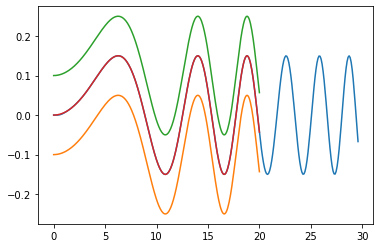

In [6]:
model = mpc_model()
mpc = controller(model,x_ref,y_ref)
simulator = mpc_simulator(model,x_ref,y_ref)
estimator = do_mpc.estimator.StateFeedback(model)

# x0=np.array([[0],[0],[0.001],[(np.pi/4)*(0.03)],[0],[0],[0],[0]])
simulator.x0['xc'] = 0
simulator.x0['yc'] = 0
simulator.x0['v'] = 1
simulator.x0['theta'] = 0
simulator.x0['phi'] = 0
simulator.x0['delta'] = 0
# simulator.x0['a_s'] = 0
# simulator.x0['w_s'] = 0

simulator.x0['z'] = vertcat(0)

x0 = simulator.x0.cat.full()
mpc.u0['a'] = 0
mpc.u0['w'] = 0
mpc.u0['u_v'] = 1

mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

state = []
x = []
y = []
for k in range(N_ref):
    print('\n\n################################################    ' + str(k) + '    #########################################\n\n')
    state.append(x0)
    x.append(x0[0])
    y.append(x0[1])
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
    
plt.plot(x,y)
plt.plot(x_ref,y_ref-1e-1)
plt.plot(x_ref,y_ref+1e-1)
plt.plot(x_ref,y_ref)

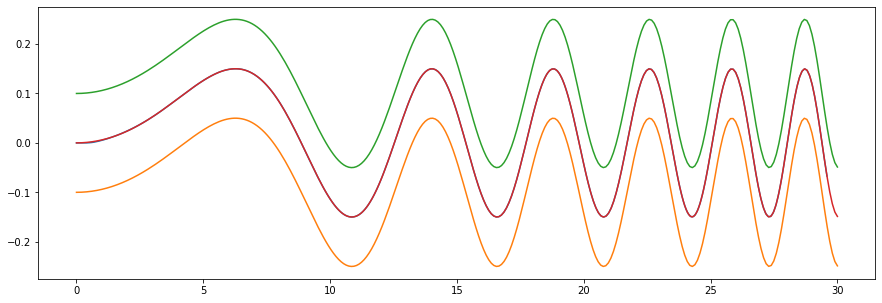

In [15]:
f = plt.figure(figsize=(15,5))
plt.plot(x,y)

x_ref=np.linspace(0,30,N_ref)
y_ref= y_x(x_ref)

plt.plot(x_ref,y_ref-1e-1)
plt.plot(x_ref,y_ref+1e-1)
plt.plot(x_ref,y_ref)



simulator.x0['xc'] = 0      
simulator.x0['yc'] = 0                  
simulator.x0['v'] = 0.001                       
simulator.x0['theta'] = (np.pi/4)*(0.03)                       
simulator.x0['phi'] = 0                     
simulator.x0['delta'] = 0               
simulator.x0['a_s'] = 0                     
simulator.x0['w_s'] = 0                 


In [20]:
for i in state:
    print(i[7])

[0.9996222]
[1.20913915]
[3.68321113e-05]
[0.00010176]
[0.44344681]
[0.50293007]
[0.49586299]
[0.50025226]
[0.34408834]
[0.55707889]
[0.35538652]
[0.55065427]
[0.38692607]
[0.58245665]
[0.42030154]
[0.59565634]
[0.43560278]
[0.58645834]
[0.43328896]
[0.5581483]
[0.42920467]
[0.53620688]
[0.4332956]
[0.52313076]
[0.44492444]
[0.51773802]
[0.45735361]
[0.5152505]
[0.46863977]
[0.51467257]
[0.47907572]
[0.51598987]
[0.4901138]
[0.51775589]
[0.49987193]
[0.52363472]
[0.50923892]
[0.52996592]
[0.51947806]
[0.53743521]
[0.52945695]
[0.54559791]
[0.5408254]
[0.55418724]
[0.55236859]
[0.56370796]
[0.56409613]
[0.57400181]
[0.57602744]
[0.58491893]
[0.58814607]
[0.59631662]
[0.60041589]
[0.60825976]
[0.61237134]
[0.62031054]
[0.62481388]
[0.63245528]
[0.63661095]
[0.64440267]
[0.64892807]
[0.65563484]
[0.66047221]
[0.66664608]
[0.67130483]
[0.6770122]
[0.68130777]
[0.68647524]
[0.69021208]
[0.69475364]
[0.69784232]
[0.70162822]
[0.70389395]
[0.70640963]
[0.70896615]
[0.70932091]
[0.71093461]
[0